In [1]:
%load_ext watermark
%watermark -v -p numpy,sklearn,scipy,matplotlib,tensorflow

CPython 3.6.6
IPython 6.5.0

numpy 1.14.5
sklearn 0.19.1
scipy 1.1.0
matplotlib 2.2.2
tensorflow 1.10.0


**11장 – 심층 신경망 훈련**

_이 노트북은 11장에 있는 연습문제 해답을 가지고 있습니다._

# 설정

파이썬 2와 3을 모두 지원합니다. 공통 모듈을 임포트하고 맷플롯립 그림이 노트북 안에 포함되도록 설정하고 생성한 그림을 저장하기 위한 함수를 준비합니다:

In [2]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [3]:
import tensorflow as tf

# 연습문제 해답

## 1. to 7.

부록 A 참조.

## 8. 딥러닝

### 8.1.

_문제: He 초기화와 ELU 활성화 함수를 사용하여 각각 뉴런이 100개인 은닉층 다섯 개를 가진 DNN을 만드세요._

다음 연습문제도 비슷한 모델을 만들어야하므로 여기서 DNN을 구성하는 함수를 만들겠습니다:

In [4]:
he_init = tf.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None,
        activation=tf.nn.elu, initializer=he_init):
    with tf.variable_scope(name, "dnn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
                                     kernel_initializer=initializer,
                                     name="hidden%d" % (layer + 1))
        return inputs

In [5]:
n_inputs = 28 * 28 # MNIST
n_outputs = 5

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

### 8.2.

_문제: Adam 최적화와 조기 종료를 사용하여 MNIST 데이터셋에 훈련시키되 0에서 4까지의 숫자만 사용하세요. 다음 연습문제에서 5에서 9까지의 숫자에 대해 전이 학습을 사용할 것입니다. 출력층은 다섯 개의 뉴런에 소프트맥스 함수를 사용합니다. 나중에 재사용할 수 있도록 항상 일정한 간격으로 체크포인트와 최종 모델을 저장하세요._

비용 함수, 훈련 연산과 다른 필요한 구성 요소를 만듭니다:

In [6]:
learning_rate = 0.01

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

MNIST 데이터셋을 로드합니다:

주의: `tf.examples.tutorials.mnist`은 삭제될 예정이므로 대신 `tf.keras.datasets.mnist`를 사용하겠습니다.

In [7]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

훈련 세트, 검증 세트, 테스트 세트를 만듭니다(검증 세트는 조기 종료에 사용합니다):

In [8]:
X_train1 = X_train[y_train < 5]
y_train1 = y_train[y_train < 5]
X_valid1 = X_valid[y_valid < 5]
y_valid1 = y_valid[y_valid < 5]
X_test1 = X_test[y_test < 5]
y_test1 = y_test[y_test < 5]

In [9]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        for rnd_indices in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_indices], y_train1[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid1, y: y_valid1})
        if loss_val < best_loss:
            save_path = saver.save(sess, "./my_mnist_model_0_to_4.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_model_0_to_4.ckpt")
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

0	검증 세트 손실: 0.115644	최선의 손실: 0.115644	정확도: 97.26%
1	검증 세트 손실: 0.151592	최선의 손실: 0.115644	정확도: 96.99%
2	검증 세트 손실: 0.122306	최선의 손실: 0.115644	정확도: 97.38%
3	검증 세트 손실: 0.141839	최선의 손실: 0.115644	정확도: 96.76%
4	검증 세트 손실: 0.132730	최선의 손실: 0.115644	정확도: 97.38%
5	검증 세트 손실: 0.869536	최선의 손실: 0.115644	정확도: 57.94%
6	검증 세트 손실: 0.735208	최선의 손실: 0.115644	정확도: 60.52%
7	검증 세트 손실: 0.734695	최선의 손실: 0.115644	정확도: 60.20%
8	검증 세트 손실: 0.575053	최선의 손실: 0.115644	정확도: 77.01%
9	검증 세트 손실: 0.501911	최선의 손실: 0.115644	정확도: 77.68%
10	검증 세트 손실: 1.649528	최선의 손실: 0.115644	정확도: 22.01%
11	검증 세트 손실: 1.694344	최선의 손실: 0.115644	정확도: 22.01%
12	검증 세트 손실: 1.662061	최선의 손실: 0.115644	정확도: 18.73%
13	검증 세트 손실: 1.629186	최선의 손실: 0.115644	정확도: 20.91%
14	검증 세트 손실: 1.647740	최선의 손실: 0.115644	정확도: 20.91%
15	검증 세트 손실: 1.635641	최선의 손실: 0.115644	정확도: 20.91%
16	검증 세트 손실: 1.718708	최선의 손실: 0.115644	정확도: 19.08%
17	검증 세트 손실: 1.682444	최선의 손실: 0.115644	정확도: 19.27%
18	검증 세트 손실: 1.675369	최선의 손실: 0.115644	정확도: 18.73%
19	검증 세트 손실: 1.645804	최선의 손실: 0.115644	정확

아주 나쁘지는 않지만 하이퍼파라미터를 튜닝하여 더 개선할 수 있을지 보겠습니다.

### 8.3.

_문제: 교차 검증을 사용하여 하이퍼파라미터를 튜닝하고 얼마의 성능을 달성할 수 있는지 확인해보세요._

하이퍼파라미터 튜닝을 하기 위해 사이킷런의 `RandomizedSearchCV` 클래스와 호환되는 `DNNClassifier` 클래스를 만듭니다. 이 클래스의 핵심은 다음과 같습니다:
* `__init__()` 메서드(생성자)는 각 하이퍼파라미터에 대한 인스턴스 변수를 만듭니다.
* `fit()` 메서드는 그래프를 만들고 세션을 시작해 모델을 훈련시킵니다:
  * `_build_graph()` 메서드를 호출해 그래프를 만듭니다(앞서 만든 그래프와 비슷합니다). 그래프가 만들어지면 다른 메서드에서 접근할 수 있도록 중요한 연산은 모두 인스턴스 변수로 저장합니다.
  * `_dnn()` 메서드는 위의 `dnn()` 함수와 비슷하게 은닉층을 만들고 배치 정규화와 드롭아웃을 추가합니다(다음 연습문제를 위해).
  * `fit()` 메서드에는 검증 세트(`X_valid`와 `y_valid`)가 주어지면 조기 종료를 실행합니다. 여기에서는 디스키 대신 메모리에 최상의 모델을 저장합니다. 이 함수는 그래프의 모든 변수와 값을 가져오기 위해 `_get_model_params()` 함수를 사용하고 (최상의 모델에서) 변수 값을 복원하기 위해 `_restore_model_params()` 함수를 사용합니다. 이런 방식은 훈련 속도를 높여 줍니다.
  * `fit()` 메서드가 모델 훈련을 마치면 예측을 만들기 위해 모델을 저장하고 복원하는 대신에 빠르게 예측을 만들기 위해 그대로 세션을 열어 둡니다. `close_session()` 메서드를 호출해 세션을 닫을 수 있습니다.
  * `predict_proba()` 메서드는 훈련 모델을 사용해 클래스 확률을 예측합니다.
  * `predict()` 메서드는 `predict_proba()`를 호출해 각 샘플에 대해 가장 높은 확률을 가진 클래스를 반환합니다.

In [10]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """모든 하이퍼파파미터를 저장하는 것으로 DNNClassifier를 초기화합니다."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None

    def _dnn(self, inputs):
        """배치 정규화와 드롭아웃 기능을 넣어 은닉층을 구성합니다."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """이전과 동일한 모델을 만듭니다."""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # 중요한 연산은 인스턴스 변수로 저장하여 참조하기 쉽게 합니다.
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """모든 변수 값을 가져옵니다 (조기 종료를 위해 사용하며 디스크에 저장하는 것보다 빠릅니다)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """모든 변수를 주어진 값으로 설정합니다 (조기 종료를 위해 사용하며 디스크에 저장하는 것보다 빠릅니다)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """훈련 세트에 모델을 훈련시킵니다. X_valid와 y_valid가 주어지면 조기 종료를 적용합니다."""
        self.close_session()

        # 훈련 세트로부터 n_inputs와 n_outputs를 구합니다.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # 레이블 벡터를 정렬된 클래스 인덱스 벡터로 변환합니다.
        # 0부터 n_outputs - 1까지의 정수를 담고 있게 됩니다.
        # 예를 들어, y가 [8, 8, 9, 5, 7, 6, 6, 6]이면 
        # 정렬된 클래스 레이블(self.classes_)은 [5, 6, 7, 8, 9]가 되고
        # 레이블 벡터는 [3, 3, 4, 0, 2, 1, 1, 1]로 변환됩니다.
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # 배치 정규화를 위한 추가 연산
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # 조기 종료를 위해
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # 이제 모델을 훈련합니다!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("조기 종료!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\t마지막 훈련 배치 손실: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # 조기 종료를 사용하면 이전의 최상의 모델로 되돌립니다.
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("%s 객체가 아직 훈련되지 않았습니다" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

이 클래스를 사용하여 이전과 비슷한 정확도가 나오는지 확인해 보죠(드롭아웃과 배치 정규화는 사용하지 않습니다):

In [11]:
dnn_clf = DNNClassifier(random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.126637	최선의 손실: 0.126637	정확도: 96.68%
1	검증 세트 손실: 0.639000	최선의 손실: 0.126637	정확도: 86.67%
2	검증 세트 손실: 0.139003	최선의 손실: 0.126637	정확도: 96.79%
3	검증 세트 손실: 0.127070	최선의 손실: 0.126637	정확도: 96.01%
4	검증 세트 손실: 0.107300	최선의 손실: 0.107300	정확도: 98.05%
5	검증 세트 손실: 0.135808	최선의 손실: 0.107300	정확도: 97.22%
6	검증 세트 손실: 0.202267	최선의 손실: 0.107300	정확도: 96.09%
7	검증 세트 손실: 0.091173	최선의 손실: 0.091173	정확도: 97.97%
8	검증 세트 손실: 0.158916	최선의 손실: 0.091173	정확도: 97.22%
9	검증 세트 손실: 0.167819	최선의 손실: 0.091173	정확도: 96.95%
10	검증 세트 손실: 0.143308	최선의 손실: 0.091173	정확도: 97.42%
11	검증 세트 손실: 0.096128	최선의 손실: 0.091173	정확도: 98.51%
12	검증 세트 손실: 0.112943	최선의 손실: 0.091173	정확도: 98.12%
13	검증 세트 손실: 0.744877	최선의 손실: 0.091173	정확도: 65.52%
14	검증 세트 손실: 0.448146	최선의 손실: 0.091173	정확도: 90.89%
15	검증 세트 손실: 0.324630	최선의 손실: 0.091173	정확도: 93.75%
16	검증 세트 손실: 0.273591	최선의 손실: 0.091173	정확도: 96.13%
17	검증 세트 손실: 0.314510	최선의 손실: 0.091173	정확도: 94.49%
18	검증 세트 손실: 0.159164	최선의 손실: 0.091173	정확도: 97.42%
19	검증 세트 손실: 0.566951	최선의 손실: 0.091173	정확

DNNClassifier(activation=<function elu at 0x7fa249896950>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7fa23ea9c128>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

모델 훈련이 완료되면 이전과 비슷한 정확도가 나오는지 확인해 보겠습니다:

In [12]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9809301420509827

좋네요! 잘 작동합니다. 이제 사이킷런의 `RandomizedSearchCV` 클래스를 사용해서 더 나은 하이퍼파라미터를 찾아보겠습니다(시스템에 따라 이 작업은 한 시간 이상 걸릴지 모릅니다):

In [13]:
from sklearn.model_selection import RandomizedSearchCV

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # 은닉층의 수나 옵티마이저 등을 달리하여 탐색해 볼 수 있습니다.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
}

# 생성자에 넘겨주는 fit_params 매개변수는 사이킷런 0.19 버전부터 경고가 발생하고 0.21 버전에서 사라지므로
# 대신 fit() 메서드에 매개변수로 전달해야 합니다.:
rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                random_state=42, verbose=2)
fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
rnd_search.fit(X_train1, y_train1, **fit_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=10, learning_rate=0.05, batch_size=100, activation=<function elu at 0x7fa249896950> 
0	검증 세트 손실: 0.125898	최선의 손실: 0.125898	정확도: 96.48%
1	검증 세트 손실: 0.150996	최선의 손실: 0.125898	정확도: 95.93%
2	검증 세트 손실: 0.112830	최선의 손실: 0.112830	정확도: 96.95%
3	검증 세트 손실: 0.127841	최선의 손실: 0.112830	정확도: 96.95%
4	검증 세트 손실: 0.131305	최선의 손실: 0.112830	정확도: 96.21%
5	검증 세트 손실: 0.132231	최선의 손실: 0.112830	정확도: 96.76%
6	검증 세트 손실: 0.116567	최선의 손실: 0.112830	정확도: 96.91%
7	검증 세트 손실: 0.159476	최선의 손실: 0.112830	정확도: 95.54%
8	검증 세트 손실: 1.375401	최선의 손실: 0.112830	정확도: 34.68%
9	검증 세트 손실: 1.176499	최선의 손실: 0.112830	정확도: 40.34%
10	검증 세트 손실: 1.215704	최선의 손실: 0.112830	정확도: 35.22%
11	검증 세트 손실: 1.116786	최선의 손실: 0.112830	정확도: 42.65%
12	검증 세트 손실: 1.453463	최선의 손실: 0.112830	정확도: 50.27%
13	검증 세트 손실: 1.125956	최선의 손실: 0.112830	정확도: 36.32%
14	검증 세트 손실: 1.132249	최선의 손실: 0.112830	정확도: 40.27%
15	검증 세트 손실: 1.111125	최선의 손실: 0.112830	정확도: 39.72%
16	검증 세트 손실: 1.132160	최선의 손실: 0.

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s


0	검증 세트 손실: 0.187498	최선의 손실: 0.187498	정확도: 95.19%
1	검증 세트 손실: 0.210733	최선의 손실: 0.187498	정확도: 95.66%
2	검증 세트 손실: 0.156735	최선의 손실: 0.156735	정확도: 96.79%
3	검증 세트 손실: 0.133240	최선의 손실: 0.133240	정확도: 96.79%
4	검증 세트 손실: 0.112930	최선의 손실: 0.112930	정확도: 96.91%
5	검증 세트 손실: 0.120869	최선의 손실: 0.112930	정확도: 96.99%
6	검증 세트 손실: 1.056901	최선의 손실: 0.112930	정확도: 73.61%
7	검증 세트 손실: 1.622569	최선의 손실: 0.112930	정확도: 19.08%
8	검증 세트 손실: 1.612355	최선의 손실: 0.112930	정확도: 19.27%
9	검증 세트 손실: 1.615099	최선의 손실: 0.112930	정확도: 22.01%
10	검증 세트 손실: 1.618115	최선의 손실: 0.112930	정확도: 19.27%
11	검증 세트 손실: 1.623693	최선의 손실: 0.112930	정확도: 22.01%
12	검증 세트 손실: 1.629313	최선의 손실: 0.112930	정확도: 20.91%
13	검증 세트 손실: 1.636847	최선의 손실: 0.112930	정확도: 19.27%
14	검증 세트 손실: 1.622683	최선의 손실: 0.112930	정확도: 22.01%
15	검증 세트 손실: 1.615186	최선의 손실: 0.112930	정확도: 22.01%
16	검증 세트 손실: 1.622470	최선의 손실: 0.112930	정확도: 22.01%
17	검증 세트 손실: 1.618107	최선의 손실: 0.112930	정확도: 18.73%
18	검증 세트 손실: 1.628681	최선의 손실: 0.112930	정확도: 22.01%
19	검증 세트 손실: 1.617748	최선의 손실: 0.112930	정확

0	검증 세트 손실: 835.306030	최선의 손실: 835.306030	정확도: 40.54%
1	검증 세트 손실: 5.698731	최선의 손실: 5.698731	정확도: 60.95%
2	검증 세트 손실: 7.265121	최선의 손실: 5.698731	정확도: 56.61%
3	검증 세트 손실: 3.298490	최선의 손실: 3.298490	정확도: 70.72%
4	검증 세트 손실: 2.056194	최선의 손실: 2.056194	정확도: 74.39%
5	검증 세트 손실: 1.108074	최선의 손실: 1.108074	정확도: 81.59%
6	검증 세트 손실: 1488.500732	최선의 손실: 1.108074	정확도: 40.07%
7	검증 세트 손실: 712.205444	최선의 손실: 1.108074	정확도: 66.77%
8	검증 세트 손실: 154.130600	최선의 손실: 1.108074	정확도: 69.00%
9	검증 세트 손실: 89.800911	최선의 손실: 1.108074	정확도: 73.18%
10	검증 세트 손실: 162.215134	최선의 손실: 1.108074	정확도: 75.57%
11	검증 세트 손실: 86.575775	최선의 손실: 1.108074	정확도: 83.58%
12	검증 세트 손실: 149.414734	최선의 손실: 1.108074	정확도: 76.78%
13	검증 세트 손실: 59.893036	최선의 손실: 1.108074	정확도: 84.13%
14	검증 세트 손실: 100.595726	최선의 손실: 1.108074	정확도: 85.03%
15	검증 세트 손실: 119.831604	최선의 손실: 1.108074	정확도: 72.60%
16	검증 세트 손실: 5382.897461	최선의 손실: 1.108074	정확도: 37.84%
17	검증 세트 손실: 143.867996	최선의 손실: 1.108074	정확도: 76.90%
18	검증 세트 손실: 780.024170	최선의 손실: 1.108074	정확도: 68.57%
19	검증 세트 손실:

9	검증 세트 손실: 1672.568848	최선의 손실: 0.144802	정확도: 91.20%
10	검증 세트 손실: 3176.944092	최선의 손실: 0.144802	정확도: 86.67%
11	검증 세트 손실: 2764.572510	최선의 손실: 0.144802	정확도: 93.86%
12	검증 세트 손실: 2338.220215	최선의 손실: 0.144802	정확도: 91.52%
13	검증 세트 손실: 2532.326416	최선의 손실: 0.144802	정확도: 95.11%
14	검증 세트 손실: 963.370605	최선의 손실: 0.144802	정확도: 95.78%
15	검증 세트 손실: 8042231.000000	최선의 손실: 0.144802	정확도: 61.85%
16	검증 세트 손실: 84455.984375	최선의 손실: 0.144802	정확도: 94.29%
17	검증 세트 손실: 51065.937500	최선의 손실: 0.144802	정확도: 94.10%
18	검증 세트 손실: 28558.527344	최선의 손실: 0.144802	정확도: 96.09%
19	검증 세트 손실: 169327.578125	최선의 손실: 0.144802	정확도: 90.89%
20	검증 세트 손실: 94630.125000	최선의 손실: 0.144802	정확도: 96.17%
21	검증 세트 손실: 91388.992188	최선의 손실: 0.144802	정확도: 94.88%
22	검증 세트 손실: 89512.453125	최선의 손실: 0.144802	정확도: 92.03%
23	검증 세트 손실: 23145.212891	최선의 손실: 0.144802	정확도: 97.22%
조기 종료!
[CV]  n_neurons=70, learning_rate=0.1, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa21418a488>, total=  11.2s
[CV] n_neurons=120, 

36	검증 세트 손실: 0.097817	최선의 손실: 0.042468	정확도: 98.94%
37	검증 세트 손실: 0.048689	최선의 손실: 0.042468	정확도: 98.91%
38	검증 세트 손실: 0.075272	최선의 손실: 0.042468	정확도: 98.83%
39	검증 세트 손실: 0.069669	최선의 손실: 0.042468	정확도: 98.83%
40	검증 세트 손실: 0.083348	최선의 손실: 0.042468	정확도: 98.67%
41	검증 세트 손실: 0.050039	최선의 손실: 0.042468	정확도: 99.06%
42	검증 세트 손실: 0.076907	최선의 손실: 0.042468	정확도: 98.83%
43	검증 세트 손실: 0.077382	최선의 손실: 0.042468	정확도: 98.28%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.01, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa2c83217b8>, total=   4.0s
[CV] n_neurons=90, learning_rate=0.01, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa2c83217b8> 
0	검증 세트 손실: 0.086824	최선의 손실: 0.086824	정확도: 97.42%
1	검증 세트 손실: 0.062813	최선의 손실: 0.062813	정확도: 98.01%
2	검증 세트 손실: 0.058913	최선의 손실: 0.058913	정확도: 98.12%
3	검증 세트 손실: 0.060694	최선의 손실: 0.058913	정확도: 98.40%
4	검증 세트 손실: 0.038613	최선의 손실: 0.038613	정확도: 98.71%
5	검증 세트 손실: 0.067318	최선의 손실: 0.038613	정확

0	검증 세트 손실: 0.108754	최선의 손실: 0.108754	정확도: 96.68%
1	검증 세트 손실: 0.076621	최선의 손실: 0.076621	정확도: 97.54%
2	검증 세트 손실: 0.066869	최선의 손실: 0.066869	정확도: 98.08%
3	검증 세트 손실: 0.059805	최선의 손실: 0.059805	정확도: 98.20%
4	검증 세트 손실: 0.050830	최선의 손실: 0.050830	정확도: 98.36%
5	검증 세트 손실: 0.050915	최선의 손실: 0.050830	정확도: 98.32%
6	검증 세트 손실: 0.054091	최선의 손실: 0.050830	정확도: 98.44%
7	검증 세트 손실: 0.041233	최선의 손실: 0.041233	정확도: 98.71%
8	검증 세트 손실: 0.049014	최선의 손실: 0.041233	정확도: 98.51%
9	검증 세트 손실: 0.056154	최선의 손실: 0.041233	정확도: 98.79%
10	검증 세트 손실: 0.073769	최선의 손실: 0.041233	정확도: 98.36%
11	검증 세트 손실: 0.068577	최선의 손실: 0.041233	정확도: 98.48%
12	검증 세트 손실: 0.051813	최선의 손실: 0.041233	정확도: 98.55%
13	검증 세트 손실: 0.059133	최선의 손실: 0.041233	정확도: 98.71%
14	검증 세트 손실: 0.054700	최선의 손실: 0.041233	정확도: 98.71%
15	검증 세트 손실: 0.057724	최선의 손실: 0.041233	정확도: 98.83%
16	검증 세트 손실: 0.060262	최선의 손실: 0.041233	정확도: 98.87%
17	검증 세트 손실: 0.075748	최선의 손실: 0.041233	정확도: 98.63%
18	검증 세트 손실: 0.065124	최선의 손실: 0.041233	정확도: 98.36%
19	검증 세트 손실: 0.074710	최선의 손실: 0.041233	정확

19	검증 세트 손실: 1.619094	최선의 손실: 1.612442	정확도: 22.01%
20	검증 세트 손실: 1.609109	최선의 손실: 1.609109	정확도: 22.01%
21	검증 세트 손실: 1.689012	최선의 손실: 1.609109	정확도: 22.01%
22	검증 세트 손실: 1.618890	최선의 손실: 1.609109	정확도: 18.73%
23	검증 세트 손실: 1.638926	최선의 손실: 1.609109	정확도: 22.01%
24	검증 세트 손실: 1.660615	최선의 손실: 1.609109	정확도: 20.91%
25	검증 세트 손실: 1.619330	최선의 손실: 1.609109	정확도: 19.27%
26	검증 세트 손실: 1.611331	최선의 손실: 1.609109	정확도: 22.01%
27	검증 세트 손실: 1.614303	최선의 손실: 1.609109	정확도: 20.91%
28	검증 세트 손실: 1.628118	최선의 손실: 1.609109	정확도: 19.08%
29	검증 세트 손실: 1.610351	최선의 손실: 1.609109	정확도: 20.91%
30	검증 세트 손실: 1.626937	최선의 손실: 1.609109	정확도: 20.91%
31	검증 세트 손실: 1.633268	최선의 손실: 1.609109	정확도: 18.73%
32	검증 세트 손실: 1.609064	최선의 손실: 1.609064	정확도: 22.01%
33	검증 세트 손실: 1.610650	최선의 손실: 1.609064	정확도: 19.08%
34	검증 세트 손실: 1.616982	최선의 손실: 1.609064	정확도: 22.01%
35	검증 세트 손실: 1.627556	최선의 손실: 1.609064	정확도: 19.27%
36	검증 세트 손실: 1.609165	최선의 손실: 1.609064	정확도: 20.91%
37	검증 세트 손실: 1.626448	최선의 손실: 1.609064	정확도: 19.27%
38	검증 세트 손실: 1.614501	최선의 손실: 1

0	검증 세트 손실: 0.135848	최선의 손실: 0.135848	정확도: 96.68%
1	검증 세트 손실: 0.151916	최선의 손실: 0.135848	정확도: 96.68%
2	검증 세트 손실: 0.941191	최선의 손실: 0.135848	정확도: 57.08%
3	검증 세트 손실: 0.654037	최선의 손실: 0.135848	정확도: 74.71%
4	검증 세트 손실: 0.472582	최선의 손실: 0.135848	정확도: 83.66%
5	검증 세트 손실: 0.395305	최선의 손실: 0.135848	정확도: 85.65%
6	검증 세트 손실: 0.322289	최선의 손실: 0.135848	정확도: 89.41%
7	검증 세트 손실: 0.327791	최선의 손실: 0.135848	정확도: 88.94%
8	검증 세트 손실: 0.301365	최선의 손실: 0.135848	정확도: 90.58%
9	검증 세트 손실: 0.305761	최선의 손실: 0.135848	정확도: 90.97%
10	검증 세트 손실: 0.291775	최선의 손실: 0.135848	정확도: 90.89%
11	검증 세트 손실: 0.266077	최선의 손실: 0.135848	정확도: 92.03%
12	검증 세트 손실: 0.274660	최선의 손실: 0.135848	정확도: 91.36%
13	검증 세트 손실: 0.256886	최선의 손실: 0.135848	정확도: 92.42%
14	검증 세트 손실: 1.528604	최선의 손실: 0.135848	정확도: 42.46%
15	검증 세트 손실: 1.202969	최선의 손실: 0.135848	정확도: 47.81%
16	검증 세트 손실: 1.229077	최선의 손실: 0.135848	정확도: 48.79%
17	검증 세트 손실: 2037.057861	최선의 손실: 0.135848	정확도: 32.02%
18	검증 세트 손실: 49.882771	최선의 손실: 0.135848	정확도: 52.03%
19	검증 세트 손실: 20.568983	최선의 손실: 0.1358

12	검증 세트 손실: 0.094906	최선의 손실: 0.066368	정확도: 98.59%
13	검증 세트 손실: 0.116070	최선의 손실: 0.066368	정확도: 97.34%
14	검증 세트 손실: 0.096956	최선의 손실: 0.066368	정확도: 98.01%
15	검증 세트 손실: 0.371979	최선의 손실: 0.066368	정확도: 97.50%
16	검증 세트 손실: 0.178572	최선의 손실: 0.066368	정확도: 97.54%
17	검증 세트 손실: 0.136336	최선의 손실: 0.066368	정확도: 98.05%
18	검증 세트 손실: 0.128335	최선의 손실: 0.066368	정확도: 98.12%
19	검증 세트 손실: 0.151619	최선의 손실: 0.066368	정확도: 98.40%
20	검증 세트 손실: 0.145948	최선의 손실: 0.066368	정확도: 98.08%
21	검증 세트 손실: 0.153420	최선의 손실: 0.066368	정확도: 98.24%
22	검증 세트 손실: 0.187027	최선의 손실: 0.066368	정확도: 98.48%
23	검증 세트 손실: 0.182177	최선의 손실: 0.066368	정확도: 98.01%
24	검증 세트 손실: 0.237525	최선의 손실: 0.066368	정확도: 97.69%
25	검증 세트 손실: 0.156335	최선의 손실: 0.066368	정확도: 98.24%
26	검증 세트 손실: 0.182545	최선의 손실: 0.066368	정확도: 98.24%
27	검증 세트 손실: 0.182726	최선의 손실: 0.066368	정확도: 98.48%
28	검증 세트 손실: 0.271172	최선의 손실: 0.066368	정확도: 97.89%
29	검증 세트 손실: 0.597482	최선의 손실: 0.066368	정확도: 97.03%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.01, batch_size=50, activation=<function

14	검증 세트 손실: 1.614973	최선의 손실: 0.236403	정확도: 19.27%
15	검증 세트 손실: 1.621241	최선의 손실: 0.236403	정확도: 19.27%
16	검증 세트 손실: 1.613991	최선의 손실: 0.236403	정확도: 19.27%
17	검증 세트 손실: 1.612874	최선의 손실: 0.236403	정확도: 19.27%
18	검증 세트 손실: 1.614916	최선의 손실: 0.236403	정확도: 19.27%
19	검증 세트 손실: 1.612983	최선의 손실: 0.236403	정확도: 18.73%
20	검증 세트 손실: 1.613729	최선의 손실: 0.236403	정확도: 18.73%
21	검증 세트 손실: 1.610459	최선의 손실: 0.236403	정확도: 20.91%
22	검증 세트 손실: 1.626659	최선의 손실: 0.236403	정확도: 22.01%
23	검증 세트 손실: 1.618221	최선의 손실: 0.236403	정확도: 19.08%
24	검증 세트 손실: 1.623409	최선의 손실: 0.236403	정확도: 22.01%
25	검증 세트 손실: 1.612231	최선의 손실: 0.236403	정확도: 19.27%
26	검증 세트 손실: 1.611478	최선의 손실: 0.236403	정확도: 22.01%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.1, batch_size=500, activation=<function elu at 0x7fa249896950>, total=   2.2s
[CV] n_neurons=50, learning_rate=0.1, batch_size=500, activation=<function elu at 0x7fa249896950> 
0	검증 세트 손실: 1.719815	최선의 손실: 1.719815	정확도: 22.01%
1	검증 세트 손실: 1.623654	최선의 손실: 1.623654	정확도: 19.08%
2	검증 세트 손실: 1.617

15	검증 세트 손실: 3569.501465	최선의 손실: 0.141945	정확도: 93.67%
16	검증 세트 손실: 3323.724365	최선의 손실: 0.141945	정확도: 94.41%
17	검증 세트 손실: 4187.774902	최선의 손실: 0.141945	정확도: 93.59%
18	검증 세트 손실: 4306.875000	최선의 손실: 0.141945	정확도: 94.49%
19	검증 세트 손실: 2686.671631	최선의 손실: 0.141945	정확도: 95.31%
20	검증 세트 손실: 5944.587402	최선의 손실: 0.141945	정확도: 92.14%
21	검증 세트 손실: 2253.790039	최선의 손실: 0.141945	정확도: 95.74%
22	검증 세트 손실: 7648.507324	최선의 손실: 0.141945	정확도: 94.53%
23	검증 세트 손실: 3374.908203	최선의 손실: 0.141945	정확도: 94.49%
24	검증 세트 손실: 2754.427979	최선의 손실: 0.141945	정확도: 95.78%
25	검증 세트 손실: 2624.722656	최선의 손실: 0.141945	정확도: 94.18%
26	검증 세트 손실: 22027.330078	최선의 손실: 0.141945	정확도: 75.80%
조기 종료!
[CV]  n_neurons=70, learning_rate=0.1, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa21418a488>, total=   7.2s
[CV] n_neurons=70, learning_rate=0.1, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa21418a488> 
0	검증 세트 손실: 20.711384	최선의 손실: 20.711384	정확도: 65.60%

25	검증 세트 손실: 2.078128	최선의 손실: 1.657116	정확도: 22.01%
26	검증 세트 손실: 2.804216	최선의 손실: 1.657116	정확도: 19.08%
27	검증 세트 손실: 2.394258	최선의 손실: 1.657116	정확도: 20.91%
28	검증 세트 손실: 1.977028	최선의 손실: 1.657116	정확도: 20.91%
29	검증 세트 손실: 1.721669	최선의 손실: 1.657116	정확도: 19.27%
30	검증 세트 손실: 2.203497	최선의 손실: 1.657116	정확도: 19.08%
31	검증 세트 손실: 2.605233	최선의 손실: 1.657116	정확도: 22.01%
32	검증 세트 손실: 2.066092	최선의 손실: 1.657116	정확도: 18.73%
33	검증 세트 손실: 2.527797	최선의 손실: 1.657116	정확도: 19.08%
34	검증 세트 손실: 2.730644	최선의 손실: 1.657116	정확도: 18.73%
35	검증 세트 손실: 2.582779	최선의 손실: 1.657116	정확도: 22.01%
36	검증 세트 손실: 2.845666	최선의 손실: 1.657116	정확도: 19.27%
37	검증 세트 손실: 1.998368	최선의 손실: 1.657116	정확도: 19.27%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.05, batch_size=10, activation=<function elu at 0x7fa249896950>, total= 1.0min
[CV] n_neurons=100, learning_rate=0.05, batch_size=10, activation=<function elu at 0x7fa249896950> 
0	검증 세트 손실: 1.844363	최선의 손실: 1.844363	정확도: 22.01%
1	검증 세트 손실: 2.120703	최선의 손실: 1.844363	정확도: 22.01%
2	검증 세트 손실: 2.1

7	검증 세트 손실: 0.912211	최선의 손실: 0.175670	정확도: 58.09%
8	검증 세트 손실: 0.884891	최선의 손실: 0.175670	정확도: 55.67%
9	검증 세트 손실: 0.796414	최선의 손실: 0.175670	정확도: 57.47%
10	검증 세트 손실: 0.725720	최선의 손실: 0.175670	정확도: 60.52%
11	검증 세트 손실: 0.731045	최선의 손실: 0.175670	정확도: 57.78%
12	검증 세트 손실: 0.755192	최선의 손실: 0.175670	정확도: 60.28%
13	검증 세트 손실: 0.735025	최선의 손실: 0.175670	정확도: 60.56%
14	검증 세트 손실: 0.739829	최선의 손실: 0.175670	정확도: 57.86%
15	검증 세트 손실: 0.739668	최선의 손실: 0.175670	정확도: 60.52%
16	검증 세트 손실: 0.777611	최선의 손실: 0.175670	정확도: 59.77%
17	검증 세트 손실: 0.776969	최선의 손실: 0.175670	정확도: 55.82%
18	검증 세트 손실: 0.728218	최선의 손실: 0.175670	정확도: 60.75%
19	검증 세트 손실: 1.234383	최선의 손실: 0.175670	정확도: 38.47%
20	검증 세트 손실: 1.236974	최선의 손실: 0.175670	정확도: 37.18%
21	검증 세트 손실: 1.251948	최선의 손실: 0.175670	정확도: 38.08%
조기 종료!
[CV]  n_neurons=30, learning_rate=0.05, batch_size=50, activation=<function relu at 0x7fa249827c80>, total=   8.1s
[CV] n_neurons=30, learning_rate=0.05, batch_size=50, activation=<function relu at 0x7fa249827c80> 
0	검증 세트 손실: 0.18

17	검증 세트 손실: 2.190455	최선의 손실: 0.089542	정확도: 94.84%
18	검증 세트 손실: 2.395469	최선의 손실: 0.089542	정확도: 93.67%
19	검증 세트 손실: 1.534942	최선의 손실: 0.089542	정확도: 94.49%
20	검증 세트 손실: 1.013022	최선의 손실: 0.089542	정확도: 95.82%
21	검증 세트 손실: 1.217905	최선의 손실: 0.089542	정확도: 94.29%
22	검증 세트 손실: 1.095672	최선의 손실: 0.089542	정확도: 96.72%
23	검증 세트 손실: 2.174586	최선의 손실: 0.089542	정확도: 95.62%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.05, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa21418a488>, total=   6.4s
[CV] n_neurons=10, learning_rate=0.02, batch_size=10, activation=<function elu at 0x7fa249896950> 
0	검증 세트 손실: 0.135378	최선의 손실: 0.135378	정확도: 96.36%
1	검증 세트 손실: 0.147551	최선의 손실: 0.135378	정확도: 95.35%
2	검증 세트 손실: 0.171260	최선의 손실: 0.135378	정확도: 96.01%
3	검증 세트 손실: 0.190115	최선의 손실: 0.135378	정확도: 94.92%
4	검증 세트 손실: 0.169391	최선의 손실: 0.135378	정확도: 96.87%
5	검증 세트 손실: 0.119646	최선의 손실: 0.119646	정확도: 96.64%
6	검증 세트 손실: 0.205473	최선의 손실: 0.119646	정확도: 95.50%
7	검증 세트 손실: 0.375998	최선의 손실: 0.1

60	검증 세트 손실: 0.200821	최선의 손실: 0.087136	정확도: 97.38%
61	검증 세트 손실: 0.320418	최선의 손실: 0.087136	정확도: 96.33%
62	검증 세트 손실: 0.232023	최선의 손실: 0.087136	정확도: 97.34%
63	검증 세트 손실: 0.259474	최선의 손실: 0.087136	정확도: 95.97%
64	검증 세트 손실: 0.203577	최선의 손실: 0.087136	정확도: 97.58%
65	검증 세트 손실: 0.189471	최선의 손실: 0.087136	정확도: 97.69%
66	검증 세트 손실: 0.214882	최선의 손실: 0.087136	정확도: 97.07%
67	검증 세트 손실: 0.203092	최선의 손실: 0.087136	정확도: 97.81%
68	검증 세트 손실: 0.217957	최선의 손실: 0.087136	정확도: 97.46%
69	검증 세트 손실: 0.279663	최선의 손실: 0.087136	정확도: 96.91%
70	검증 세트 손실: 0.221039	최선의 손실: 0.087136	정확도: 97.42%
71	검증 세트 손실: 0.187565	최선의 손실: 0.087136	정확도: 97.54%
72	검증 세트 손실: 0.213847	최선의 손실: 0.087136	정확도: 97.07%
73	검증 세트 손실: 0.238748	최선의 손실: 0.087136	정확도: 96.95%
74	검증 세트 손실: 0.180837	최선의 손실: 0.087136	정확도: 97.46%
75	검증 세트 손실: 0.181339	최선의 손실: 0.087136	정확도: 97.73%
76	검증 세트 손실: 0.165582	최선의 손실: 0.087136	정확도: 97.77%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.05, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0

6	검증 세트 손실: 0.543357	최선의 손실: 0.542706	정확도: 80.57%
7	검증 세트 손실: 0.521021	최선의 손실: 0.521021	정확도: 79.28%
8	검증 세트 손실: 0.509218	최선의 손실: 0.509218	정확도: 81.39%
9	검증 세트 손실: 0.474566	최선의 손실: 0.474566	정확도: 83.82%
10	검증 세트 손실: 0.524579	최선의 손실: 0.474566	정확도: 80.73%
11	검증 세트 손실: 0.508567	최선의 손실: 0.474566	정확도: 81.43%
12	검증 세트 손실: 0.495094	최선의 손실: 0.474566	정확도: 82.99%
13	검증 세트 손실: 0.486526	최선의 손실: 0.474566	정확도: 82.88%
14	검증 세트 손실: 0.553282	최선의 손실: 0.474566	정확도: 80.38%
15	검증 세트 손실: 0.481100	최선의 손실: 0.474566	정확도: 83.27%
16	검증 세트 손실: 0.557080	최선의 손실: 0.474566	정확도: 77.76%
17	검증 세트 손실: 0.490169	최선의 손실: 0.474566	정확도: 82.64%
18	검증 세트 손실: 0.515548	최선의 손실: 0.474566	정확도: 81.90%
19	검증 세트 손실: 0.488699	최선의 손실: 0.474566	정확도: 83.46%
20	검증 세트 손실: 0.548921	최선의 손실: 0.474566	정확도: 81.43%
21	검증 세트 손실: 0.515235	최선의 손실: 0.474566	정확도: 81.63%
22	검증 세트 손실: 0.480030	최선의 손실: 0.474566	정확도: 83.11%
23	검증 세트 손실: 0.486026	최선의 손실: 0.474566	정확도: 83.19%
24	검증 세트 손실: 0.601432	최선의 손실: 0.474566	정확도: 79.44%
25	검증 세트 손실: 0.498270	최선의 손실: 0.474

24	검증 세트 손실: 0.097165	최선의 손실: 0.081292	정확도: 97.73%
25	검증 세트 손실: 0.086964	최선의 손실: 0.081292	정확도: 97.89%
26	검증 세트 손실: 0.112987	최선의 손실: 0.081292	정확도: 97.34%
27	검증 세트 손실: 0.104511	최선의 손실: 0.081292	정확도: 97.54%
28	검증 세트 손실: 0.106577	최선의 손실: 0.081292	정확도: 97.62%
29	검증 세트 손실: 0.109134	최선의 손실: 0.081292	정확도: 97.69%
30	검증 세트 손실: 0.091526	최선의 손실: 0.081292	정확도: 97.77%
31	검증 세트 손실: 0.101824	최선의 손실: 0.081292	정확도: 97.69%
32	검증 세트 손실: 0.106206	최선의 손실: 0.081292	정확도: 97.62%
33	검증 세트 손실: 0.083869	최선의 손실: 0.081292	정확도: 97.81%
34	검증 세트 손실: 0.103975	최선의 손실: 0.081292	정확도: 97.62%
조기 종료!
[CV]  n_neurons=10, learning_rate=0.02, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa2c83217b8>, total=   3.3s
[CV] n_neurons=70, learning_rate=0.02, batch_size=100, activation=<function elu at 0x7fa249896950> 
0	검증 세트 손실: 0.098734	최선의 손실: 0.098734	정확도: 97.38%
1	검증 세트 손실: 0.208051	최선의 손실: 0.098734	정확도: 95.93%
2	검증 세트 손실: 0.068566	최선의 손실: 0.068566	정확도: 98.28%
3	검증 세트 손실: 0.108912	최선의 손실

20	검증 세트 손실: 0.116283	최선의 손실: 0.078039	정확도: 98.12%
21	검증 세트 손실: 0.129972	최선의 손실: 0.078039	정확도: 97.77%
22	검증 세트 손실: 0.138107	최선의 손실: 0.078039	정확도: 98.12%
23	검증 세트 손실: 0.137756	최선의 손실: 0.078039	정확도: 98.08%
24	검증 세트 손실: 0.130980	최선의 손실: 0.078039	정확도: 98.28%
25	검증 세트 손실: 0.147018	최선의 손실: 0.078039	정확도: 98.12%
26	검증 세트 손실: 0.136808	최선의 손실: 0.078039	정확도: 97.85%
27	검증 세트 손실: 0.132536	최선의 손실: 0.078039	정확도: 98.08%
조기 종료!
[CV]  n_neurons=30, learning_rate=0.02, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa21418a488>, total=   7.3s
[CV] n_neurons=30, learning_rate=0.02, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa21418a488> 
0	검증 세트 손실: 0.104337	최선의 손실: 0.104337	정확도: 97.50%
1	검증 세트 손실: 0.080536	최선의 손실: 0.080536	정확도: 97.89%
2	검증 세트 손실: 0.097599	최선의 손실: 0.080536	정확도: 97.34%
3	검증 세트 손실: 0.136538	최선의 손실: 0.080536	정확도: 97.34%
4	검증 세트 손실: 0.204719	최선의 손실: 0.080536	정확도: 96.01%
5	검증 세트 손실: 0.131028	최선의 손실: 0.080536	정확

10	검증 세트 손실: 1.409868	최선의 손실: 0.145056	정확도: 40.15%
11	검증 세트 손실: 1.644645	최선의 손실: 0.145056	정확도: 19.27%
12	검증 세트 손실: 1.639462	최선의 손실: 0.145056	정확도: 20.91%
13	검증 세트 손실: 1.635790	최선의 손실: 0.145056	정확도: 22.01%
14	검증 세트 손실: 1.738880	최선의 손실: 0.145056	정확도: 22.01%
15	검증 세트 손실: 1.707568	최선의 손실: 0.145056	정확도: 18.73%
16	검증 세트 손실: 1.648083	최선의 손실: 0.145056	정확도: 19.27%
17	검증 세트 손실: 1.673819	최선의 손실: 0.145056	정확도: 20.91%
18	검증 세트 손실: 1.719737	최선의 손실: 0.145056	정확도: 22.01%
19	검증 세트 손실: 1.663783	최선의 손실: 0.145056	정확도: 22.01%
20	검증 세트 손실: 1.806598	최선의 손실: 0.145056	정확도: 19.27%
21	검증 세트 손실: 1.843002	최선의 손실: 0.145056	정확도: 22.01%
22	검증 세트 손실: 1.709954	최선의 손실: 0.145056	정확도: 19.27%
23	검증 세트 손실: 1.711245	최선의 손실: 0.145056	정확도: 22.01%
24	검증 세트 손실: 1.874390	최선의 손실: 0.145056	정확도: 18.73%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.1, batch_size=100, activation=<function elu at 0x7fa249896950>, total=   5.3s
[CV] n_neurons=90, learning_rate=0.1, batch_size=100, activation=<function elu at 0x7fa249896950> 
0	검증 세트 손실: 1.7

30	검증 세트 손실: 175.395493	최선의 손실: 0.112576	정확도: 46.17%
31	검증 세트 손실: 200.977325	최선의 손실: 0.112576	정확도: 39.33%
32	검증 세트 손실: 173.300064	최선의 손실: 0.112576	정확도: 39.76%
33	검증 세트 손실: 164.751923	최선의 손실: 0.112576	정확도: 39.56%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.1, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa2c83217b8>, total=   3.2s
[CV] n_neurons=140, learning_rate=0.02, batch_size=500, activation=<function elu at 0x7fa249896950> 
0	검증 세트 손실: 0.258304	최선의 손실: 0.258304	정확도: 92.92%
1	검증 세트 손실: 0.115557	최선의 손실: 0.115557	정확도: 96.13%
2	검증 세트 손실: 0.093398	최선의 손실: 0.093398	정확도: 96.83%
3	검증 세트 손실: 0.082892	최선의 손실: 0.082892	정확도: 97.62%
4	검증 세트 손실: 0.082261	최선의 손실: 0.082261	정확도: 97.58%
5	검증 세트 손실: 0.098248	최선의 손실: 0.082261	정확도: 97.42%
6	검증 세트 손실: 0.080251	최선의 손실: 0.080251	정확도: 97.69%
7	검증 세트 손실: 0.060279	최선의 손실: 0.060279	정확도: 98.28%
8	검증 세트 손실: 0.077097	최선의 손실: 0.060279	정확도: 97.85%
9	검증 세트 손실: 0.050045	최선의 손실: 0.050045	정확도: 98.48%
10	검증 세트 손실: 0.069964	최선의 

16	검증 세트 손실: 0.082657	최선의 손실: 0.048624	정확도: 98.32%
17	검증 세트 손실: 0.148966	최선의 손실: 0.048624	정확도: 97.65%
18	검증 세트 손실: 0.065038	최선의 손실: 0.048624	정확도: 98.40%
19	검증 세트 손실: 0.077885	최선의 손실: 0.048624	정확도: 98.20%
20	검증 세트 손실: 0.065857	최선의 손실: 0.048624	정확도: 98.36%
21	검증 세트 손실: 0.064222	최선의 손실: 0.048624	정확도: 98.40%
22	검증 세트 손실: 0.121440	최선의 손실: 0.048624	정확도: 98.24%
23	검증 세트 손실: 0.075604	최선의 손실: 0.048624	정확도: 98.51%
24	검증 세트 손실: 0.094746	최선의 손실: 0.048624	정확도: 98.51%
25	검증 세트 손실: 0.079161	최선의 손실: 0.048624	정확도: 98.51%
26	검증 세트 손실: 0.097173	최선의 손실: 0.048624	정확도: 98.59%
27	검증 세트 손실: 0.099261	최선의 손실: 0.048624	정확도: 98.48%
28	검증 세트 손실: 0.111450	최선의 손실: 0.048624	정확도: 98.44%
29	검증 세트 손실: 0.064712	최선의 손실: 0.048624	정확도: 98.24%
30	검증 세트 손실: 0.077393	최선의 손실: 0.048624	정확도: 98.44%
31	검증 세트 손실: 0.113094	최선의 손실: 0.048624	정확도: 98.44%
32	검증 세트 손실: 0.114755	최선의 손실: 0.048624	정확도: 97.50%
33	검증 세트 손실: 0.073498	최선의 손실: 0.048624	정확도: 98.67%
조기 종료!
[CV]  n_neurons=30, learning_rate=0.01, batch_size=100, activation=<functio

9	검증 세트 손실: 0.070756	최선의 손실: 0.070756	정확도: 98.32%
10	검증 세트 손실: 0.079889	최선의 손실: 0.070756	정확도: 98.08%
11	검증 세트 손실: 0.068894	최선의 손실: 0.068894	정확도: 97.85%
12	검증 세트 손실: 0.087229	최선의 손실: 0.068894	정확도: 97.93%
13	검증 세트 손실: 0.074846	최선의 손실: 0.068894	정확도: 98.01%
14	검증 세트 손실: 0.082570	최선의 손실: 0.068894	정확도: 98.51%
15	검증 세트 손실: 0.077341	최선의 손실: 0.068894	정확도: 98.32%
16	검증 세트 손실: 0.080876	최선의 손실: 0.068894	정확도: 98.16%
17	검증 세트 손실: 0.093553	최선의 손실: 0.068894	정확도: 98.44%
18	검증 세트 손실: 0.084113	최선의 손실: 0.068894	정확도: 98.32%
19	검증 세트 손실: 0.091350	최선의 손실: 0.068894	정확도: 98.24%
20	검증 세트 손실: 0.083371	최선의 손실: 0.068894	정확도: 98.28%
21	검증 세트 손실: 0.082936	최선의 손실: 0.068894	정확도: 97.97%
22	검증 세트 손실: 0.086231	최선의 손실: 0.068894	정확도: 98.28%
23	검증 세트 손실: 0.100402	최선의 손실: 0.068894	정확도: 98.36%
24	검증 세트 손실: 0.089909	최선의 손실: 0.068894	정확도: 98.51%
25	검증 세트 손실: 0.123318	최선의 손실: 0.068894	정확도: 98.20%
26	검증 세트 손실: 0.130129	최선의 손실: 0.068894	정확도: 97.65%
27	검증 세트 손실: 0.146324	최선의 손실: 0.068894	정확도: 97.46%
28	검증 세트 손실: 0.095779	최선의 손실: 0.

0	검증 세트 손실: 0.321065	최선의 손실: 0.321065	정확도: 93.75%
1	검증 세트 손실: 8.950090	최선의 손실: 0.321065	정확도: 94.25%
2	검증 세트 손실: 7.376814	최선의 손실: 0.321065	정확도: 95.43%
3	검증 세트 손실: 1.482955	최선의 손실: 0.321065	정확도: 95.35%
4	검증 세트 손실: 24.272717	최선의 손실: 0.321065	정확도: 76.27%
5	검증 세트 손실: 4.730832	최선의 손실: 0.321065	정확도: 95.43%
6	검증 세트 손실: 2.058544	최선의 손실: 0.321065	정확도: 96.52%
7	검증 세트 손실: 27.731871	최선의 손실: 0.321065	정확도: 94.68%
8	검증 세트 손실: 23.955500	최선의 손실: 0.321065	정확도: 96.13%
9	검증 세트 손실: 7.731448	최선의 손실: 0.321065	정확도: 95.58%
10	검증 세트 손실: 64.084969	최선의 손실: 0.321065	정확도: 92.69%
11	검증 세트 손실: 10.483549	최선의 손실: 0.321065	정확도: 95.39%
12	검증 세트 손실: 39.490509	최선의 손실: 0.321065	정확도: 96.29%
13	검증 세트 손실: 21.291334	최선의 손실: 0.321065	정확도: 96.79%
14	검증 세트 손실: 4.399308	최선의 손실: 0.321065	정확도: 97.26%
15	검증 세트 손실: 9.896507	최선의 손실: 0.321065	정확도: 93.71%
16	검증 세트 손실: 15.081079	최선의 손실: 0.321065	정확도: 95.54%
17	검증 세트 손실: 7.879235	최선의 손실: 0.321065	정확도: 96.05%
18	검증 세트 손실: 39.341091	최선의 손실: 0.321065	정확도: 96.91%
19	검증 세트 손실: 11.640233	최선의 손실: 0

35	검증 세트 손실: 337444.968750	최선의 손실: 4.453148	정확도: 95.58%
36	검증 세트 손실: 315574.250000	최선의 손실: 4.453148	정확도: 95.19%
37	검증 세트 손실: 505714.187500	최선의 손실: 4.453148	정확도: 95.93%
38	검증 세트 손실: 303810.562500	최선의 손실: 4.453148	정확도: 96.44%
39	검증 세트 손실: 142621.015625	최선의 손실: 4.453148	정확도: 97.07%
조기 종료!
[CV]  n_neurons=160, learning_rate=0.1, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa21418a488>, total=  10.7s
[CV] n_neurons=50, learning_rate=0.02, batch_size=100, activation=<function elu at 0x7fa249896950> 
0	검증 세트 손실: 0.128087	최선의 손실: 0.128087	정확도: 96.21%
1	검증 세트 손실: 0.085557	최선의 손실: 0.085557	정확도: 97.73%
2	검증 세트 손실: 0.099816	최선의 손실: 0.085557	정확도: 97.65%
3	검증 세트 손실: 0.163229	최선의 손실: 0.085557	정확도: 95.15%
4	검증 세트 손실: 0.081389	최선의 손실: 0.081389	정확도: 97.89%
5	검증 세트 손실: 0.613905	최선의 손실: 0.081389	정확도: 90.15%
6	검증 세트 손실: 0.166856	최선의 손실: 0.081389	정확도: 96.05%
7	검증 세트 손실: 0.124609	최선의 손실: 0.081389	정확도: 96.56%
8	검증 세트 손실: 0.109113	최선의 손실: 0.081389	정확도: 97.07%
9	검증 세트 

20	검증 세트 손실: 0.129491	최선의 손실: 0.129491	정확도: 96.36%
21	검증 세트 손실: 0.144335	최선의 손실: 0.129491	정확도: 95.86%
22	검증 세트 손실: 0.133514	최선의 손실: 0.129491	정확도: 96.17%
23	검증 세트 손실: 0.173107	최선의 손실: 0.129491	정확도: 95.86%
24	검증 세트 손실: 0.174208	최선의 손실: 0.129491	정확도: 96.01%
25	검증 세트 손실: 0.139729	최선의 손실: 0.129491	정확도: 96.29%
26	검증 세트 손실: 0.148027	최선의 손실: 0.129491	정확도: 96.36%
27	검증 세트 손실: 0.140941	최선의 손실: 0.129491	정확도: 96.33%
28	검증 세트 손실: 0.145786	최선의 손실: 0.129491	정확도: 96.36%
29	검증 세트 손실: 0.164190	최선의 손실: 0.129491	정확도: 96.33%
30	검증 세트 손실: 0.154767	최선의 손실: 0.129491	정확도: 95.50%
31	검증 세트 손실: 0.136123	최선의 손실: 0.129491	정확도: 96.44%
32	검증 세트 손실: 0.159007	최선의 손실: 0.129491	정확도: 96.01%
33	검증 세트 손실: 0.161476	최선의 손실: 0.129491	정확도: 96.68%
34	검증 세트 손실: 0.184712	최선의 손실: 0.129491	정확도: 95.47%
35	검증 세트 손실: 0.187866	최선의 손실: 0.129491	정확도: 96.17%
36	검증 세트 손실: 0.164722	최선의 손실: 0.129491	정확도: 96.09%
37	검증 세트 손실: 0.166416	최선의 손실: 0.129491	정확도: 96.21%
38	검증 세트 손실: 0.156066	최선의 손실: 0.129491	정확도: 96.25%
39	검증 세트 손실: 0.132770	최선의 손실: 0

10	검증 세트 손실: 0.061919	최선의 손실: 0.044950	정확도: 98.83%
11	검증 세트 손실: 0.051895	최선의 손실: 0.044950	정확도: 98.71%
12	검증 세트 손실: 0.057004	최선의 손실: 0.044950	정확도: 98.63%
13	검증 세트 손실: 0.073524	최선의 손실: 0.044950	정확도: 98.63%
14	검증 세트 손실: 0.054864	최선의 손실: 0.044950	정확도: 98.51%
15	검증 세트 손실: 0.398856	최선의 손실: 0.044950	정확도: 93.20%
16	검증 세트 손실: 0.223049	최선의 손실: 0.044950	정확도: 95.00%
17	검증 세트 손실: 0.143636	최선의 손실: 0.044950	정확도: 97.50%
18	검증 세트 손실: 0.233463	최선의 손실: 0.044950	정확도: 96.79%
19	검증 세트 손실: 0.130532	최선의 손실: 0.044950	정확도: 98.36%
20	검증 세트 손실: 0.092494	최선의 손실: 0.044950	정확도: 98.63%
21	검증 세트 손실: 0.082306	최선의 손실: 0.044950	정확도: 98.63%
22	검증 세트 손실: 0.080038	최선의 손실: 0.044950	정확도: 98.44%
23	검증 세트 손실: 0.316302	최선의 손실: 0.044950	정확도: 98.40%
24	검증 세트 손실: 0.082825	최선의 손실: 0.044950	정확도: 98.08%
25	검증 세트 손실: 0.145864	최선의 손실: 0.044950	정확도: 97.69%
26	검증 세트 손실: 0.061561	최선의 손실: 0.044950	정확도: 98.67%
27	검증 세트 손실: 0.067245	최선의 손실: 0.044950	정확도: 98.91%
28	검증 세트 손실: 0.065140	최선의 손실: 0.044950	정확도: 98.63%
29	검증 세트 손실: 0.080200	최선의 손실: 0

13	검증 세트 손실: 0.330475	최선의 손실: 0.164846	정확도: 92.61%
14	검증 세트 손실: 0.701181	최선의 손실: 0.164846	정확도: 79.98%
15	검증 세트 손실: 0.822444	최선의 손실: 0.164846	정확도: 54.38%
16	검증 세트 손실: 0.592968	최선의 손실: 0.164846	정확도: 78.11%
17	검증 세트 손실: 0.636996	최선의 손실: 0.164846	정확도: 75.14%
18	검증 세트 손실: 0.512484	최선의 손실: 0.164846	정확도: 77.64%
19	검증 세트 손실: 0.537016	최선의 손실: 0.164846	정확도: 78.42%
20	검증 세트 손실: 0.644475	최선의 손실: 0.164846	정확도: 69.35%
21	검증 세트 손실: 1.239354	최선의 손실: 0.164846	정확도: 39.68%
조기 종료!
[CV]  n_neurons=120, learning_rate=0.01, batch_size=10, activation=<function relu at 0x7fa249827c80>, total=  35.5s
[CV] n_neurons=100, learning_rate=0.1, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa21418a488> 
0	검증 세트 손실: 25.768515	최선의 손실: 25.768515	정확도: 56.88%
1	검증 세트 손실: 7.941224	최선의 손실: 7.941224	정확도: 86.04%
2	검증 세트 손실: 1.477077	최선의 손실: 1.477077	정확도: 92.85%
3	검증 세트 손실: 0.721739	최선의 손실: 0.721739	정확도: 94.84%
4	검증 세트 손실: 1.969481	최선의 손실: 0.721739	정확도: 88.55%
5	검증 세트 손실: 0.814476	최선의 손

48	검증 세트 손실: 0.167194	최선의 손실: 0.110602	정확도: 96.25%
49	검증 세트 손실: 1.018165	최선의 손실: 0.110602	정확도: 93.67%
50	검증 세트 손실: 88880624.000000	최선의 손실: 0.110602	정확도: 23.10%
51	검증 세트 손실: 65356340.000000	최선의 손실: 0.110602	정확도: 19.31%
52	검증 세트 손실: 1645039.750000	최선의 손실: 0.110602	정확도: 55.04%
53	검증 세트 손실: 504607.625000	최선의 손실: 0.110602	정확도: 62.98%
54	검증 세트 손실: 736730.750000	최선의 손실: 0.110602	정확도: 53.48%
55	검증 세트 손실: 258147.375000	최선의 손실: 0.110602	정확도: 58.13%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.1, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa21418a488>, total=   5.1s
[CV] n_neurons=140, learning_rate=0.01, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa21418a488> 
0	검증 세트 손실: 0.106298	최선의 손실: 0.106298	정확도: 96.76%
1	검증 세트 손실: 0.062507	최선의 손실: 0.062507	정확도: 98.28%
2	검증 세트 손실: 0.057858	최선의 손실: 0.057858	정확도: 98.01%
3	검증 세트 손실: 0.052106	최선의 손실: 0.052106	정확도: 98.59%
4	검증 세트 손실: 0.057671	최선의 손실: 0.052106	정확도: 98.16%
5	검증

15	검증 세트 손실: 1.998326	최선의 손실: 1.647474	정확도: 19.08%
16	검증 세트 손실: 1.656298	최선의 손실: 1.647474	정확도: 20.91%
17	검증 세트 손실: 1.947681	최선의 손실: 1.647474	정확도: 20.91%
18	검증 세트 손실: 2.143588	최선의 손실: 1.647474	정확도: 20.91%
19	검증 세트 손실: 1.900223	최선의 손실: 1.647474	정확도: 20.91%
20	검증 세트 손실: 1.930351	최선의 손실: 1.647474	정확도: 18.73%
21	검증 세트 손실: 1.900985	최선의 손실: 1.647474	정확도: 22.01%
22	검증 세트 손실: 1.750338	최선의 손실: 1.647474	정확도: 19.27%
23	검증 세트 손실: 2.205183	최선의 손실: 1.647474	정확도: 18.73%
24	검증 세트 손실: 1.718396	최선의 손실: 1.647474	정확도: 22.01%
25	검증 세트 손실: 1.836215	최선의 손실: 1.647474	정확도: 22.01%
26	검증 세트 손실: 1.777828	최선의 손실: 1.647474	정확도: 22.01%
27	검증 세트 손실: 1.763805	최선의 손실: 1.647474	정확도: 19.27%
28	검증 세트 손실: 1.860309	최선의 손실: 1.647474	정확도: 19.27%
29	검증 세트 손실: 1.954945	최선의 손실: 1.647474	정확도: 18.73%
30	검증 세트 손실: 1.838278	최선의 손실: 1.647474	정확도: 18.73%
31	검증 세트 손실: 1.988403	최선의 손실: 1.647474	정확도: 22.01%
32	검증 세트 손실: 2.001386	최선의 손실: 1.647474	정확도: 19.27%
조기 종료!
[CV]  n_neurons=30, learning_rate=0.05, batch_size=10, activation=<function

22	검증 세트 손실: 48.770718	최선의 손실: 0.210928	정확도: 68.26%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.05, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa2c83217b8>, total=   6.3s
[CV] n_neurons=100, learning_rate=0.02, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa2c83217b8> 
0	검증 세트 손실: 2.294904	최선의 손실: 2.294904	정확도: 92.03%
1	검증 세트 손실: 0.218109	최선의 손실: 0.218109	정확도: 94.37%
2	검증 세트 손실: 0.115961	최선의 손실: 0.115961	정확도: 97.15%
3	검증 세트 손실: 9.296799	최선의 손실: 0.115961	정확도: 64.27%
4	검증 세트 손실: 0.948427	최선의 손실: 0.115961	정확도: 91.44%
5	검증 세트 손실: 0.635792	최선의 손실: 0.115961	정확도: 91.09%
6	검증 세트 손실: 0.333917	최선의 손실: 0.115961	정확도: 95.11%
7	검증 세트 손실: 0.475136	최선의 손실: 0.115961	정확도: 92.81%
8	검증 세트 손실: 0.244689	최선의 손실: 0.115961	정확도: 95.86%
9	검증 세트 손실: 0.213336	최선의 손실: 0.115961	정확도: 96.40%
10	검증 세트 손실: 0.181330	최선의 손실: 0.115961	정확도: 96.83%
11	검증 세트 손실: 0.144971	최선의 손실: 0.115961	정확도: 97.07%
12	검증 세트 손실: 0.184988	최선의 손실: 0.115961	정확도:

11	검증 세트 손실: 1.930027	최선의 손실: 1.647352	정확도: 22.01%
12	검증 세트 손실: 1.885896	최선의 손실: 1.647352	정확도: 20.91%
13	검증 세트 손실: 2.390907	최선의 손실: 1.647352	정확도: 19.08%
14	검증 세트 손실: 1.961099	최선의 손실: 1.647352	정확도: 19.27%
15	검증 세트 손실: 1.962755	최선의 손실: 1.647352	정확도: 20.91%
16	검증 세트 손실: 1.886139	최선의 손실: 1.647352	정확도: 18.73%
17	검증 세트 손실: 1.892864	최선의 손실: 1.647352	정확도: 19.08%
18	검증 세트 손실: 1.981895	최선의 손실: 1.647352	정확도: 19.08%
19	검증 세트 손실: 1.750126	최선의 손실: 1.647352	정확도: 22.01%
20	검증 세트 손실: 2.134341	최선의 손실: 1.647352	정확도: 19.27%
21	검증 세트 손실: 1.879304	최선의 손실: 1.647352	정확도: 22.01%
22	검증 세트 손실: 2.148498	최선의 손실: 1.647352	정확도: 19.08%
23	검증 세트 손실: 2.088906	최선의 손실: 1.647352	정확도: 22.01%
24	검증 세트 손실: 1.838559	최선의 손실: 1.647352	정확도: 20.91%
25	검증 세트 손실: 1.905607	최선의 손실: 1.647352	정확도: 19.08%
26	검증 세트 손실: 2.406297	최선의 손실: 1.647352	정확도: 19.08%
조기 종료!
[CV]  n_neurons=70, learning_rate=0.05, batch_size=10, activation=<function elu at 0x7fa249896950>, total=  43.3s
[CV] n_neurons=70, learning_rate=0.05, batch_size=10, activatio

3	검증 세트 손실: 0.055754	최선의 손실: 0.055754	정확도: 98.24%
4	검증 세트 손실: 0.037676	최선의 손실: 0.037676	정확도: 98.75%
5	검증 세트 손실: 0.064214	최선의 손실: 0.037676	정확도: 97.77%
6	검증 세트 손실: 0.053930	최선의 손실: 0.037676	정확도: 98.40%
7	검증 세트 손실: 0.063380	최선의 손실: 0.037676	정확도: 97.97%
8	검증 세트 손실: 0.068571	최선의 손실: 0.037676	정확도: 98.24%
9	검증 세트 손실: 0.042949	최선의 손실: 0.037676	정확도: 98.91%
10	검증 세트 손실: 0.040036	최선의 손실: 0.037676	정확도: 98.75%
11	검증 세트 손실: 0.050065	최선의 손실: 0.037676	정확도: 98.75%
12	검증 세트 손실: 0.054159	최선의 손실: 0.037676	정확도: 98.48%
13	검증 세트 손실: 0.071824	최선의 손실: 0.037676	정확도: 98.36%
14	검증 세트 손실: 0.046003	최선의 손실: 0.037676	정확도: 98.83%
15	검증 세트 손실: 0.055131	최선의 손실: 0.037676	정확도: 98.55%
16	검증 세트 손실: 0.060943	최선의 손실: 0.037676	정확도: 98.94%
17	검증 세트 손실: 0.059488	최선의 손실: 0.037676	정확도: 98.59%
18	검증 세트 손실: 0.066415	최선의 손실: 0.037676	정확도: 98.55%
19	검증 세트 손실: 0.053076	최선의 손실: 0.037676	정확도: 98.83%
20	검증 세트 손실: 0.059024	최선의 손실: 0.037676	정확도: 98.75%
21	검증 세트 손실: 0.067843	최선의 손실: 0.037676	정확도: 98.63%
22	검증 세트 손실: 0.046168	최선의 손실: 0.037676

0	검증 세트 손실: 0.383678	최선의 손실: 0.383678	정확도: 89.91%
1	검증 세트 손실: 1.725401	최선의 손실: 0.383678	정확도: 19.08%
2	검증 세트 손실: 1.622962	최선의 손실: 0.383678	정확도: 20.91%
3	검증 세트 손실: 1.649695	최선의 손실: 0.383678	정확도: 18.73%
4	검증 세트 손실: 1.679206	최선의 손실: 0.383678	정확도: 19.27%
5	검증 세트 손실: 1.651463	최선의 손실: 0.383678	정확도: 20.91%
6	검증 세트 손실: 1.690111	최선의 손실: 0.383678	정확도: 19.27%
7	검증 세트 손실: 1.803149	최선의 손실: 0.383678	정확도: 18.73%
8	검증 세트 손실: 1.820265	최선의 손실: 0.383678	정확도: 18.73%
9	검증 세트 손실: 1.751260	최선의 손실: 0.383678	정확도: 20.91%
10	검증 세트 손실: 1.745692	최선의 손실: 0.383678	정확도: 19.08%
11	검증 세트 손실: 1.669800	최선의 손실: 0.383678	정확도: 22.01%
12	검증 세트 손실: 1.807991	최선의 손실: 0.383678	정확도: 20.91%
13	검증 세트 손실: 1.666560	최선의 손실: 0.383678	정확도: 19.08%
14	검증 세트 손실: 1.666788	최선의 손실: 0.383678	정확도: 19.08%
15	검증 세트 손실: 1.730103	최선의 손실: 0.383678	정확도: 19.08%
16	검증 세트 손실: 1.663668	최선의 손실: 0.383678	정확도: 18.73%
17	검증 세트 손실: 1.659618	최선의 손실: 0.383678	정확도: 19.27%
18	검증 세트 손실: 1.635922	최선의 손실: 0.383678	정확도: 20.91%
19	검증 세트 손실: 1.648845	최선의 손실: 0.383678	정확

6	검증 세트 손실: 0.378009	최선의 손실: 0.378009	정확도: 95.27%
7	검증 세트 손실: 0.445430	최선의 손실: 0.378009	정확도: 96.05%
8	검증 세트 손실: 0.342228	최선의 손실: 0.342228	정확도: 95.43%
9	검증 세트 손실: 0.255992	최선의 손실: 0.255992	정확도: 97.03%
10	검증 세트 손실: 0.492854	최선의 손실: 0.255992	정확도: 95.62%
11	검증 세트 손실: 0.258871	최선의 손실: 0.255992	정확도: 96.09%
12	검증 세트 손실: 0.285545	최선의 손실: 0.255992	정확도: 95.70%
13	검증 세트 손실: 0.283777	최선의 손실: 0.255992	정확도: 96.60%
14	검증 세트 손실: 0.227336	최선의 손실: 0.227336	정확도: 96.48%
15	검증 세트 손실: 0.307924	최선의 손실: 0.227336	정확도: 95.93%
16	검증 세트 손실: 0.262996	최선의 손실: 0.227336	정확도: 96.13%
17	검증 세트 손실: 0.294760	최선의 손실: 0.227336	정확도: 94.64%
18	검증 세트 손실: 0.170341	최선의 손실: 0.170341	정확도: 97.54%
19	검증 세트 손실: 0.195130	최선의 손실: 0.170341	정확도: 97.22%
20	검증 세트 손실: 0.178602	최선의 손실: 0.170341	정확도: 96.91%
21	검증 세트 손실: 0.135425	최선의 손실: 0.135425	정확도: 97.54%
22	검증 세트 손실: 0.145501	최선의 손실: 0.135425	정확도: 97.11%
23	검증 세트 손실: 0.125800	최선의 손실: 0.125800	정확도: 97.58%
24	검증 세트 손실: 0.147626	최선의 손실: 0.125800	정확도: 97.22%
25	검증 세트 손실: 0.535688	최선의 손실: 0.125

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 38.4min finished


0	검증 세트 손실: 0.069621	최선의 손실: 0.069621	정확도: 98.12%
1	검증 세트 손실: 0.050563	최선의 손실: 0.050563	정확도: 98.40%
2	검증 세트 손실: 0.042818	최선의 손실: 0.042818	정확도: 98.91%
3	검증 세트 손실: 0.063877	최선의 손실: 0.042818	정확도: 98.16%
4	검증 세트 손실: 0.051241	최선의 손실: 0.042818	정확도: 98.40%
5	검증 세트 손실: 0.043820	최선의 손실: 0.042818	정확도: 98.79%
6	검증 세트 손실: 0.060446	최선의 손실: 0.042818	정확도: 98.51%
7	검증 세트 손실: 0.068719	최선의 손실: 0.042818	정확도: 98.48%
8	검증 세트 손실: 0.053854	최선의 손실: 0.042818	정확도: 98.75%
9	검증 세트 손실: 0.041659	최선의 손실: 0.041659	정확도: 98.59%
10	검증 세트 손실: 0.051393	최선의 손실: 0.041659	정확도: 98.83%
11	검증 세트 손실: 0.050799	최선의 손실: 0.041659	정확도: 98.87%
12	검증 세트 손실: 0.038735	최선의 손실: 0.038735	정확도: 98.87%
13	검증 세트 손실: 0.040476	최선의 손실: 0.038735	정확도: 99.02%
14	검증 세트 손실: 0.039923	최선의 손실: 0.038735	정확도: 98.94%
15	검증 세트 손실: 0.036332	최선의 손실: 0.036332	정확도: 99.10%
16	검증 세트 손실: 0.040700	최선의 손실: 0.036332	정확도: 98.98%
17	검증 세트 손실: 0.053985	최선의 손실: 0.036332	정확도: 98.87%
18	검증 세트 손실: 0.044110	최선의 손실: 0.036332	정확도: 99.18%
19	검증 세트 손실: 0.038336	최선의 손실: 0.036332	정확

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x7fa249896950>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7fa23ea9c128>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x7fa249827c80>, <function elu at 0x7fa249896950>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa2c83217b8>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa21418a488>]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_scor

In [14]:
rnd_search.best_params_

{'n_neurons': 90,
 'learning_rate': 0.01,
 'batch_size': 500,
 'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu(z, name=None)>}

In [15]:
y_pred = rnd_search.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.99241097489784

아주 좋습니다! 하이퍼파라미터 튜닝을 하니 정확도가 99.2%까지 올라갔습니다! 98%에서 99.2%로 향상된 것이 크게 느껴지지 않을지 모르지만 오류 비율을 생각해 보면 대략 2%에서 0.8%로 줄어든 것입니다. 이는 모델이 만든 에러의 개수를 60%가 감소시킨 것입니다!

모델은 저장하는 것이 좋습니다:

In [16]:
rnd_search.best_estimator_.save("./my_best_mnist_model_0_to_4")

### 8.4.

_문제: 배치 정규화를 추가한 다음 학습 곡선을 비교해보세요. 이전보다 수렴이 빨라졌나요? 모델의 성능이 더 나아졌나요?_

앞서 찾은 최상의 모델이 얼마나 빠르게 수렴하는지 보기 위해 다시 훈련시켜 보겠습니다(다른 방법으로는 텐서보드에서 학습 곡선을 그리기 위해 서머리를 저장하도록 코드를 조금 바꿀 수 있습니다):

In [17]:
dnn_clf = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                        n_neurons=120, random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.072004	최선의 손실: 0.072004	정확도: 97.77%
1	검증 세트 손실: 0.058453	최선의 손실: 0.058453	정확도: 98.28%
2	검증 세트 손실: 0.042786	최선의 손실: 0.042786	정확도: 98.59%
3	검증 세트 손실: 0.057794	최선의 손실: 0.042786	정확도: 98.20%
4	검증 세트 손실: 0.060260	최선의 손실: 0.042786	정확도: 98.36%
5	검증 세트 손실: 0.042056	최선의 손실: 0.042056	정확도: 98.51%
6	검증 세트 손실: 0.034228	최선의 손실: 0.034228	정확도: 98.79%
7	검증 세트 손실: 0.056333	최선의 손실: 0.034228	정확도: 98.71%
8	검증 세트 손실: 0.071719	최선의 손실: 0.034228	정확도: 98.12%
9	검증 세트 손실: 0.046246	최선의 손실: 0.034228	정확도: 98.79%
10	검증 세트 손실: 0.051744	최선의 손실: 0.034228	정확도: 98.98%
11	검증 세트 손실: 0.051522	최선의 손실: 0.034228	정확도: 98.71%
12	검증 세트 손실: 0.039017	최선의 손실: 0.034228	정확도: 98.87%
13	검증 세트 손실: 0.049434	최선의 손실: 0.034228	정확도: 98.94%
14	검증 세트 손실: 0.035829	최선의 손실: 0.034228	정확도: 99.14%
15	검증 세트 손실: 0.044331	최선의 손실: 0.034228	정확도: 98.94%
16	검증 세트 손실: 0.037803	최선의 손실: 0.034228	정확도: 99.18%
17	검증 세트 손실: 0.051857	최선의 손실: 0.034228	정확도: 98.91%
18	검증 세트 손실: 0.049509	최선의 손실: 0.034228	정확도: 99.22%
19	검증 세트 손실: 0.050187	최선의 손실: 0.034228	정확

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa08d427400>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7fa23ea9c128>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=120,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

에포크 7에서 가장 좋은 손실에 도달했습니다.

테스트 세트에서 어느 정확도를 얻을 수 있는지 확인해 보겠습니다:

In [18]:
y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9916326133489005

좋습니다. 이제 같은 모델을 사용해서 배치 정규화를 적용해 봅니다:

In [19]:
dnn_clf_bn = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                           n_neurons=120, random_state=42,
                           batch_norm_momentum=0.95)
dnn_clf_bn.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.046403	최선의 손실: 0.046403	정확도: 98.71%
1	검증 세트 손실: 0.054565	최선의 손실: 0.046403	정확도: 98.08%
2	검증 세트 손실: 0.046637	최선의 손실: 0.046403	정확도: 98.83%
3	검증 세트 손실: 0.042859	최선의 손실: 0.042859	정확도: 98.79%
4	검증 세트 손실: 0.046493	최선의 손실: 0.042859	정확도: 98.67%
5	검증 세트 손실: 0.035569	최선의 손실: 0.035569	정확도: 99.06%
6	검증 세트 손실: 0.033850	최선의 손실: 0.033850	정확도: 99.18%
7	검증 세트 손실: 0.042719	최선의 손실: 0.033850	정확도: 98.91%
8	검증 세트 손실: 0.046641	최선의 손실: 0.033850	정확도: 98.75%
9	검증 세트 손실: 0.036225	최선의 손실: 0.033850	정확도: 98.94%
10	검증 세트 손실: 0.042186	최선의 손실: 0.033850	정확도: 98.98%
11	검증 세트 손실: 0.028474	최선의 손실: 0.028474	정확도: 99.30%
12	검증 세트 손실: 0.048840	최선의 손실: 0.028474	정확도: 98.83%
13	검증 세트 손실: 0.034635	최선의 손실: 0.028474	정확도: 99.06%
14	검증 세트 손실: 0.036249	최선의 손실: 0.028474	정확도: 99.14%
15	검증 세트 손실: 0.028209	최선의 손실: 0.028209	정확도: 99.26%
16	검증 세트 손실: 0.036384	최선의 손실: 0.028209	정확도: 99.18%
17	검증 세트 손실: 0.045286	최선의 손실: 0.028209	정확도: 99.18%
18	검증 세트 손실: 0.037480	최선의 손실: 0.028209	정확도: 99.14%
19	검증 세트 손실: 0.030491	최선의 손실: 0.028209	정확

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa08d427b70>,
       batch_norm_momentum=0.95, batch_size=500, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7fa23ea9c128>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=120,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

에포크 7에서 최선의 값에 도달했습니다. 정확도를 살펴보겠습니다:

In [20]:
y_pred = dnn_clf_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.99241097489784

배치 정규화로 정확도가 조금 향상되었습니다. 배치 정규화를 사용했을 때 하이퍼파라미터 탐색이 달라질 수 있는지 확인해 보죠:

In [21]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "batch_norm_momentum": [0.9, 0.95, 0.98, 0.99, 0.999],
}

rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                   random_state=42, verbose=2)
fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
rnd_search_bn.fit(X_train1, y_train1, **fit_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=70, learning_rate=0.01, batch_size=50, batch_norm_momentum=0.99, activation=<function relu at 0x7fa249827c80> 
0	검증 세트 손실: 0.100391	최선의 손실: 0.100391	정확도: 97.85%
1	검증 세트 손실: 0.079536	최선의 손실: 0.079536	정확도: 98.16%
2	검증 세트 손실: 0.068077	최선의 손실: 0.068077	정확도: 98.28%
3	검증 세트 손실: 0.060664	최선의 손실: 0.060664	정확도: 98.16%
4	검증 세트 손실: 0.055931	최선의 손실: 0.055931	정확도: 98.40%
5	검증 세트 손실: 0.051939	최선의 손실: 0.051939	정확도: 98.55%
6	검증 세트 손실: 0.042395	최선의 손실: 0.042395	정확도: 98.87%
7	검증 세트 손실: 0.041457	최선의 손실: 0.041457	정확도: 98.91%
8	검증 세트 손실: 0.044013	최선의 손실: 0.041457	정확도: 98.63%
9	검증 세트 손실: 0.048693	최선의 손실: 0.041457	정확도: 98.75%
10	검증 세트 손실: 0.045847	최선의 손실: 0.041457	정확도: 98.55%
11	검증 세트 손실: 0.039604	최선의 손실: 0.039604	정확도: 98.79%
12	검증 세트 손실: 0.056861	최선의 손실: 0.039604	정확도: 98.67%
13	검증 세트 손실: 0.057840	최선의 손실: 0.039604	정확도: 98.63%
14	검증 세트 손실: 0.055241	최선의 손실: 0.039604	정확도: 98.59%
15	검증 세트 손실: 0.053672	최선의 손실: 0.039604	정확도: 98.79%
16	검증 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


0	검증 세트 손실: 0.093488	최선의 손실: 0.093488	정확도: 97.54%
1	검증 세트 손실: 0.066758	최선의 손실: 0.066758	정확도: 98.36%
2	검증 세트 손실: 0.050309	최선의 손실: 0.050309	정확도: 98.51%
3	검증 세트 손실: 0.044165	최선의 손실: 0.044165	정확도: 98.55%
4	검증 세트 손실: 0.047628	최선의 손실: 0.044165	정확도: 98.71%
5	검증 세트 손실: 0.059232	최선의 손실: 0.044165	정확도: 98.36%
6	검증 세트 손실: 0.048965	최선의 손실: 0.044165	정확도: 98.59%
7	검증 세트 손실: 0.046979	최선의 손실: 0.044165	정확도: 98.71%
8	검증 세트 손실: 0.042674	최선의 손실: 0.042674	정확도: 98.83%
9	검증 세트 손실: 0.054063	최선의 손실: 0.042674	정확도: 98.48%
10	검증 세트 손실: 0.061696	최선의 손실: 0.042674	정확도: 98.48%
11	검증 세트 손실: 0.060783	최선의 손실: 0.042674	정확도: 98.55%
12	검증 세트 손실: 0.043926	최선의 손실: 0.042674	정확도: 98.87%
13	검증 세트 손실: 0.050814	최선의 손실: 0.042674	정확도: 98.83%
14	검증 세트 손실: 0.042401	최선의 손실: 0.042401	정확도: 98.91%
15	검증 세트 손실: 0.058655	최선의 손실: 0.042401	정확도: 98.71%
16	검증 세트 손실: 0.056875	최선의 손실: 0.042401	정확도: 98.67%
17	검증 세트 손실: 0.039465	최선의 손실: 0.039465	정확도: 98.98%
18	검증 세트 손실: 0.039049	최선의 손실: 0.039049	정확도: 99.18%
19	검증 세트 손실: 0.052019	최선의 손실: 0.039049	정확

0	검증 세트 손실: 0.104606	최선의 손실: 0.104606	정확도: 97.19%
1	검증 세트 손실: 0.080186	최선의 손실: 0.080186	정확도: 97.62%
2	검증 세트 손실: 0.060745	최선의 손실: 0.060745	정확도: 98.05%
3	검증 세트 손실: 0.059274	최선의 손실: 0.059274	정확도: 97.93%
4	검증 세트 손실: 0.055514	최선의 손실: 0.055514	정확도: 98.36%
5	검증 세트 손실: 0.053576	최선의 손실: 0.053576	정확도: 98.24%
6	검증 세트 손실: 0.046302	최선의 손실: 0.046302	정확도: 98.67%
7	검증 세트 손실: 0.046314	최선의 손실: 0.046302	정확도: 98.40%
8	검증 세트 손실: 0.054812	최선의 손실: 0.046302	정확도: 98.40%
9	검증 세트 손실: 0.054700	최선의 손실: 0.046302	정확도: 98.55%
10	검증 세트 손실: 0.059775	최선의 손실: 0.046302	정확도: 98.12%
11	검증 세트 손실: 0.043386	최선의 손실: 0.043386	정확도: 98.83%
12	검증 세트 손실: 0.043522	최선의 손실: 0.043386	정확도: 98.79%
13	검증 세트 손실: 0.037523	최선의 손실: 0.037523	정확도: 98.67%
14	검증 세트 손실: 0.052192	최선의 손실: 0.037523	정확도: 98.71%
15	검증 세트 손실: 0.044157	최선의 손실: 0.037523	정확도: 98.71%
16	검증 세트 손실: 0.057655	최선의 손실: 0.037523	정확도: 98.28%
17	검증 세트 손실: 0.044836	최선의 손실: 0.037523	정확도: 98.59%
18	검증 세트 손실: 0.066932	최선의 손실: 0.037523	정확도: 98.16%
19	검증 세트 손실: 0.068584	최선의 손실: 0.037523	정확

9	검증 세트 손실: 0.062131	최선의 손실: 0.050289	정확도: 98.28%
10	검증 세트 손실: 0.044853	최선의 손실: 0.044853	정확도: 98.67%
11	검증 세트 손실: 0.055411	최선의 손실: 0.044853	정확도: 98.67%
12	검증 세트 손실: 0.045959	최선의 손실: 0.044853	정확도: 98.67%
13	검증 세트 손실: 0.052819	최선의 손실: 0.044853	정확도: 98.75%
14	검증 세트 손실: 0.043755	최선의 손실: 0.043755	정확도: 98.67%
15	검증 세트 손실: 0.054497	최선의 손실: 0.043755	정확도: 98.71%
16	검증 세트 손실: 0.047676	최선의 손실: 0.043755	정확도: 98.87%
17	검증 세트 손실: 0.049322	최선의 손실: 0.043755	정확도: 98.91%
18	검증 세트 손실: 0.041843	최선의 손실: 0.041843	정확도: 98.83%
19	검증 세트 손실: 0.047966	최선의 손실: 0.041843	정확도: 98.91%
20	검증 세트 손실: 0.045171	최선의 손실: 0.041843	정확도: 98.87%
21	검증 세트 손실: 0.049125	최선의 손실: 0.041843	정확도: 98.83%
22	검증 세트 손실: 0.048205	최선의 손실: 0.041843	정확도: 99.06%
23	검증 세트 손실: 0.049824	최선의 손실: 0.041843	정확도: 98.79%
24	검증 세트 손실: 0.043994	최선의 손실: 0.041843	정확도: 99.02%
25	검증 세트 손실: 0.068740	최선의 손실: 0.041843	정확도: 98.79%
26	검증 세트 손실: 0.049578	최선의 손실: 0.041843	정확도: 98.75%
27	검증 세트 손실: 0.055278	최선의 손실: 0.041843	정확도: 98.91%
28	검증 세트 손실: 0.077666	최선의 손실: 0.

25	검증 세트 손실: 0.037440	최선의 손실: 0.032125	정확도: 98.94%
26	검증 세트 손실: 0.048440	최선의 손실: 0.032125	정확도: 98.71%
27	검증 세트 손실: 0.043204	최선의 손실: 0.032125	정확도: 98.75%
28	검증 세트 손실: 0.041724	최선의 손실: 0.032125	정확도: 99.22%
29	검증 세트 손실: 0.029017	최선의 손실: 0.029017	정확도: 99.06%
30	검증 세트 손실: 0.058149	최선의 손실: 0.029017	정확도: 98.48%
31	검증 세트 손실: 0.041520	최선의 손실: 0.029017	정확도: 98.75%
32	검증 세트 손실: 0.037353	최선의 손실: 0.029017	정확도: 98.94%
33	검증 세트 손실: 0.033860	최선의 손실: 0.029017	정확도: 99.18%
34	검증 세트 손실: 0.060662	최선의 손실: 0.029017	정확도: 98.94%
35	검증 세트 손실: 0.039598	최선의 손실: 0.029017	정확도: 98.87%
36	검증 세트 손실: 0.043756	최선의 손실: 0.029017	정확도: 98.98%
37	검증 세트 손실: 0.062952	최선의 손실: 0.029017	정확도: 98.79%
38	검증 세트 손실: 0.042305	최선의 손실: 0.029017	정확도: 98.94%
39	검증 세트 손실: 0.037689	최선의 손실: 0.029017	정확도: 98.79%
40	검증 세트 손실: 0.041768	최선의 손실: 0.029017	정확도: 98.91%
41	검증 세트 손실: 0.040723	최선의 손실: 0.029017	정확도: 98.98%
42	검증 세트 손실: 0.040439	최선의 손실: 0.029017	정확도: 99.02%
43	검증 세트 손실: 0.036947	최선의 손실: 0.029017	정확도: 98.94%
44	검증 세트 손실: 0.040787	최선의 손실: 0

30	검증 세트 손실: 0.068646	최선의 손실: 0.034106	정확도: 98.91%
31	검증 세트 손실: 0.118238	최선의 손실: 0.034106	정확도: 97.62%
32	검증 세트 손실: 0.053591	최선의 손실: 0.034106	정확도: 98.71%
33	검증 세트 손실: 0.045966	최선의 손실: 0.034106	정확도: 98.98%
34	검증 세트 손실: 0.064629	최선의 손실: 0.034106	정확도: 98.79%
35	검증 세트 손실: 0.115300	최선의 손실: 0.034106	정확도: 98.08%
36	검증 세트 손실: 0.048904	최선의 손실: 0.034106	정확도: 99.10%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.02, batch_size=100, batch_norm_momentum=0.98, activation=<function elu at 0x7fa249896950>, total=  25.9s
[CV] n_neurons=100, learning_rate=0.02, batch_size=100, batch_norm_momentum=0.98, activation=<function elu at 0x7fa249896950> 
0	검증 세트 손실: 0.103916	최선의 손실: 0.103916	정확도: 97.22%
1	검증 세트 손실: 0.065972	최선의 손실: 0.065972	정확도: 97.81%
2	검증 세트 손실: 0.058551	최선의 손실: 0.058551	정확도: 97.97%
3	검증 세트 손실: 0.050876	최선의 손실: 0.050876	정확도: 98.55%
4	검증 세트 손실: 0.051216	최선의 손실: 0.050876	정확도: 98.59%
5	검증 세트 손실: 0.054035	최선의 손실: 0.050876	정확도: 98.36%
6	검증 세트 손실: 0.109473	최선의 손실: 0.050876	정확도: 96.79%
7	검증 세트 손실: 0.072

0	검증 세트 손실: 0.128071	최선의 손실: 0.128071	정확도: 97.11%
1	검증 세트 손실: 0.097631	최선의 손실: 0.097631	정확도: 97.58%
2	검증 세트 손실: 0.071239	최선의 손실: 0.071239	정확도: 97.93%
3	검증 세트 손실: 0.089763	최선의 손실: 0.071239	정확도: 97.93%
4	검증 세트 손실: 0.109588	최선의 손실: 0.071239	정확도: 98.01%
5	검증 세트 손실: 0.086304	최선의 손실: 0.071239	정확도: 97.97%
6	검증 세트 손실: 0.050276	최선의 손실: 0.050276	정확도: 98.55%
7	검증 세트 손실: 0.117344	최선의 손실: 0.050276	정확도: 98.16%
8	검증 세트 손실: 0.162247	최선의 손실: 0.050276	정확도: 97.58%
9	검증 세트 손실: 0.117438	최선의 손실: 0.050276	정확도: 97.34%
10	검증 세트 손실: 0.110806	최선의 손실: 0.050276	정확도: 98.40%
11	검증 세트 손실: 0.065635	최선의 손실: 0.050276	정확도: 98.67%
12	검증 세트 손실: 0.242889	최선의 손실: 0.050276	정확도: 97.03%
13	검증 세트 손실: 0.209112	최선의 손실: 0.050276	정확도: 97.54%
14	검증 세트 손실: 0.080189	최선의 손실: 0.050276	정확도: 98.75%
15	검증 세트 손실: 0.056263	최선의 손실: 0.050276	정확도: 98.75%
16	검증 세트 손실: 0.066098	최선의 손실: 0.050276	정확도: 98.55%
17	검증 세트 손실: 0.052013	최선의 손실: 0.050276	정확도: 98.98%
18	검증 세트 손실: 0.066920	최선의 손실: 0.050276	정확도: 98.87%
19	검증 세트 손실: 0.096136	최선의 손실: 0.050276	정확

8	검증 세트 손실: 0.061403	최선의 손실: 0.042606	정확도: 98.24%
9	검증 세트 손실: 0.056022	최선의 손실: 0.042606	정확도: 98.67%
10	검증 세트 손실: 0.053583	최선의 손실: 0.042606	정확도: 98.36%
11	검증 세트 손실: 0.052675	최선의 손실: 0.042606	정확도: 98.75%
12	검증 세트 손실: 0.048530	최선의 손실: 0.042606	정확도: 98.71%
13	검증 세트 손실: 0.058367	최선의 손실: 0.042606	정확도: 98.67%
14	검증 세트 손실: 0.068773	최선의 손실: 0.042606	정확도: 98.55%
15	검증 세트 손실: 0.055936	최선의 손실: 0.042606	정확도: 98.59%
16	검증 세트 손실: 0.047160	최선의 손실: 0.042606	정확도: 98.71%
17	검증 세트 손실: 0.082141	최선의 손실: 0.042606	정확도: 98.28%
18	검증 세트 손실: 0.050450	최선의 손실: 0.042606	정확도: 99.02%
19	검증 세트 손실: 0.066039	최선의 손실: 0.042606	정확도: 98.59%
20	검증 세트 손실: 0.049371	최선의 손실: 0.042606	정확도: 98.75%
21	검증 세트 손실: 0.047893	최선의 손실: 0.042606	정확도: 98.91%
22	검증 세트 손실: 0.045510	최선의 손실: 0.042606	정확도: 98.83%
23	검증 세트 손실: 0.052482	최선의 손실: 0.042606	정확도: 98.79%
24	검증 세트 손실: 0.049300	최선의 손실: 0.042606	정확도: 98.91%
25	검증 세트 손실: 0.051750	최선의 손실: 0.042606	정확도: 98.79%
26	검증 세트 손실: 0.055079	최선의 손실: 0.042606	정확도: 98.87%
27	검증 세트 손실: 0.065047	최선의 손실: 0.0

27	검증 세트 손실: 0.064792	최선의 손실: 0.049643	정확도: 98.08%
28	검증 세트 손실: 0.053545	최선의 손실: 0.049643	정확도: 98.48%
29	검증 세트 손실: 0.091832	최선의 손실: 0.049643	정확도: 97.54%
30	검증 세트 손실: 0.081984	최선의 손실: 0.049643	정확도: 97.73%
31	검증 세트 손실: 0.087439	최선의 손실: 0.049643	정확도: 97.85%
32	검증 세트 손실: 0.090364	최선의 손실: 0.049643	정확도: 97.73%
33	검증 세트 손실: 0.062151	최선의 손실: 0.049643	정확도: 98.48%
34	검증 세트 손실: 0.079953	최선의 손실: 0.049643	정확도: 97.93%
35	검증 세트 손실: 0.074229	최선의 손실: 0.049643	정확도: 98.05%
36	검증 세트 손실: 0.064201	최선의 손실: 0.049643	정확도: 98.24%
37	검증 세트 손실: 0.066561	최선의 손실: 0.049643	정확도: 98.20%
38	검증 세트 손실: 0.072550	최선의 손실: 0.049643	정확도: 98.40%
39	검증 세트 손실: 0.083390	최선의 손실: 0.049643	정확도: 97.85%
40	검증 세트 손실: 0.072506	최선의 손실: 0.049643	정확도: 98.12%
41	검증 세트 손실: 0.083634	최선의 손실: 0.049643	정확도: 97.85%
42	검증 세트 손실: 0.065681	최선의 손실: 0.049643	정확도: 98.24%
43	검증 세트 손실: 0.071456	최선의 손실: 0.049643	정확도: 97.97%
조기 종료!
[CV]  n_neurons=10, learning_rate=0.02, batch_size=100, batch_norm_momentum=0.95, activation=<function elu at 0x7fa249896950>,

12	검증 세트 손실: 0.073799	최선의 손실: 0.059225	정확도: 97.97%
13	검증 세트 손실: 0.072298	최선의 손실: 0.059225	정확도: 98.01%
14	검증 세트 손실: 0.075127	최선의 손실: 0.059225	정확도: 97.89%
15	검증 세트 손실: 0.073493	최선의 손실: 0.059225	정확도: 98.05%
16	검증 세트 손실: 0.078723	최선의 손실: 0.059225	정확도: 98.08%
17	검증 세트 손실: 0.074974	최선의 손실: 0.059225	정확도: 98.24%
18	검증 세트 손실: 0.067302	최선의 손실: 0.059225	정확도: 98.05%
19	검증 세트 손실: 0.069330	최선의 손실: 0.059225	정확도: 97.93%
20	검증 세트 손실: 0.078757	최선의 손실: 0.059225	정확도: 97.93%
21	검증 세트 손실: 0.084469	최선의 손실: 0.059225	정확도: 97.89%
22	검증 세트 손실: 0.074421	최선의 손실: 0.059225	정확도: 98.08%
23	검증 세트 손실: 0.069832	최선의 손실: 0.059225	정확도: 98.24%
24	검증 세트 손실: 0.068144	최선의 손실: 0.059225	정확도: 98.32%
25	검증 세트 손실: 0.073421	최선의 손실: 0.059225	정확도: 98.05%
26	검증 세트 손실: 0.070555	최선의 손실: 0.059225	정확도: 98.36%
27	검증 세트 손실: 0.072541	최선의 손실: 0.059225	정확도: 98.01%
조기 종료!
[CV]  n_neurons=10, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.98, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa066eab510>, total=  21

40	검증 세트 손실: 0.062731	최선의 손실: 0.054844	정확도: 98.75%
41	검증 세트 손실: 0.047341	최선의 손실: 0.047341	정확도: 98.87%
42	검증 세트 손실: 0.094447	최선의 손실: 0.047341	정확도: 98.63%
43	검증 세트 손실: 0.066184	최선의 손실: 0.047341	정확도: 98.98%
44	검증 세트 손실: 0.063429	최선의 손실: 0.047341	정확도: 98.94%
45	검증 세트 손실: 0.049060	최선의 손실: 0.047341	정확도: 99.06%
46	검증 세트 손실: 0.112599	최선의 손실: 0.047341	정확도: 98.32%
47	검증 세트 손실: 0.089311	최선의 손실: 0.047341	정확도: 98.91%
48	검증 세트 손실: 0.065978	최선의 손실: 0.047341	정확도: 98.91%
49	검증 세트 손실: 0.071579	최선의 손실: 0.047341	정확도: 98.94%
50	검증 세트 손실: 0.066656	최선의 손실: 0.047341	정확도: 98.91%
51	검증 세트 손실: 0.064338	최선의 손실: 0.047341	정확도: 98.75%
52	검증 세트 손실: 0.067706	최선의 손실: 0.047341	정확도: 98.98%
53	검증 세트 손실: 0.103245	최선의 손실: 0.047341	정확도: 98.87%
54	검증 세트 손실: 0.078667	최선의 손실: 0.047341	정확도: 98.91%
55	검증 세트 손실: 0.061337	최선의 손실: 0.047341	정확도: 98.87%
56	검증 세트 손실: 0.047095	최선의 손실: 0.047095	정확도: 99.26%
57	검증 세트 손실: 0.059993	최선의 손실: 0.047095	정확도: 98.75%
58	검증 세트 손실: 0.051334	최선의 손실: 0.047095	정확도: 98.98%
59	검증 세트 손실: 0.061451	최선의 손실: 0

50	검증 세트 손실: 0.159320	최선의 손실: 0.113336	정확도: 97.22%
51	검증 세트 손실: 0.141151	최선의 손실: 0.113336	정확도: 97.73%
52	검증 세트 손실: 0.188973	최선의 손실: 0.113336	정확도: 96.40%
53	검증 세트 손실: 0.153880	최선의 손실: 0.113336	정확도: 97.34%
54	검증 세트 손실: 0.142028	최선의 손실: 0.113336	정확도: 97.54%
55	검증 세트 손실: 0.154513	최선의 손실: 0.113336	정확도: 97.22%
56	검증 세트 손실: 0.113792	최선의 손실: 0.113336	정확도: 98.01%
57	검증 세트 손실: 0.106815	최선의 손실: 0.106815	정확도: 97.97%
58	검증 세트 손실: 0.296714	최선의 손실: 0.106815	정확도: 95.86%
59	검증 세트 손실: 0.257739	최선의 손실: 0.106815	정확도: 95.86%
60	검증 세트 손실: 0.219489	최선의 손실: 0.106815	정확도: 96.29%
61	검증 세트 손실: 0.224172	최선의 손실: 0.106815	정확도: 96.36%
62	검증 세트 손실: 0.165015	최선의 손실: 0.106815	정확도: 96.99%
63	검증 세트 손실: 0.166366	최선의 손실: 0.106815	정확도: 97.19%
64	검증 세트 손실: 0.115729	최선의 손실: 0.106815	정확도: 97.85%
65	검증 세트 손실: 0.135271	최선의 손실: 0.106815	정확도: 97.58%
66	검증 세트 손실: 0.119006	최선의 손실: 0.106815	정확도: 97.81%
67	검증 세트 손실: 0.145813	최선의 손실: 0.106815	정확도: 97.46%
68	검증 세트 손실: 0.129636	최선의 손실: 0.106815	정확도: 97.58%
69	검증 세트 손실: 0.163392	최선의 손실: 0

6	검증 세트 손실: 0.059099	최선의 손실: 0.051281	정확도: 98.36%
7	검증 세트 손실: 0.044554	최선의 손실: 0.044554	정확도: 98.83%
8	검증 세트 손실: 0.048040	최선의 손실: 0.044554	정확도: 98.83%
9	검증 세트 손실: 0.055349	최선의 손실: 0.044554	정확도: 98.83%
10	검증 세트 손실: 0.050458	최선의 손실: 0.044554	정확도: 98.83%
11	검증 세트 손실: 0.048129	최선의 손실: 0.044554	정확도: 98.94%
12	검증 세트 손실: 0.069172	최선의 손실: 0.044554	정확도: 98.24%
13	검증 세트 손실: 0.043633	최선의 손실: 0.043633	정확도: 98.79%
14	검증 세트 손실: 0.048816	최선의 손실: 0.043633	정확도: 98.98%
15	검증 세트 손실: 0.038048	최선의 손실: 0.038048	정확도: 99.30%
16	검증 세트 손실: 0.036998	최선의 손실: 0.036998	정확도: 99.22%
17	검증 세트 손실: 0.075891	최선의 손실: 0.036998	정확도: 98.59%
18	검증 세트 손실: 0.037948	최선의 손실: 0.036998	정확도: 99.14%
19	검증 세트 손실: 0.046578	최선의 손실: 0.036998	정확도: 99.02%
20	검증 세트 손실: 0.035159	최선의 손실: 0.035159	정확도: 99.18%
21	검증 세트 손실: 0.051241	최선의 손실: 0.035159	정확도: 98.67%
22	검증 세트 손실: 0.045221	최선의 손실: 0.035159	정확도: 98.79%
23	검증 세트 손실: 0.067811	최선의 손실: 0.035159	정확도: 98.63%
24	검증 세트 손실: 0.039324	최선의 손실: 0.035159	정확도: 99.18%
25	검증 세트 손실: 0.034371	최선의 손실: 0.034

17	검증 세트 손실: 0.189627	최선의 손실: 0.057007	정확도: 97.03%
18	검증 세트 손실: 0.054141	최선의 손실: 0.054141	정확도: 98.55%
19	검증 세트 손실: 0.079595	최선의 손실: 0.054141	정확도: 98.71%
20	검증 세트 손실: 0.141837	최선의 손실: 0.054141	정확도: 96.60%
21	검증 세트 손실: 0.050062	최선의 손실: 0.050062	정확도: 98.79%
22	검증 세트 손실: 0.054993	최선의 손실: 0.050062	정확도: 98.71%
23	검증 세트 손실: 0.055565	최선의 손실: 0.050062	정확도: 98.67%
24	검증 세트 손실: 0.130543	최선의 손실: 0.050062	정확도: 96.91%
25	검증 세트 손실: 0.048565	최선의 손실: 0.048565	정확도: 98.91%
26	검증 세트 손실: 0.069383	최선의 손실: 0.048565	정확도: 98.32%
27	검증 세트 손실: 0.058393	최선의 손실: 0.048565	정확도: 98.59%
28	검증 세트 손실: 0.160368	최선의 손실: 0.048565	정확도: 96.79%
29	검증 세트 손실: 0.093173	최선의 손실: 0.048565	정확도: 97.97%
30	검증 세트 손실: 0.116794	최선의 손실: 0.048565	정확도: 96.99%
31	검증 세트 손실: 0.120115	최선의 손실: 0.048565	정확도: 96.68%
32	검증 세트 손실: 0.141639	최선의 손실: 0.048565	정확도: 95.74%
33	검증 세트 손실: 0.089314	최선의 손실: 0.048565	정확도: 98.63%
34	검증 세트 손실: 0.056431	최선의 손실: 0.048565	정확도: 98.87%
35	검증 세트 손실: 0.062040	최선의 손실: 0.048565	정확도: 98.28%
36	검증 세트 손실: 0.078853	최선의 손실: 0

6	검증 세트 손실: 0.055970	최선의 손실: 0.047929	정확도: 98.36%
7	검증 세트 손실: 0.042683	최선의 손실: 0.042683	정확도: 99.06%
8	검증 세트 손실: 0.058431	최선의 손실: 0.042683	정확도: 98.71%
9	검증 세트 손실: 0.054291	최선의 손실: 0.042683	정확도: 98.44%
10	검증 세트 손실: 0.044814	최선의 손실: 0.042683	정확도: 98.63%
11	검증 세트 손실: 0.043492	최선의 손실: 0.042683	정확도: 99.06%
12	검증 세트 손실: 0.045641	최선의 손실: 0.042683	정확도: 98.94%
13	검증 세트 손실: 0.058069	최선의 손실: 0.042683	정확도: 98.51%
14	검증 세트 손실: 0.080403	최선의 손실: 0.042683	정확도: 98.48%
15	검증 세트 손실: 0.078054	최선의 손실: 0.042683	정확도: 98.48%
16	검증 세트 손실: 0.063393	최선의 손실: 0.042683	정확도: 98.63%
17	검증 세트 손실: 0.038955	최선의 손실: 0.038955	정확도: 99.10%
18	검증 세트 손실: 0.044009	최선의 손실: 0.038955	정확도: 99.06%
19	검증 세트 손실: 0.066717	최선의 손실: 0.038955	정확도: 98.63%
20	검증 세트 손실: 0.121386	최선의 손실: 0.038955	정확도: 98.28%
21	검증 세트 손실: 0.073993	최선의 손실: 0.038955	정확도: 98.83%
22	검증 세트 손실: 0.047853	최선의 손실: 0.038955	정확도: 98.87%
23	검증 세트 손실: 0.057687	최선의 손실: 0.038955	정확도: 98.87%
24	검증 세트 손실: 0.046514	최선의 손실: 0.038955	정확도: 99.10%
25	검증 세트 손실: 0.039806	최선의 손실: 0.038

29	검증 세트 손실: 0.128101	최선의 손실: 0.042632	정확도: 98.28%
30	검증 세트 손실: 0.091316	최선의 손실: 0.042632	정확도: 98.87%
31	검증 세트 손실: 0.074364	최선의 손실: 0.042632	정확도: 98.94%
32	검증 세트 손실: 0.055638	최선의 손실: 0.042632	정확도: 99.18%
33	검증 세트 손실: 0.056662	최선의 손실: 0.042632	정확도: 99.02%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.05, batch_size=50, batch_norm_momentum=0.9, activation=<function elu at 0x7fa249896950>, total=  45.1s
[CV] n_neurons=140, learning_rate=0.05, batch_size=50, batch_norm_momentum=0.9, activation=<function elu at 0x7fa249896950> 
0	검증 세트 손실: 0.111293	최선의 손실: 0.111293	정확도: 96.60%
1	검증 세트 손실: 0.073865	최선의 손실: 0.073865	정확도: 98.05%
2	검증 세트 손실: 0.065817	최선의 손실: 0.065817	정확도: 98.08%
3	검증 세트 손실: 0.063985	최선의 손실: 0.063985	정확도: 97.97%
4	검증 세트 손실: 0.100540	최선의 손실: 0.063985	정확도: 97.42%
5	검증 세트 손실: 0.059337	최선의 손실: 0.059337	정확도: 98.40%
6	검증 세트 손실: 0.070530	최선의 손실: 0.059337	정확도: 98.16%
7	검증 세트 손실: 0.060167	최선의 손실: 0.059337	정확도: 98.28%
8	검증 세트 손실: 0.075769	최선의 손실: 0.059337	정확도: 98.44%
9	검증 세트 손실: 0.078406	최선

5	검증 세트 손실: 0.066327	최선의 손실: 0.066327	정확도: 98.48%
6	검증 세트 손실: 0.069976	최선의 손실: 0.066327	정확도: 98.51%
7	검증 세트 손실: 0.063723	최선의 손실: 0.063723	정확도: 98.55%
8	검증 세트 손실: 0.127149	최선의 손실: 0.063723	정확도: 97.97%
9	검증 세트 손실: 0.092022	최선의 손실: 0.063723	정확도: 98.20%
10	검증 세트 손실: 0.076190	최선의 손실: 0.063723	정확도: 98.12%
11	검증 세트 손실: 0.050771	최선의 손실: 0.050771	정확도: 98.75%
12	검증 세트 손실: 0.073636	최선의 손실: 0.050771	정확도: 98.24%
13	검증 세트 손실: 0.106835	최선의 손실: 0.050771	정확도: 97.38%
14	검증 세트 손실: 0.085346	최선의 손실: 0.050771	정확도: 98.24%
15	검증 세트 손실: 0.123630	최선의 손실: 0.050771	정확도: 98.32%
16	검증 세트 손실: 0.077349	최선의 손실: 0.050771	정확도: 98.01%
17	검증 세트 손실: 0.053187	최선의 손실: 0.050771	정확도: 98.51%
18	검증 세트 손실: 0.090613	최선의 손실: 0.050771	정확도: 98.48%
19	검증 세트 손실: 0.087290	최선의 손실: 0.050771	정확도: 98.44%
20	검증 세트 손실: 0.050704	최선의 손실: 0.050704	정확도: 98.87%
21	검증 세트 손실: 0.045219	최선의 손실: 0.045219	정확도: 98.79%
22	검증 세트 손실: 0.054038	최선의 손실: 0.045219	정확도: 98.87%
23	검증 세트 손실: 0.088775	최선의 손실: 0.045219	정확도: 98.20%
24	검증 세트 손실: 0.043132	최선의 손실: 0.0431

13	검증 세트 손실: 0.050624	최선의 손실: 0.050624	정확도: 98.75%
14	검증 세트 손실: 0.054901	최선의 손실: 0.050624	정확도: 98.63%
15	검증 세트 손실: 0.041256	최선의 손실: 0.041256	정확도: 99.06%
16	검증 세트 손실: 0.072074	최선의 손실: 0.041256	정확도: 98.55%
17	검증 세트 손실: 0.061448	최선의 손실: 0.041256	정확도: 98.55%
18	검증 세트 손실: 0.048251	최선의 손실: 0.041256	정확도: 98.87%
19	검증 세트 손실: 0.051865	최선의 손실: 0.041256	정확도: 99.02%
20	검증 세트 손실: 0.049425	최선의 손실: 0.041256	정확도: 98.71%
21	검증 세트 손실: 0.056674	최선의 손실: 0.041256	정확도: 98.75%
22	검증 세트 손실: 0.073894	최선의 손실: 0.041256	정확도: 98.28%
23	검증 세트 손실: 0.067730	최선의 손실: 0.041256	정확도: 98.55%
24	검증 세트 손실: 0.047024	최선의 손실: 0.041256	정확도: 98.91%
25	검증 세트 손실: 0.046228	최선의 손실: 0.041256	정확도: 98.98%
26	검증 세트 손실: 0.041965	최선의 손실: 0.041256	정확도: 99.02%
27	검증 세트 손실: 0.044421	최선의 손실: 0.041256	정확도: 98.94%
28	검증 세트 손실: 0.050896	최선의 손실: 0.041256	정확도: 99.06%
29	검증 세트 손실: 0.064511	최선의 손실: 0.041256	정확도: 98.79%
30	검증 세트 손실: 0.048502	최선의 손실: 0.041256	정확도: 99.06%
31	검증 세트 손실: 0.082544	최선의 손실: 0.041256	정확도: 98.51%
32	검증 세트 손실: 0.048835	최선의 손실: 0

11	검증 세트 손실: 0.035691	최선의 손실: 0.030335	정확도: 98.98%
12	검증 세트 손실: 0.034411	최선의 손실: 0.030335	정확도: 99.14%
13	검증 세트 손실: 0.036425	최선의 손실: 0.030335	정확도: 98.91%
14	검증 세트 손실: 0.040616	최선의 손실: 0.030335	정확도: 98.94%
15	검증 세트 손실: 0.067267	최선의 손실: 0.030335	정확도: 98.63%
16	검증 세트 손실: 0.040405	최선의 손실: 0.030335	정확도: 98.83%
17	검증 세트 손실: 0.054745	최선의 손실: 0.030335	정확도: 98.71%
18	검증 세트 손실: 0.028856	최선의 손실: 0.028856	정확도: 99.22%
19	검증 세트 손실: 0.032513	최선의 손실: 0.028856	정확도: 99.10%
20	검증 세트 손실: 0.030115	최선의 손실: 0.028856	정확도: 99.14%
21	검증 세트 손실: 0.042338	최선의 손실: 0.028856	정확도: 99.06%
22	검증 세트 손실: 0.038363	최선의 손실: 0.028856	정확도: 99.10%
23	검증 세트 손실: 0.036995	최선의 손실: 0.028856	정확도: 98.94%
24	검증 세트 손실: 0.045352	최선의 손실: 0.028856	정확도: 99.02%
25	검증 세트 손실: 0.027397	최선의 손실: 0.027397	정확도: 99.18%
26	검증 세트 손실: 0.031902	최선의 손실: 0.027397	정확도: 99.22%
27	검증 세트 손실: 0.038356	최선의 손실: 0.027397	정확도: 98.94%
28	검증 세트 손실: 0.034664	최선의 손실: 0.027397	정확도: 99.22%
29	검증 세트 손실: 0.041311	최선의 손실: 0.027397	정확도: 98.98%
30	검증 세트 손실: 0.043147	최선의 손실: 0

[CV]  n_neurons=30, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.9, activation=<function elu at 0x7fa249896950>, total=   7.8s
[CV] n_neurons=140, learning_rate=0.02, batch_size=100, batch_norm_momentum=0.95, activation=<function elu at 0x7fa249896950> 
0	검증 세트 손실: 0.104289	최선의 손실: 0.104289	정확도: 96.76%
1	검증 세트 손실: 0.088057	최선의 손실: 0.088057	정확도: 97.62%
2	검증 세트 손실: 0.069324	최선의 손실: 0.069324	정확도: 97.85%
3	검증 세트 손실: 0.052672	최선의 손실: 0.052672	정확도: 98.36%
4	검증 세트 손실: 0.072867	최선의 손실: 0.052672	정확도: 98.16%
5	검증 세트 손실: 0.059356	최선의 손실: 0.052672	정확도: 98.44%
6	검증 세트 손실: 0.047133	최선의 손실: 0.047133	정확도: 98.59%
7	검증 세트 손실: 0.045783	최선의 손실: 0.045783	정확도: 98.91%
8	검증 세트 손실: 0.052400	최선의 손실: 0.045783	정확도: 98.79%
9	검증 세트 손실: 0.070202	최선의 손실: 0.045783	정확도: 98.55%
10	검증 세트 손실: 0.056450	최선의 손실: 0.045783	정확도: 98.44%
11	검증 세트 손실: 0.049062	최선의 손실: 0.045783	정확도: 98.79%
12	검증 세트 손실: 0.044369	최선의 손실: 0.044369	정확도: 98.91%
13	검증 세트 손실: 0.061346	최선의 손실: 0.044369	정확도: 98.75%
14	검증 세트 손실: 0.062702	최선의 손실:

0	검증 세트 손실: 0.208528	최선의 손실: 0.208528	정확도: 95.00%
1	검증 세트 손실: 0.080448	최선의 손실: 0.080448	정확도: 97.77%
2	검증 세트 손실: 0.093811	최선의 손실: 0.080448	정확도: 98.08%
3	검증 세트 손실: 0.105108	최선의 손실: 0.080448	정확도: 98.16%
4	검증 세트 손실: 0.090297	최선의 손실: 0.080448	정확도: 97.77%
5	검증 세트 손실: 0.195698	최선의 손실: 0.080448	정확도: 97.46%
6	검증 세트 손실: 2.591794	최선의 손실: 0.080448	정확도: 95.27%
7	검증 세트 손실: 0.081369	최선의 손실: 0.080448	정확도: 98.48%
8	검증 세트 손실: 0.090600	최선의 손실: 0.080448	정확도: 98.16%
9	검증 세트 손실: 0.059741	최선의 손실: 0.059741	정확도: 98.94%
10	검증 세트 손실: 0.047718	최선의 손실: 0.047718	정확도: 99.10%
11	검증 세트 손실: 0.064278	최선의 손실: 0.047718	정확도: 98.55%
12	검증 세트 손실: 0.086710	최선의 손실: 0.047718	정확도: 99.02%
13	검증 세트 손실: 1.016697	최선의 손실: 0.047718	정확도: 96.05%
14	검증 세트 손실: 0.133540	최선의 손실: 0.047718	정확도: 98.59%
15	검증 세트 손실: 0.073415	최선의 손실: 0.047718	정확도: 98.67%
16	검증 세트 손실: 0.051856	최선의 손실: 0.047718	정확도: 98.83%
17	검증 세트 손실: 0.050318	최선의 손실: 0.047718	정확도: 99.26%
18	검증 세트 손실: 0.079563	최선의 손실: 0.047718	정확도: 99.06%
19	검증 세트 손실: 0.085098	최선의 손실: 0.047718	정확

0	검증 세트 손실: 0.206337	최선의 손실: 0.206337	정확도: 93.67%
1	검증 세트 손실: 0.186266	최선의 손실: 0.186266	정확도: 93.94%
2	검증 세트 손실: 0.124583	최선의 손실: 0.124583	정확도: 96.48%
3	검증 세트 손실: 0.136841	최선의 손실: 0.124583	정확도: 95.82%
4	검증 세트 손실: 0.088923	최선의 손실: 0.088923	정확도: 97.11%
5	검증 세트 손실: 0.110232	최선의 손실: 0.088923	정확도: 96.56%
6	검증 세트 손실: 0.105763	최선의 손실: 0.088923	정확도: 97.38%
7	검증 세트 손실: 0.147928	최선의 손실: 0.088923	정확도: 96.05%
8	검증 세트 손실: 0.104184	최선의 손실: 0.088923	정확도: 96.83%
9	검증 세트 손실: 0.110762	최선의 손실: 0.088923	정확도: 96.68%
10	검증 세트 손실: 0.110606	최선의 손실: 0.088923	정확도: 97.22%
11	검증 세트 손실: 0.119573	최선의 손실: 0.088923	정확도: 97.03%
12	검증 세트 손실: 0.102042	최선의 손실: 0.088923	정확도: 97.58%
13	검증 세트 손실: 0.120505	최선의 손실: 0.088923	정확도: 97.46%
14	검증 세트 손실: 0.082437	최선의 손실: 0.082437	정확도: 97.81%
15	검증 세트 손실: 0.086543	최선의 손실: 0.082437	정확도: 97.73%
16	검증 세트 손실: 0.087146	최선의 손실: 0.082437	정확도: 98.12%
17	검증 세트 손실: 0.102024	최선의 손실: 0.082437	정확도: 97.65%
18	검증 세트 손실: 0.093446	최선의 손실: 0.082437	정확도: 97.93%
19	검증 세트 손실: 0.114938	최선의 손실: 0.082437	정확

23	검증 세트 손실: 0.118372	최선의 손실: 0.062466	정확도: 97.93%
24	검증 세트 손실: 0.080024	최선의 손실: 0.062466	정확도: 98.40%
25	검증 세트 손실: 0.089958	최선의 손실: 0.062466	정확도: 98.28%
26	검증 세트 손실: 0.147664	최선의 손실: 0.062466	정확도: 98.01%
27	검증 세트 손실: 0.077882	최선의 손실: 0.062466	정확도: 98.79%
28	검증 세트 손실: 0.093050	최선의 손실: 0.062466	정확도: 98.67%
29	검증 세트 손실: 0.248912	최선의 손실: 0.062466	정확도: 97.93%
30	검증 세트 손실: 0.124305	최선의 손실: 0.062466	정확도: 98.40%
31	검증 세트 손실: 0.098778	최선의 손실: 0.062466	정확도: 98.55%
32	검증 세트 손실: 0.109011	최선의 손실: 0.062466	정확도: 98.63%
조기 종료!
[CV]  n_neurons=160, learning_rate=0.1, batch_size=50, batch_norm_momentum=0.95, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa066eab730>, total=  47.0s
[CV] n_neurons=160, learning_rate=0.1, batch_size=50, batch_norm_momentum=0.95, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa066eab730> 
0	검증 세트 손실: 0.130605	최선의 손실: 0.130605	정확도: 96.56%
1	검증 세트 손실: 0.116588	최선의 손실: 0.116588	정확도: 97.03%
2	검증 세트 손실: 0.069047	최선의 손실: 0.069047	

5	검증 세트 손실: 0.060002	최선의 손실: 0.034221	정확도: 98.51%
6	검증 세트 손실: 0.054983	최선의 손실: 0.034221	정확도: 98.44%
7	검증 세트 손실: 0.047904	최선의 손실: 0.034221	정확도: 98.71%
8	검증 세트 손실: 0.054097	최선의 손실: 0.034221	정확도: 98.40%
9	검증 세트 손실: 0.058879	최선의 손실: 0.034221	정확도: 98.28%
10	검증 세트 손실: 0.031106	최선의 손실: 0.031106	정확도: 99.14%
11	검증 세트 손실: 0.031962	최선의 손실: 0.031106	정확도: 99.06%
12	검증 세트 손실: 0.036267	최선의 손실: 0.031106	정확도: 99.10%
13	검증 세트 손실: 0.039556	최선의 손실: 0.031106	정확도: 98.94%
14	검증 세트 손실: 0.038838	최선의 손실: 0.031106	정확도: 99.18%
15	검증 세트 손실: 0.042925	최선의 손실: 0.031106	정확도: 99.10%
16	검증 세트 손실: 0.032056	최선의 손실: 0.031106	정확도: 99.10%
17	검증 세트 손실: 0.040073	최선의 손실: 0.031106	정확도: 98.91%
18	검증 세트 손실: 0.049785	최선의 손실: 0.031106	정확도: 98.75%
19	검증 세트 손실: 0.041450	최선의 손실: 0.031106	정확도: 98.87%
20	검증 세트 손실: 0.056012	최선의 손실: 0.031106	정확도: 98.75%
21	검증 세트 손실: 0.033910	최선의 손실: 0.031106	정확도: 99.06%
22	검증 세트 손실: 0.036736	최선의 손실: 0.031106	정확도: 99.22%
23	검증 세트 손실: 0.035223	최선의 손실: 0.031106	정확도: 99.30%
24	검증 세트 손실: 0.046780	최선의 손실: 0.0311

41	검증 세트 손실: 0.039811	최선의 손실: 0.024597	정확도: 99.06%
42	검증 세트 손실: 0.036674	최선의 손실: 0.024597	정확도: 99.26%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa066eab510>, total=  31.9s
[CV] n_neurons=90, learning_rate=0.05, batch_size=500, batch_norm_momentum=0.99, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa066eab510> 
0	검증 세트 손실: 2.666360	최선의 손실: 2.666360	정확도: 94.45%
1	검증 세트 손실: 0.554388	최선의 손실: 0.554388	정확도: 94.57%
2	검증 세트 손실: 0.163417	최선의 손실: 0.163417	정확도: 97.15%
3	검증 세트 손실: 0.120221	최선의 손실: 0.120221	정확도: 97.73%
4	검증 세트 손실: 0.099194	최선의 손실: 0.099194	정확도: 98.32%
5	검증 세트 손실: 0.116688	최선의 손실: 0.099194	정확도: 97.65%
6	검증 세트 손실: 0.079384	최선의 손실: 0.079384	정확도: 98.24%
7	검증 세트 손실: 0.111832	최선의 손실: 0.079384	정확도: 97.73%
8	검증 세트 손실: 0.059612	최선의 손실: 0.059612	정확도: 98.67%
9	검증 세트 손실: 0.065855	최선의 손실: 0.059612	정확도: 98.91%
10	검증 세트 손실: 0.058288	최선의 손실: 0.058288	정확도: 

13	검증 세트 손실: 0.034931	최선의 손실: 0.033997	정확도: 99.02%
14	검증 세트 손실: 0.039489	최선의 손실: 0.033997	정확도: 98.75%
15	검증 세트 손실: 0.038305	최선의 손실: 0.033997	정확도: 98.94%
16	검증 세트 손실: 0.053081	최선의 손실: 0.033997	정확도: 98.51%
17	검증 세트 손실: 0.037612	최선의 손실: 0.033997	정확도: 99.18%
18	검증 세트 손실: 0.038596	최선의 손실: 0.033997	정확도: 99.02%
19	검증 세트 손실: 0.041045	최선의 손실: 0.033997	정확도: 98.83%
20	검증 세트 손실: 0.034625	최선의 손실: 0.033997	정확도: 98.91%
21	검증 세트 손실: 0.039764	최선의 손실: 0.033997	정확도: 98.71%
22	검증 세트 손실: 0.034014	최선의 손실: 0.033997	정확도: 99.10%
23	검증 세트 손실: 0.039324	최선의 손실: 0.033997	정확도: 98.75%
24	검증 세트 손실: 0.042545	최선의 손실: 0.033997	정확도: 98.79%
25	검증 세트 손실: 0.037153	최선의 손실: 0.033997	정확도: 98.91%
26	검증 세트 손실: 0.041244	최선의 손실: 0.033997	정확도: 98.87%
27	검증 세트 손실: 0.051385	최선의 손실: 0.033997	정확도: 98.63%
28	검증 세트 손실: 0.039747	최선의 손실: 0.033997	정확도: 98.83%
29	검증 세트 손실: 0.042961	최선의 손실: 0.033997	정확도: 98.87%
30	검증 세트 손실: 0.048317	최선의 손실: 0.033997	정확도: 98.59%
31	검증 세트 손실: 0.041657	최선의 손실: 0.033997	정확도: 98.91%
32	검증 세트 손실: 0.034844	최선의 손실: 0

15	검증 세트 손실: 0.056042	최선의 손실: 0.043863	정확도: 98.48%
16	검증 세트 손실: 0.059273	최선의 손실: 0.043863	정확도: 98.40%
17	검증 세트 손실: 0.054188	최선의 손실: 0.043863	정확도: 98.67%
18	검증 세트 손실: 0.053271	최선의 손실: 0.043863	정확도: 98.55%
19	검증 세트 손실: 0.049293	최선의 손실: 0.043863	정확도: 98.71%
20	검증 세트 손실: 0.040332	최선의 손실: 0.040332	정확도: 99.02%
21	검증 세트 손실: 0.044457	최선의 손실: 0.040332	정확도: 98.71%
22	검증 세트 손실: 0.063041	최선의 손실: 0.040332	정확도: 98.63%
23	검증 세트 손실: 0.055240	최선의 손실: 0.040332	정확도: 98.75%
24	검증 세트 손실: 0.050810	최선의 손실: 0.040332	정확도: 98.67%
25	검증 세트 손실: 0.068920	최선의 손실: 0.040332	정확도: 98.59%
26	검증 세트 손실: 0.043525	최선의 손실: 0.040332	정확도: 98.94%
27	검증 세트 손실: 0.053503	최선의 손실: 0.040332	정확도: 98.63%
28	검증 세트 손실: 0.053969	최선의 손실: 0.040332	정확도: 98.79%
29	검증 세트 손실: 0.058144	최선의 손실: 0.040332	정확도: 98.83%
30	검증 세트 손실: 0.047811	최선의 손실: 0.040332	정확도: 98.79%
31	검증 세트 손실: 0.045690	최선의 손실: 0.040332	정확도: 98.87%
32	검증 세트 손실: 0.041924	최선의 손실: 0.040332	정확도: 98.87%
33	검증 세트 손실: 0.061722	최선의 손실: 0.040332	정확도: 98.59%
34	검증 세트 손실: 0.061836	최선의 손실: 0

9	검증 세트 손실: 0.046483	최선의 손실: 0.037082	정확도: 98.91%
10	검증 세트 손실: 0.035983	최선의 손실: 0.035983	정확도: 98.94%
11	검증 세트 손실: 0.038406	최선의 손실: 0.035983	정확도: 98.98%
12	검증 세트 손실: 0.048245	최선의 손실: 0.035983	정확도: 98.75%
13	검증 세트 손실: 0.052375	최선의 손실: 0.035983	정확도: 98.91%
14	검증 세트 손실: 0.077482	최선의 손실: 0.035983	정확도: 98.20%
15	검증 세트 손실: 0.049432	최선의 손실: 0.035983	정확도: 98.75%
16	검증 세트 손실: 0.055834	최선의 손실: 0.035983	정확도: 99.02%
17	검증 세트 손실: 0.039377	최선의 손실: 0.035983	정확도: 98.94%
18	검증 세트 손실: 0.052974	최선의 손실: 0.035983	정확도: 98.48%
19	검증 세트 손실: 0.051632	최선의 손실: 0.035983	정확도: 98.91%
20	검증 세트 손실: 0.048934	최선의 손실: 0.035983	정확도: 98.75%
21	검증 세트 손실: 0.038237	최선의 손실: 0.035983	정확도: 99.06%
22	검증 세트 손실: 0.038217	최선의 손실: 0.035983	정확도: 99.14%
23	검증 세트 손실: 0.038204	최선의 손실: 0.035983	정확도: 99.06%
24	검증 세트 손실: 0.053107	최선의 손실: 0.035983	정확도: 98.94%
25	검증 세트 손실: 0.038817	최선의 손실: 0.035983	정확도: 99.14%
26	검증 세트 손실: 0.030780	최선의 손실: 0.030780	정확도: 99.26%
27	검증 세트 손실: 0.048655	최선의 손실: 0.030780	정확도: 98.83%
28	검증 세트 손실: 0.053593	최선의 손실: 0.

22	검증 세트 손실: 0.272111	최선의 손실: 0.232797	정확도: 98.63%
23	검증 세트 손실: 0.424007	최선의 손실: 0.232797	정확도: 97.89%
24	검증 세트 손실: 0.285744	최선의 손실: 0.232797	정확도: 98.75%
25	검증 세트 손실: 0.293882	최선의 손실: 0.232797	정확도: 98.48%
26	검증 세트 손실: 0.272115	최선의 손실: 0.232797	정확도: 98.51%
27	검증 세트 손실: 0.301610	최선의 손실: 0.232797	정확도: 97.93%
28	검증 세트 손실: 0.230065	최선의 손실: 0.230065	정확도: 98.51%
29	검증 세트 손실: 0.269579	최선의 손실: 0.230065	정확도: 98.44%
30	검증 세트 손실: 0.375236	최선의 손실: 0.230065	정확도: 97.77%
31	검증 세트 손실: 0.180682	최선의 손실: 0.180682	정확도: 99.10%
32	검증 세트 손실: 0.347807	최선의 손실: 0.180682	정확도: 98.32%
33	검증 세트 손실: 0.215826	최선의 손실: 0.180682	정확도: 98.75%
34	검증 세트 손실: 0.348787	최선의 손실: 0.180682	정확도: 98.44%
35	검증 세트 손실: 0.277446	최선의 손실: 0.180682	정확도: 98.36%
36	검증 세트 손실: 0.216828	최선의 손실: 0.180682	정확도: 98.67%
37	검증 세트 손실: 0.209497	최선의 손실: 0.180682	정확도: 98.75%
38	검증 세트 손실: 0.149772	최선의 손실: 0.149772	정확도: 99.02%
39	검증 세트 손실: 0.152671	최선의 손실: 0.149772	정확도: 98.98%
40	검증 세트 손실: 0.231197	최선의 손실: 0.149772	정확도: 97.97%
41	검증 세트 손실: 0.224124	최선의 손실: 0

80	검증 세트 손실: 0.220556	최선의 손실: 0.087144	정확도: 98.87%
81	검증 세트 손실: 0.362237	최선의 손실: 0.087144	정확도: 98.20%
82	검증 세트 손실: 0.669722	최선의 손실: 0.087144	정확도: 96.40%
83	검증 세트 손실: 0.230988	최선의 손실: 0.087144	정확도: 98.63%
84	검증 세트 손실: 0.253966	최선의 손실: 0.087144	정확도: 98.28%
85	검증 세트 손실: 0.252059	최선의 손실: 0.087144	정확도: 98.83%
86	검증 세트 손실: 0.289820	최선의 손실: 0.087144	정확도: 98.59%
87	검증 세트 손실: 0.293677	최선의 손실: 0.087144	정확도: 98.32%
88	검증 세트 손실: 0.247070	최선의 손실: 0.087144	정확도: 98.48%
89	검증 세트 손실: 0.245394	최선의 손실: 0.087144	정확도: 98.63%
90	검증 세트 손실: 0.232249	최선의 손실: 0.087144	정확도: 98.67%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.05, batch_size=500, batch_norm_momentum=0.999, activation=<function elu at 0x7fa249896950>, total=  17.6s
[CV] n_neurons=140, learning_rate=0.05, batch_size=500, batch_norm_momentum=0.999, activation=<function elu at 0x7fa249896950> 
0	검증 세트 손실: 455.976501	최선의 손실: 455.976501	정확도: 73.34%
1	검증 세트 손실: 115.922523	최선의 손실: 115.922523	정확도: 72.63%
2	검증 세트 손실: 25.846544	최선의 손실: 25.846544	정확도: 77.80%
3

24	검증 세트 손실: 0.038668	최선의 손실: 0.035590	정확도: 99.22%
25	검증 세트 손실: 0.051601	최선의 손실: 0.035590	정확도: 98.83%
26	검증 세트 손실: 0.063828	최선의 손실: 0.035590	정확도: 98.94%
27	검증 세트 손실: 0.054916	최선의 손실: 0.035590	정확도: 99.18%
28	검증 세트 손실: 0.052192	최선의 손실: 0.035590	정확도: 99.18%
29	검증 세트 손실: 0.055876	최선의 손실: 0.035590	정확도: 99.18%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa066eab510>, total=   7.2s
[CV] n_neurons=140, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa066eab510> 
0	검증 세트 손실: 0.065515	최선의 손실: 0.065515	정확도: 98.16%
1	검증 세트 손실: 0.059602	최선의 손실: 0.059602	정확도: 98.12%
2	검증 세트 손실: 0.047671	최선의 손실: 0.047671	정확도: 98.59%
3	검증 세트 손실: 0.059807	최선의 손실: 0.047671	정확도: 98.36%
4	검증 세트 손실: 0.043099	최선의 손실: 0.043099	정확도: 98.83%
5	검증 세트 손실: 0.048360	최선의 손실: 0.043099	정확도: 98.67%
6	검증 세트 손실: 0.050676	최선의 손실: 0.043099	정확

0	검증 세트 손실: 0.145668	최선의 손실: 0.145668	정확도: 96.95%
1	검증 세트 손실: 0.096901	최선의 손실: 0.096901	정확도: 97.54%
2	검증 세트 손실: 0.078021	최선의 손실: 0.078021	정확도: 98.08%
3	검증 세트 손실: 0.082557	최선의 손실: 0.078021	정확도: 97.97%
4	검증 세트 손실: 0.083394	최선의 손실: 0.078021	정확도: 97.58%
5	검증 세트 손실: 0.087290	최선의 손실: 0.078021	정확도: 97.65%
6	검증 세트 손실: 0.069177	최선의 손실: 0.069177	정확도: 98.24%
7	검증 세트 손실: 0.083146	최선의 손실: 0.069177	정확도: 98.12%
8	검증 세트 손실: 0.068559	최선의 손실: 0.068559	정확도: 98.44%
9	검증 세트 손실: 0.080772	최선의 손실: 0.068559	정확도: 98.16%
10	검증 세트 손실: 0.063833	최선의 손실: 0.063833	정확도: 98.67%
11	검증 세트 손실: 0.055473	최선의 손실: 0.055473	정확도: 98.51%
12	검증 세트 손실: 0.068367	최선의 손실: 0.055473	정확도: 98.59%
13	검증 세트 손실: 0.057948	최선의 손실: 0.055473	정확도: 98.67%
14	검증 세트 손실: 0.063600	최선의 손실: 0.055473	정확도: 98.55%
15	검증 세트 손실: 0.064679	최선의 손실: 0.055473	정확도: 98.55%
16	검증 세트 손실: 0.077004	최선의 손실: 0.055473	정확도: 98.28%
17	검증 세트 손실: 0.105743	최선의 손실: 0.055473	정확도: 98.01%
18	검증 세트 손실: 0.079644	최선의 손실: 0.055473	정확도: 98.51%
19	검증 세트 손실: 0.151287	최선의 손실: 0.055473	정확

2	검증 세트 손실: 0.072886	최선의 손실: 0.070492	정확도: 98.12%
3	검증 세트 손실: 0.073489	최선의 손실: 0.070492	정확도: 98.05%
4	검증 세트 손실: 0.055322	최선의 손실: 0.055322	정확도: 98.83%
5	검증 세트 손실: 0.055880	최선의 손실: 0.055322	정확도: 98.87%
6	검증 세트 손실: 0.053200	최선의 손실: 0.053200	정확도: 98.83%
7	검증 세트 손실: 0.039856	최선의 손실: 0.039856	정확도: 99.02%
8	검증 세트 손실: 0.048499	최선의 손실: 0.039856	정확도: 98.75%
9	검증 세트 손실: 0.081150	최선의 손실: 0.039856	정확도: 98.44%
10	검증 세트 손실: 0.038282	최선의 손실: 0.038282	정확도: 99.10%
11	검증 세트 손실: 0.061229	최선의 손실: 0.038282	정확도: 98.87%
12	검증 세트 손실: 0.084937	최선의 손실: 0.038282	정확도: 97.69%
13	검증 세트 손실: 0.056810	최선의 손실: 0.038282	정확도: 98.79%
14	검증 세트 손실: 0.040326	최선의 손실: 0.038282	정확도: 98.98%
15	검증 세트 손실: 0.041831	최선의 손실: 0.038282	정확도: 99.14%
16	검증 세트 손실: 0.048716	최선의 손실: 0.038282	정확도: 99.06%
17	검증 세트 손실: 0.045194	최선의 손실: 0.038282	정확도: 99.10%
18	검증 세트 손실: 0.048722	최선의 손실: 0.038282	정확도: 98.98%
19	검증 세트 손실: 0.046350	최선의 손실: 0.038282	정확도: 98.98%
20	검증 세트 손실: 0.069745	최선의 손실: 0.038282	정확도: 98.83%
21	검증 세트 손실: 0.064106	최선의 손실: 0.038282	

34	검증 세트 손실: 0.089926	최선의 손실: 0.059187	정확도: 98.16%
35	검증 세트 손실: 0.086916	최선의 손실: 0.059187	정확도: 98.32%
36	검증 세트 손실: 0.080934	최선의 손실: 0.059187	정확도: 98.36%
37	검증 세트 손실: 0.089683	최선의 손실: 0.059187	정확도: 98.44%
38	검증 세트 손실: 0.079929	최선의 손실: 0.059187	정확도: 98.51%
39	검증 세트 손실: 0.079371	최선의 손실: 0.059187	정확도: 98.44%
40	검증 세트 손실: 0.072210	최선의 손실: 0.059187	정확도: 98.48%
41	검증 세트 손실: 0.082824	최선의 손실: 0.059187	정확도: 98.44%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.1, batch_size=500, batch_norm_momentum=0.9, activation=<function elu at 0x7fa249896950>, total=   8.6s
[CV] n_neurons=50, learning_rate=0.1, batch_size=500, batch_norm_momentum=0.9, activation=<function elu at 0x7fa249896950> 
0	검증 세트 손실: 0.184468	최선의 손실: 0.184468	정확도: 94.64%
1	검증 세트 손실: 0.093952	최선의 손실: 0.093952	정확도: 97.42%
2	검증 세트 손실: 0.069970	최선의 손실: 0.069970	정확도: 97.81%
3	검증 세트 손실: 0.092988	최선의 손실: 0.069970	정확도: 96.95%
4	검증 세트 손실: 0.066962	최선의 손실: 0.066962	정확도: 97.81%
5	검증 세트 손실: 0.064872	최선의 손실: 0.064872	정확도: 97.77%
6	검증 세트 손실: 0.072263	최

48	검증 세트 손실: 0.082718	최선의 손실: 0.041285	정확도: 98.55%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.1, batch_size=500, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa066eab730>, total=  10.4s
[CV] n_neurons=90, learning_rate=0.1, batch_size=500, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa066eab730> 
0	검증 세트 손실: 0.131940	최선의 손실: 0.131940	정확도: 95.93%
1	검증 세트 손실: 0.076918	최선의 손실: 0.076918	정확도: 97.69%
2	검증 세트 손실: 0.070781	최선의 손실: 0.070781	정확도: 97.89%
3	검증 세트 손실: 0.056461	최선의 손실: 0.056461	정확도: 98.40%
4	검증 세트 손실: 0.074491	최선의 손실: 0.056461	정확도: 97.97%
5	검증 세트 손실: 0.065395	최선의 손실: 0.056461	정확도: 97.85%
6	검증 세트 손실: 0.051925	최선의 손실: 0.051925	정확도: 98.63%
7	검증 세트 손실: 0.078597	최선의 손실: 0.051925	정확도: 97.93%
8	검증 세트 손실: 0.053214	최선의 손실: 0.051925	정확도: 98.32%
9	검증 세트 손실: 0.049685	최선의 손실: 0.049685	정확도: 98.67%
10	검증 세트 손실: 0.053228	최선의 손실: 0.049685	정확도: 98.63%
11	검증 세트 손실: 0.080052	최선의 손실: 0.049685	정확도: 98.3

30	검증 세트 손실: 0.047097	최선의 손실: 0.038742	정확도: 98.87%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.9, activation=<function relu at 0x7fa249827c80>, total=   6.9s
[CV] n_neurons=140, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.9, activation=<function relu at 0x7fa249827c80> 
0	검증 세트 손실: 0.066351	최선의 손실: 0.066351	정확도: 97.89%
1	검증 세트 손실: 0.054510	최선의 손실: 0.054510	정확도: 98.24%
2	검증 세트 손실: 0.034099	최선의 손실: 0.034099	정확도: 99.22%
3	검증 세트 손실: 0.035401	최선의 손실: 0.034099	정확도: 98.71%
4	검증 세트 손실: 0.040127	최선의 손실: 0.034099	정확도: 98.98%
5	검증 세트 손실: 0.051854	최선의 손실: 0.034099	정확도: 98.55%
6	검증 세트 손실: 0.035921	최선의 손실: 0.034099	정확도: 98.75%
7	검증 세트 손실: 0.055021	최선의 손실: 0.034099	정확도: 98.44%
8	검증 세트 손실: 0.042836	최선의 손실: 0.034099	정확도: 98.94%
9	검증 세트 손실: 0.050608	최선의 손실: 0.034099	정확도: 99.02%
10	검증 세트 손실: 0.045567	최선의 손실: 0.034099	정확도: 98.87%
11	검증 세트 손실: 0.061763	최선의 손실: 0.034099	정확도: 98.71%
12	검증 세트 손실: 0.044550	최선의 손실: 0.034099	정확도: 98.83%
13	검증 세트 손실: 0.03493

11	검증 세트 손실: 0.440726	최선의 손실: 0.270581	정확도: 94.53%
12	검증 세트 손실: 0.141033	최선의 손실: 0.141033	정확도: 98.67%
13	검증 세트 손실: 0.531329	최선의 손실: 0.141033	정확도: 95.97%
14	검증 세트 손실: 0.298349	최선의 손실: 0.141033	정확도: 96.99%
15	검증 세트 손실: 0.336230	최선의 손실: 0.141033	정확도: 97.34%
16	검증 세트 손실: 0.332828	최선의 손실: 0.141033	정확도: 97.30%
17	검증 세트 손실: 0.261599	최선의 손실: 0.141033	정확도: 97.85%
18	검증 세트 손실: 0.124796	최선의 손실: 0.124796	정확도: 98.79%
19	검증 세트 손실: 0.237158	최선의 손실: 0.124796	정확도: 97.65%
20	검증 세트 손실: 0.201348	최선의 손실: 0.124796	정확도: 98.28%
21	검증 세트 손실: 0.281058	최선의 손실: 0.124796	정확도: 97.19%
22	검증 세트 손실: 0.284030	최선의 손실: 0.124796	정확도: 97.30%
23	검증 세트 손실: 0.201771	최선의 손실: 0.124796	정확도: 98.01%
24	검증 세트 손실: 0.244744	최선의 손실: 0.124796	정확도: 97.73%
25	검증 세트 손실: 0.524692	최선의 손실: 0.124796	정확도: 93.32%
26	검증 세트 손실: 0.341479	최선의 손실: 0.124796	정확도: 97.97%
27	검증 세트 손실: 0.228255	최선의 손실: 0.124796	정확도: 98.48%
28	검증 세트 손실: 1.789449	최선의 손실: 0.124796	정확도: 94.06%
29	검증 세트 손실: 0.241212	최선의 손실: 0.124796	정확도: 98.32%
30	검증 세트 손실: 0.333142	최선의 손실: 0

29	검증 세트 손실: 0.055740	최선의 손실: 0.038391	정확도: 98.98%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.99, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa066eab730>, total=  22.7s
[CV] n_neurons=100, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.99, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa066eab730> 
0	검증 세트 손실: 0.149910	최선의 손실: 0.149910	정확도: 96.48%
1	검증 세트 손실: 0.046118	최선의 손실: 0.046118	정확도: 98.51%
2	검증 세트 손실: 0.059200	최선의 손실: 0.046118	정확도: 98.32%
3	검증 세트 손실: 0.130449	최선의 손실: 0.046118	정확도: 97.07%
4	검증 세트 손실: 0.064019	최선의 손실: 0.046118	정확도: 98.59%
5	검증 세트 손실: 0.043800	최선의 손실: 0.043800	정확도: 98.75%
6	검증 세트 손실: 0.068628	최선의 손실: 0.043800	정확도: 98.20%
7	검증 세트 손실: 0.080873	최선의 손실: 0.043800	정확도: 98.32%
8	검증 세트 손실: 0.056951	최선의 손실: 0.043800	정확도: 98.75%
9	검증 세트 손실: 0.071093	최선의 손실: 0.043800	정확도: 98.63%
10	검증 세트 손실: 0.076153	최선의 손실: 0.043800	정확도: 98.16%
11	검증 세트 손실: 0.049965	최선의 손실: 0.043800	정확도

70	검증 세트 손실: 0.042203	최선의 손실: 0.028517	정확도: 99.34%
71	검증 세트 손실: 0.041976	최선의 손실: 0.028517	정확도: 99.14%
72	검증 세트 손실: 0.050553	최선의 손실: 0.028517	정확도: 98.94%
73	검증 세트 손실: 0.045600	최선의 손실: 0.028517	정확도: 99.22%
74	검증 세트 손실: 0.070665	최선의 손실: 0.028517	정확도: 98.91%
75	검증 세트 손실: 0.048929	최선의 손실: 0.028517	정확도: 98.98%
76	검증 세트 손실: 0.040003	최선의 손실: 0.028517	정확도: 99.30%
77	검증 세트 손실: 0.046011	최선의 손실: 0.028517	정확도: 98.98%
78	검증 세트 손실: 0.051401	최선의 손실: 0.028517	정확도: 98.94%
79	검증 세트 손실: 0.055524	최선의 손실: 0.028517	정확도: 99.18%
80	검증 세트 손실: 0.073293	최선의 손실: 0.028517	정확도: 99.02%
81	검증 세트 손실: 0.057273	최선의 손실: 0.028517	정확도: 98.79%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.99, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa066eab730>, total=  58.7s
[CV] n_neurons=100, learning_rate=0.1, batch_size=10, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa066eab510> 
0	검증 세트 손실: 0.156862	최선의 손실: 0.1568

38	검증 세트 손실: 0.079433	최선의 손실: 0.050551	정확도: 97.97%
39	검증 세트 손실: 0.055202	최선의 손실: 0.050551	정확도: 98.59%
40	검증 세트 손실: 0.057312	최선의 손실: 0.050551	정확도: 98.51%
41	검증 세트 손실: 0.074158	최선의 손실: 0.050551	정확도: 98.48%
42	검증 세트 손실: 0.045408	최선의 손실: 0.045408	정확도: 98.63%
43	검증 세트 손실: 0.071043	최선의 손실: 0.045408	정확도: 98.51%
44	검증 세트 손실: 0.048446	최선의 손실: 0.045408	정확도: 98.71%
45	검증 세트 손실: 0.051457	최선의 손실: 0.045408	정확도: 98.79%
46	검증 세트 손실: 0.048208	최선의 손실: 0.045408	정확도: 98.79%
47	검증 세트 손실: 0.044434	최선의 손실: 0.044434	정확도: 98.87%
48	검증 세트 손실: 0.069914	최선의 손실: 0.044434	정확도: 98.36%
49	검증 세트 손실: 0.063555	최선의 손실: 0.044434	정확도: 98.71%
50	검증 세트 손실: 0.053391	최선의 손실: 0.044434	정확도: 98.71%
51	검증 세트 손실: 0.072950	최선의 손실: 0.044434	정확도: 98.44%
52	검증 세트 손실: 0.055263	최선의 손실: 0.044434	정확도: 98.67%
53	검증 세트 손실: 0.077630	최선의 손실: 0.044434	정확도: 98.44%
54	검증 세트 손실: 0.059939	최선의 손실: 0.044434	정확도: 98.98%
55	검증 세트 손실: 0.073316	최선의 손실: 0.044434	정확도: 98.63%
56	검증 세트 손실: 0.080845	최선의 손실: 0.044434	정확도: 98.48%
57	검증 세트 손실: 0.068140	최선의 손실: 0

0	검증 세트 손실: 0.111215	최선의 손실: 0.111215	정확도: 97.34%
1	검증 세트 손실: 0.092106	최선의 손실: 0.092106	정확도: 97.54%
2	검증 세트 손실: 0.087990	최선의 손실: 0.087990	정확도: 97.77%
3	검증 세트 손실: 0.086605	최선의 손실: 0.086605	정확도: 97.81%
4	검증 세트 손실: 0.064671	최선의 손실: 0.064671	정확도: 98.08%
5	검증 세트 손실: 0.077143	최선의 손실: 0.064671	정확도: 98.20%
6	검증 세트 손실: 0.086525	최선의 손실: 0.064671	정확도: 97.54%
7	검증 세트 손실: 0.065714	최선의 손실: 0.064671	정확도: 98.12%
8	검증 세트 손실: 0.083970	최선의 손실: 0.064671	정확도: 98.20%
9	검증 세트 손실: 0.112169	최선의 손실: 0.064671	정확도: 98.20%
10	검증 세트 손실: 0.074780	최선의 손실: 0.064671	정확도: 98.24%
11	검증 세트 손실: 0.057600	최선의 손실: 0.057600	정확도: 98.67%
12	검증 세트 손실: 0.106279	최선의 손실: 0.057600	정확도: 98.40%
13	검증 세트 손실: 0.073397	최선의 손실: 0.057600	정확도: 98.28%
14	검증 세트 손실: 0.083422	최선의 손실: 0.057600	정확도: 98.05%
15	검증 세트 손실: 0.091322	최선의 손실: 0.057600	정확도: 98.36%
16	검증 세트 손실: 0.115843	최선의 손실: 0.057600	정확도: 97.77%
17	검증 세트 손실: 0.054998	최선의 손실: 0.054998	정확도: 98.87%
18	검증 세트 손실: 0.050827	최선의 손실: 0.050827	정확도: 99.06%
19	검증 세트 손실: 0.042613	최선의 손실: 0.042613	정확

38	검증 세트 손실: 0.072603	최선의 손실: 0.072603	정확도: 98.75%
39	검증 세트 손실: 0.069727	최선의 손실: 0.069727	정확도: 98.71%
40	검증 세트 손실: 0.067837	최선의 손실: 0.067837	정확도: 98.75%
41	검증 세트 손실: 0.067592	최선의 손실: 0.067592	정확도: 98.75%
42	검증 세트 손실: 0.068993	최선의 손실: 0.067592	정확도: 98.75%
43	검증 세트 손실: 0.063984	최선의 손실: 0.063984	정확도: 98.83%
44	검증 세트 손실: 0.068155	최선의 손실: 0.063984	정확도: 98.83%
45	검증 세트 손실: 0.067332	최선의 손실: 0.063984	정확도: 98.75%
46	검증 세트 손실: 0.065317	최선의 손실: 0.063984	정확도: 98.79%
47	검증 세트 손실: 0.062743	최선의 손실: 0.062743	정확도: 98.83%
48	검증 세트 손실: 0.061225	최선의 손실: 0.061225	정확도: 98.83%
49	검증 세트 손실: 0.066830	최선의 손실: 0.061225	정확도: 98.83%
50	검증 세트 손실: 0.067444	최선의 손실: 0.061225	정확도: 98.79%
51	검증 세트 손실: 0.067356	최선의 손실: 0.061225	정확도: 98.79%
52	검증 세트 손실: 0.064903	최선의 손실: 0.061225	정확도: 98.75%
53	검증 세트 손실: 0.065487	최선의 손실: 0.061225	정확도: 98.75%
54	검증 세트 손실: 0.090403	최선의 손실: 0.061225	정확도: 98.55%
55	검증 세트 손실: 0.100668	최선의 손실: 0.061225	정확도: 98.79%
56	검증 세트 손실: 0.188696	최선의 손실: 0.061225	정확도: 97.97%
57	검증 세트 손실: 0.270271	최선의 손실: 0

20	검증 세트 손실: 0.062182	최선의 손실: 0.042605	정확도: 98.36%
21	검증 세트 손실: 0.060212	최선의 손실: 0.042605	정확도: 98.16%
22	검증 세트 손실: 0.056691	최선의 손실: 0.042605	정확도: 98.63%
23	검증 세트 손실: 0.078415	최선의 손실: 0.042605	정확도: 98.28%
24	검증 세트 손실: 0.057154	최선의 손실: 0.042605	정확도: 98.40%
25	검증 세트 손실: 0.062593	최선의 손실: 0.042605	정확도: 98.28%
26	검증 세트 손실: 0.037187	최선의 손실: 0.037187	정확도: 98.98%
27	검증 세트 손실: 0.044970	최선의 손실: 0.037187	정확도: 98.91%
28	검증 세트 손실: 0.060867	최선의 손실: 0.037187	정확도: 98.36%
29	검증 세트 손실: 0.040522	최선의 손실: 0.037187	정확도: 98.94%
30	검증 세트 손실: 0.052945	최선의 손실: 0.037187	정확도: 98.63%
31	검증 세트 손실: 0.054615	최선의 손실: 0.037187	정확도: 98.71%
32	검증 세트 손실: 0.056848	최선의 손실: 0.037187	정확도: 98.32%
33	검증 세트 손실: 0.043286	최선의 손실: 0.037187	정확도: 98.98%
34	검증 세트 손실: 0.044538	최선의 손실: 0.037187	정확도: 98.79%
35	검증 세트 손실: 0.040065	최선의 손실: 0.037187	정확도: 98.83%
36	검증 세트 손실: 0.047690	최선의 손실: 0.037187	정확도: 98.87%
37	검증 세트 손실: 0.054850	최선의 손실: 0.037187	정확도: 98.91%
38	검증 세트 손실: 0.086134	최선의 손실: 0.037187	정확도: 98.05%
39	검증 세트 손실: 0.067081	최선의 손실: 0

6	검증 세트 손실: 0.034376	최선의 손실: 0.034376	정확도: 98.98%
7	검증 세트 손실: 0.050048	최선의 손실: 0.034376	정확도: 98.79%
8	검증 세트 손실: 0.040409	최선의 손실: 0.034376	정확도: 99.06%
9	검증 세트 손실: 0.071479	최선의 손실: 0.034376	정확도: 98.36%
10	검증 세트 손실: 0.041308	최선의 손실: 0.034376	정확도: 98.79%
11	검증 세트 손실: 0.052529	최선의 손실: 0.034376	정확도: 98.63%
12	검증 세트 손실: 0.043488	최선의 손실: 0.034376	정확도: 99.02%
13	검증 세트 손실: 0.065451	최선의 손실: 0.034376	정확도: 98.24%
14	검증 세트 손실: 0.044760	최선의 손실: 0.034376	정확도: 99.10%
15	검증 세트 손실: 0.068364	최선의 손실: 0.034376	정확도: 98.51%
16	검증 세트 손실: 0.039277	최선의 손실: 0.034376	정확도: 99.14%
17	검증 세트 손실: 0.056615	최선의 손실: 0.034376	정확도: 98.79%
18	검증 세트 손실: 0.036332	최선의 손실: 0.034376	정확도: 99.22%
19	검증 세트 손실: 0.055713	최선의 손실: 0.034376	정확도: 98.67%
20	검증 세트 손실: 0.046605	최선의 손실: 0.034376	정확도: 98.71%
21	검증 세트 손실: 0.032437	최선의 손실: 0.032437	정확도: 99.14%
22	검증 세트 손실: 0.038240	최선의 손실: 0.032437	정확도: 99.02%
23	검증 세트 손실: 0.056592	최선의 손실: 0.032437	정확도: 98.55%
24	검증 세트 손실: 0.054169	최선의 손실: 0.032437	정확도: 98.98%
25	검증 세트 손실: 0.066742	최선의 손실: 0.032

0	검증 세트 손실: 0.099429	최선의 손실: 0.099429	정확도: 97.07%
1	검증 세트 손실: 0.066355	최선의 손실: 0.066355	정확도: 97.93%
2	검증 세트 손실: 0.068559	최선의 손실: 0.066355	정확도: 98.05%
3	검증 세트 손실: 0.061411	최선의 손실: 0.061411	정확도: 98.24%
4	검증 세트 손실: 0.053614	최선의 손실: 0.053614	정확도: 98.51%
5	검증 세트 손실: 0.043649	최선의 손실: 0.043649	정확도: 98.63%
6	검증 세트 손실: 0.042539	최선의 손실: 0.042539	정확도: 98.63%
7	검증 세트 손실: 0.045409	최선의 손실: 0.042539	정확도: 98.59%
8	검증 세트 손실: 0.055689	최선의 손실: 0.042539	정확도: 98.24%
9	검증 세트 손실: 0.046831	최선의 손실: 0.042539	정확도: 98.67%
10	검증 세트 손실: 0.040937	최선의 손실: 0.040937	정확도: 98.87%
11	검증 세트 손실: 0.029067	최선의 손실: 0.029067	정확도: 99.06%
12	검증 세트 손실: 0.042978	최선의 손실: 0.029067	정확도: 98.83%
13	검증 세트 손실: 0.037805	최선의 손실: 0.029067	정확도: 98.94%
14	검증 세트 손실: 0.051250	최선의 손실: 0.029067	정확도: 98.36%
15	검증 세트 손실: 0.036047	최선의 손실: 0.029067	정확도: 98.87%
16	검증 세트 손실: 0.048277	최선의 손실: 0.029067	정확도: 98.83%
17	검증 세트 손실: 0.034863	최선의 손실: 0.029067	정확도: 99.22%
18	검증 세트 손실: 0.044422	최선의 손실: 0.029067	정확도: 98.91%
19	검증 세트 손실: 0.038965	최선의 손실: 0.029067	정확

0	검증 세트 손실: 0.190059	최선의 손실: 0.190059	정확도: 96.99%
1	검증 세트 손실: 0.146353	최선의 손실: 0.146353	정확도: 97.26%
2	검증 세트 손실: 0.161665	최선의 손실: 0.146353	정확도: 96.79%
3	검증 세트 손실: 0.076019	최선의 손실: 0.076019	정확도: 98.05%
4	검증 세트 손실: 0.139720	최선의 손실: 0.076019	정확도: 96.79%
5	검증 세트 손실: 0.096024	최선의 손실: 0.076019	정확도: 98.67%
6	검증 세트 손실: 0.095263	최선의 손실: 0.076019	정확도: 97.85%
7	검증 세트 손실: 0.060941	최선의 손실: 0.060941	정확도: 98.48%
8	검증 세트 손실: 0.068964	최선의 손실: 0.060941	정확도: 98.44%
9	검증 세트 손실: 0.165248	최선의 손실: 0.060941	정확도: 97.85%
10	검증 세트 손실: 0.123735	최선의 손실: 0.060941	정확도: 97.77%
11	검증 세트 손실: 0.043338	최선의 손실: 0.043338	정확도: 98.87%
12	검증 세트 손실: 0.064140	최선의 손실: 0.043338	정확도: 98.83%
13	검증 세트 손실: 0.137773	최선의 손실: 0.043338	정확도: 98.67%
14	검증 세트 손실: 0.133700	최선의 손실: 0.043338	정확도: 97.65%
15	검증 세트 손실: 0.102802	최선의 손실: 0.043338	정확도: 98.20%
16	검증 세트 손실: 0.100669	최선의 손실: 0.043338	정확도: 98.24%
17	검증 세트 손실: 0.079187	최선의 손실: 0.043338	정확도: 98.94%
18	검증 세트 손실: 0.061006	최선의 손실: 0.043338	정확도: 98.67%
19	검증 세트 손실: 0.150875	최선의 손실: 0.043338	정확

9	검증 세트 손실: 0.060208	최선의 손실: 0.051536	정확도: 98.48%
10	검증 세트 손실: 0.055108	최선의 손실: 0.051536	정확도: 98.75%
11	검증 세트 손실: 0.091389	최선의 손실: 0.051536	정확도: 98.63%
12	검증 세트 손실: 0.062153	최선의 손실: 0.051536	정확도: 98.94%
13	검증 세트 손실: 0.094443	최선의 손실: 0.051536	정확도: 98.12%
14	검증 세트 손실: 0.078755	최선의 손실: 0.051536	정확도: 98.20%
15	검증 세트 손실: 0.100900	최선의 손실: 0.051536	정확도: 98.08%
16	검증 세트 손실: 0.041005	최선의 손실: 0.041005	정확도: 99.10%
17	검증 세트 손실: 0.047647	최선의 손실: 0.041005	정확도: 98.91%
18	검증 세트 손실: 0.053520	최선의 손실: 0.041005	정확도: 98.79%
19	검증 세트 손실: 0.055467	최선의 손실: 0.041005	정확도: 98.98%
20	검증 세트 손실: 0.603855	최선의 손실: 0.041005	정확도: 97.54%
21	검증 세트 손실: 0.125456	최선의 손실: 0.041005	정확도: 98.24%
22	검증 세트 손실: 0.044412	최선의 손실: 0.041005	정확도: 99.14%
23	검증 세트 손실: 0.049204	최선의 손실: 0.041005	정확도: 99.10%
24	검증 세트 손실: 0.046994	최선의 손실: 0.041005	정확도: 99.14%
25	검증 세트 손실: 0.052998	최선의 손실: 0.041005	정확도: 99.18%
26	검증 세트 손실: 0.062186	최선의 손실: 0.041005	정확도: 99.10%
27	검증 세트 손실: 0.101567	최선의 손실: 0.041005	정확도: 98.55%
28	검증 세트 손실: 0.888073	최선의 손실: 0.

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 216.0min finished


0	검증 세트 손실: 0.102401	최선의 손실: 0.102401	정확도: 97.54%
1	검증 세트 손실: 0.072186	최선의 손실: 0.072186	정확도: 97.89%
2	검증 세트 손실: 0.048614	최선의 손실: 0.048614	정확도: 98.79%
3	검증 세트 손실: 0.037212	최선의 손실: 0.037212	정확도: 98.98%
4	검증 세트 손실: 0.039253	최선의 손실: 0.037212	정확도: 98.98%
5	검증 세트 손실: 0.037189	최선의 손실: 0.037189	정확도: 99.02%
6	검증 세트 손실: 0.046760	최선의 손실: 0.037189	정확도: 98.75%
7	검증 세트 손실: 0.031109	최선의 손실: 0.031109	정확도: 98.98%
8	검증 세트 손실: 0.031660	최선의 손실: 0.031109	정확도: 99.06%
9	검증 세트 손실: 0.032206	최선의 손실: 0.031109	정확도: 98.94%
10	검증 세트 손실: 0.057554	최선의 손실: 0.031109	정확도: 98.40%
11	검증 세트 손실: 0.033480	최선의 손실: 0.031109	정확도: 99.22%
12	검증 세트 손실: 0.031259	최선의 손실: 0.031109	정확도: 99.10%
13	검증 세트 손실: 0.043277	최선의 손실: 0.031109	정확도: 98.91%
14	검증 세트 손실: 0.048528	최선의 손실: 0.031109	정확도: 98.94%
15	검증 세트 손실: 0.026235	최선의 손실: 0.026235	정확도: 99.26%
16	검증 세트 손실: 0.023700	최선의 손실: 0.023700	정확도: 99.34%
17	검증 세트 손실: 0.041248	최선의 손실: 0.023700	정확도: 98.94%
18	검증 세트 손실: 0.031632	최선의 손실: 0.023700	정확도: 98.98%
19	검증 세트 손실: 0.046950	최선의 손실: 0.023700	정확

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x7fa249896950>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7fa23ea9c128>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x7fa249827c80>, <function elu at 0x7fa249896950>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa066eab510>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa066eab730>], 'batch_norm_momentum': [0.9, 0.95, 0.98, 0.99, 0.999]},
          pre_dispatch='2*n_jobs', r

In [22]:
rnd_search_bn.best_params_

{'n_neurons': 70,
 'learning_rate': 0.01,
 'batch_size': 100,
 'batch_norm_momentum': 0.98,
 'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu(z, name=None)>}

In [23]:
y_pred = rnd_search_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9949406499318934

이전보다 조금 더 나아졌습니다: 99.4% vs 99.3%. 드롭아웃이 더 나은지 확인해 보겠습니다.

### 8.5.

_문제: 모델이 훈련 세트에 과대적합되었나요? 모든 층에 드롭아웃을 적용하고 다시 시도해 보세요. 도움이 되었나요?_

앞서 훈련한 최상의 모델로 다시 돌아가서 훈련 세트의 성능이 어떤지 확인해 보겠습니다:

In [24]:
y_pred = dnn_clf.predict(X_train1)
accuracy_score(y_train1, y_pred)

0.9966474070903774

테스트 세트에서 보다 훈련 세트에서 모델 성능이 확실히 더 높습니다(99.91% vs 99.32%). 훈련 세트에 과대적합되었다는 뜻입니다. 규제를 조금 추가하면 도움이 될 것 같습니다. 50% 비율로 드롭아웃을 적용해 보죠:

In [25]:
dnn_clf_dropout = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                                n_neurons=90, random_state=42,
                                dropout_rate=0.5)
dnn_clf_dropout.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.131122	최선의 손실: 0.131122	정확도: 96.79%
1	검증 세트 손실: 0.102670	최선의 손실: 0.102670	정확도: 97.42%
2	검증 세트 손실: 0.095854	최선의 손실: 0.095854	정확도: 97.38%
3	검증 세트 손실: 0.089201	최선의 손실: 0.089201	정확도: 97.97%
4	검증 세트 손실: 0.087845	최선의 손실: 0.087845	정확도: 98.01%
5	검증 세트 손실: 0.076691	최선의 손실: 0.076691	정확도: 98.16%
6	검증 세트 손실: 0.079447	최선의 손실: 0.076691	정확도: 98.28%
7	검증 세트 손실: 0.089758	최선의 손실: 0.076691	정확도: 98.05%
8	검증 세트 손실: 0.071874	최선의 손실: 0.071874	정확도: 97.97%
9	검증 세트 손실: 0.072933	최선의 손실: 0.071874	정확도: 98.08%
10	검증 세트 손실: 0.071611	최선의 손실: 0.071611	정확도: 98.16%
11	검증 세트 손실: 0.067003	최선의 손실: 0.067003	정확도: 98.40%
12	검증 세트 손실: 0.073372	최선의 손실: 0.067003	정확도: 98.05%
13	검증 세트 손실: 0.066105	최선의 손실: 0.066105	정확도: 98.24%
14	검증 세트 손실: 0.079243	최선의 손실: 0.066105	정확도: 98.08%
15	검증 세트 손실: 0.070260	최선의 손실: 0.066105	정확도: 98.01%
16	검증 세트 손실: 0.067177	최선의 손실: 0.066105	정확도: 98.40%
17	검증 세트 손실: 0.087981	최선의 손실: 0.066105	정확도: 97.89%
18	검증 세트 손실: 0.067214	최선의 손실: 0.066105	정확도: 98.40%
19	검증 세트 손실: 0.067254	최선의 손실: 0.066105	정확

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa0642a1c80>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=0.5,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7fa23ea9c128>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

에포크 23에서 최적의 파라미터에 도달했습니다. 드롭아웃이 조금 수렴을 느리게 합니다.

정확도를 확인해 보죠:

In [26]:
y_pred = dnn_clf_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9871570344424986

운이 없네요. 드롭아웃도 그 다지 도움이 되지 않습니다. 하이퍼파라미터를 튜닝해서 조금이라도 성능을 쥐어짤 수 있는지 확인해 보겠습니다:

In [27]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "dropout_rate": [0.2, 0.3, 0.4, 0.5, 0.6],
}

rnd_search_dropout = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                        random_state=42, verbose=2)
fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
rnd_search_dropout.fit(X_train1, y_train1, **fit_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=70, learning_rate=0.01, dropout_rate=0.5, batch_size=100, activation=<function relu at 0x7fa249827c80> 
0	검증 세트 손실: 0.227029	최선의 손실: 0.227029	정확도: 94.29%
1	검증 세트 손실: 0.186139	최선의 손실: 0.186139	정확도: 95.47%
2	검증 세트 손실: 0.210489	최선의 손실: 0.186139	정확도: 95.54%
3	검증 세트 손실: 0.198252	최선의 손실: 0.186139	정확도: 95.47%
4	검증 세트 손실: 0.188652	최선의 손실: 0.186139	정확도: 95.58%
5	검증 세트 손실: 0.183730	최선의 손실: 0.183730	정확도: 95.66%
6	검증 세트 손실: 0.200032	최선의 손실: 0.183730	정확도: 95.19%
7	검증 세트 손실: 0.183714	최선의 손실: 0.183714	정확도: 95.54%
8	검증 세트 손실: 0.181895	최선의 손실: 0.181895	정확도: 95.39%
9	검증 세트 손실: 0.189280	최선의 손실: 0.181895	정확도: 95.66%
10	검증 세트 손실: 0.166496	최선의 손실: 0.166496	정확도: 96.05%
11	검증 세트 손실: 0.187548	최선의 손실: 0.166496	정확도: 96.09%
12	검증 세트 손실: 0.184075	최선의 손실: 0.166496	정확도: 95.74%
13	검증 세트 손실: 0.176188	최선의 손실: 0.166496	정확도: 96.09%
14	검증 세트 손실: 0.178568	최선의 손실: 0.166496	정확도: 96.05%
15	검증 세트 손실: 0.177521	최선의 손실: 0.166496	정확도: 95.19%
16	검증 세트 손실: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.3s remaining:    0.0s


0	검증 세트 손실: 0.205867	최선의 손실: 0.205867	정확도: 94.45%
1	검증 세트 손실: 0.212868	최선의 손실: 0.205867	정확도: 95.04%
2	검증 세트 손실: 0.182703	최선의 손실: 0.182703	정확도: 95.62%
3	검증 세트 손실: 0.198577	최선의 손실: 0.182703	정확도: 94.84%
4	검증 세트 손실: 0.179978	최선의 손실: 0.179978	정확도: 95.66%
5	검증 세트 손실: 0.230266	최선의 손실: 0.179978	정확도: 95.23%
6	검증 세트 손실: 0.187598	최선의 손실: 0.179978	정확도: 95.78%
7	검증 세트 손실: 0.185674	최선의 손실: 0.179978	정확도: 95.07%
8	검증 세트 손실: 0.179693	최선의 손실: 0.179693	정확도: 95.23%
9	검증 세트 손실: 0.168938	최선의 손실: 0.168938	정확도: 95.70%
10	검증 세트 손실: 0.165008	최선의 손실: 0.165008	정확도: 95.86%
11	검증 세트 손실: 0.155932	최선의 손실: 0.155932	정확도: 95.90%
12	검증 세트 손실: 0.170086	최선의 손실: 0.155932	정확도: 95.66%
13	검증 세트 손실: 0.173711	최선의 손실: 0.155932	정확도: 96.40%
14	검증 세트 손실: 0.186054	최선의 손실: 0.155932	정확도: 95.86%
15	검증 세트 손실: 0.156004	최선의 손실: 0.155932	정확도: 96.21%
16	검증 세트 손실: 0.163908	최선의 손실: 0.155932	정확도: 95.93%
17	검증 세트 손실: 0.185860	최선의 손실: 0.155932	정확도: 95.47%
18	검증 세트 손실: 0.161426	최선의 손실: 0.155932	정확도: 95.90%
19	검증 세트 손실: 0.190664	최선의 손실: 0.155932	정확

0	검증 세트 손실: 1.162927	최선의 손실: 1.162927	정확도: 56.96%
1	검증 세트 손실: 16.541916	최선의 손실: 1.162927	정확도: 22.09%
2	검증 세트 손실: 13.757872	최선의 손실: 1.162927	정확도: 38.39%
3	검증 세트 손실: 7.732942	최선의 손실: 1.162927	정확도: 36.59%
4	검증 세트 손실: 9.765533	최선의 손실: 1.162927	정확도: 20.64%
5	검증 세트 손실: 139.198471	최선의 손실: 1.162927	정확도: 18.69%
6	검증 세트 손실: 18.516575	최선의 손실: 1.162927	정확도: 21.89%
7	검증 세트 손실: 4.936691	최선의 손실: 1.162927	정확도: 34.99%
8	검증 세트 손실: 6.820800	최선의 손실: 1.162927	정확도: 27.25%
9	검증 세트 손실: 99.474617	최선의 손실: 1.162927	정확도: 20.99%
10	검증 세트 손실: 68.137833	최선의 손실: 1.162927	정확도: 19.08%
11	검증 세트 손실: 94.381386	최선의 손실: 1.162927	정확도: 19.66%
12	검증 세트 손실: 79.975288	최선의 손실: 1.162927	정확도: 15.52%
13	검증 세트 손실: 51.074116	최선의 손실: 1.162927	정확도: 28.77%
14	검증 세트 손실: 23.103451	최선의 손실: 1.162927	정확도: 28.81%
15	검증 세트 손실: 43.461296	최선의 손실: 1.162927	정확도: 19.70%
16	검증 세트 손실: 5.126150	최선의 손실: 1.162927	정확도: 36.98%
17	검증 세트 손실: 38901.921875	최선의 손실: 1.162927	정확도: 18.84%
18	검증 세트 손실: 1418.150391	최선의 손실: 1.162927	정확도: 18.73%
19	검증 세트 손실: 33.705017

50	검증 세트 손실: 0.084940	최선의 손실: 0.078627	정확도: 97.97%
51	검증 세트 손실: 0.094937	최선의 손실: 0.078627	정확도: 97.62%
52	검증 세트 손실: 0.083102	최선의 손실: 0.078627	정확도: 97.77%
53	검증 세트 손실: 0.128357	최선의 손실: 0.078627	정확도: 97.93%
조기 종료!
[CV]  n_neurons=30, learning_rate=0.01, dropout_rate=0.3, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa064013a60>, total=  29.9s
[CV] n_neurons=30, learning_rate=0.01, dropout_rate=0.3, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa064013a60> 
0	검증 세트 손실: 0.125570	최선의 손실: 0.125570	정확도: 96.64%
1	검증 세트 손실: 0.117315	최선의 손실: 0.117315	정확도: 96.68%
2	검증 세트 손실: 0.107234	최선의 손실: 0.107234	정확도: 96.83%
3	검증 세트 손실: 0.101844	최선의 손실: 0.101844	정확도: 97.38%
4	검증 세트 손실: 0.095500	최선의 손실: 0.095500	정확도: 97.58%
5	검증 세트 손실: 0.111358	최선의 손실: 0.095500	정확도: 97.34%
6	검증 세트 손실: 0.099743	최선의 손실: 0.095500	정확도: 97.42%
7	검증 세트 손실: 0.105650	최선의 손실: 0.095500	정확도: 97.42%
8	검증 세트 손실: 0.095072	최선의 손실: 0.095072	정확도: 97.77%
9	검증 세트 손실

11	검증 세트 손실: 1.665428	최선의 손실: 0.087260	정확도: 18.73%
12	검증 세트 손실: 1.614419	최선의 손실: 0.087260	정확도: 18.73%
13	검증 세트 손실: 1.609860	최선의 손실: 0.087260	정확도: 22.01%
14	검증 세트 손실: 1.650359	최선의 손실: 0.087260	정확도: 19.08%
15	검증 세트 손실: 1.648031	최선의 손실: 0.087260	정확도: 22.01%
16	검증 세트 손실: 1.657627	최선의 손실: 0.087260	정확도: 18.73%
17	검증 세트 손실: 1.653355	최선의 손실: 0.087260	정확도: 20.91%
18	검증 세트 손실: 1.678843	최선의 손실: 0.087260	정확도: 22.01%
19	검증 세트 손실: 1.641407	최선의 손실: 0.087260	정확도: 18.73%
20	검증 세트 손실: 1.685941	최선의 손실: 0.087260	정확도: 19.27%
21	검증 세트 손실: 1.625100	최선의 손실: 0.087260	정확도: 22.01%
22	검증 세트 손실: 1.628128	최선의 손실: 0.087260	정확도: 22.01%
23	검증 세트 손실: 1.625991	최선의 손실: 0.087260	정확도: 18.73%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.02, dropout_rate=0.2, batch_size=100, activation=<function elu at 0x7fa249896950>, total=   6.7s
[CV] n_neurons=100, learning_rate=0.02, dropout_rate=0.2, batch_size=100, activation=<function elu at 0x7fa249896950> 
0	검증 세트 손실: 0.093591	최선의 손실: 0.093591	정확도: 97.46%
1	검증 세트 손실: 0.249049	최선의 손실

22	검증 세트 손실: 1.864773	최선의 손실: 1.625317	정확도: 20.91%
23	검증 세트 손실: 1.674975	최선의 손실: 1.625317	정확도: 20.91%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.1, dropout_rate=0.6, batch_size=100, activation=<function elu at 0x7fa249896950>, total=   6.7s
[CV] n_neurons=70, learning_rate=0.02, dropout_rate=0.3, batch_size=100, activation=<function elu at 0x7fa249896950> 
0	검증 세트 손실: 0.198356	최선의 손실: 0.198356	정확도: 95.50%
1	검증 세트 손실: 0.126765	최선의 손실: 0.126765	정확도: 97.15%
2	검증 세트 손실: 0.103704	최선의 손실: 0.103704	정확도: 97.34%
3	검증 세트 손실: 0.748500	최선의 손실: 0.103704	정확도: 79.24%
4	검증 세트 손실: 1.672332	최선의 손실: 0.103704	정확도: 19.27%
5	검증 세트 손실: 1.614031	최선의 손실: 0.103704	정확도: 19.27%
6	검증 세트 손실: 1.658395	최선의 손실: 0.103704	정확도: 19.27%
7	검증 세트 손실: 1.641471	최선의 손실: 0.103704	정확도: 22.01%
8	검증 세트 손실: 1.717086	최선의 손실: 0.103704	정확도: 19.27%
9	검증 세트 손실: 1.677845	최선의 손실: 0.103704	정확도: 22.01%
10	검증 세트 손실: 1.632984	최선의 손실: 0.103704	정확도: 20.91%
11	검증 세트 손실: 1.628695	최선의 손실: 0.103704	정확도: 22.01%
12	검증 세트 손실: 1.618617	최선의 손실: 0.103704	

33	검증 세트 손실: 1137.215210	최선의 손실: 502.640106	정확도: 20.91%
34	검증 세트 손실: 230.014557	최선의 손실: 230.014557	정확도: 39.84%
35	검증 세트 손실: 1173.381226	최선의 손실: 230.014557	정확도: 25.65%
36	검증 세트 손실: 27601.445312	최선의 손실: 230.014557	정확도: 18.73%
37	검증 세트 손실: 31195.564453	최선의 손실: 230.014557	정확도: 19.27%
38	검증 세트 손실: 4074.898438	최선의 손실: 230.014557	정확도: 18.76%
39	검증 세트 손실: 185429.921875	최선의 손실: 230.014557	정확도: 19.27%
40	검증 세트 손실: 6785.119629	최선의 손실: 230.014557	정확도: 18.73%
41	검증 세트 손실: 6516.297852	최선의 손실: 230.014557	정확도: 22.01%
42	검증 세트 손실: 5778.126465	최선의 손실: 230.014557	정확도: 20.91%
43	검증 세트 손실: 2609.102051	최선의 손실: 230.014557	정확도: 23.85%
44	검증 세트 손실: 67556.460938	최선의 손실: 230.014557	정확도: 18.69%
45	검증 세트 손실: 4443.028320	최선의 손실: 230.014557	정확도: 19.12%
46	검증 세트 손실: 2593.349121	최선의 손실: 230.014557	정확도: 20.91%
47	검증 세트 손실: 1423.742310	최선의 손실: 230.014557	정확도: 22.01%
48	검증 세트 손실: 294.014862	최선의 손실: 230.014557	정확도: 36.28%
49	검증 세트 손실: 8773.502930	최선의 손실: 230.014557	정확도: 18.76%
50	검증 세트 손실: 2990.809570	최선의 손실: 230.014557	정

15	검증 세트 손실: 0.388956	최선의 손실: 0.366654	정확도: 78.69%
16	검증 세트 손실: 0.384159	최선의 손실: 0.366654	정확도: 79.75%
17	검증 세트 손실: 0.385053	최선의 손실: 0.366654	정확도: 78.81%
18	검증 세트 손실: 0.375812	최선의 손실: 0.366654	정확도: 79.79%
19	검증 세트 손실: 0.372062	최선의 손실: 0.366654	정확도: 79.55%
20	검증 세트 손실: 0.386732	최선의 손실: 0.366654	정확도: 79.28%
21	검증 세트 손실: 0.409052	최선의 손실: 0.366654	정확도: 79.83%
22	검증 세트 손실: 0.393403	최선의 손실: 0.366654	정확도: 78.93%
23	검증 세트 손실: 0.382679	최선의 손실: 0.366654	정확도: 78.50%
24	검증 세트 손실: 0.383413	최선의 손실: 0.366654	정확도: 79.32%
25	검증 세트 손실: 0.383223	최선의 손실: 0.366654	정확도: 79.01%
26	검증 세트 손실: 0.383700	최선의 손실: 0.366654	정확도: 79.67%
27	검증 세트 손실: 0.363909	최선의 손실: 0.363909	정확도: 78.03%
28	검증 세트 손실: 0.384159	최선의 손실: 0.363909	정확도: 79.44%
29	검증 세트 손실: 0.403513	최선의 손실: 0.363909	정확도: 79.44%
30	검증 세트 손실: 0.395190	최선의 손실: 0.363909	정확도: 78.38%
31	검증 세트 손실: 0.368620	최선의 손실: 0.363909	정확도: 78.85%
32	검증 세트 손실: 0.431638	최선의 손실: 0.363909	정확도: 78.93%
33	검증 세트 손실: 0.415299	최선의 손실: 0.363909	정확도: 78.34%
34	검증 세트 손실: 0.393625	최선의 손실: 0

65	검증 세트 손실: 0.105705	최선의 손실: 0.099585	정확도: 97.19%
66	검증 세트 손실: 0.104429	최선의 손실: 0.099585	정확도: 96.83%
67	검증 세트 손실: 0.106997	최선의 손실: 0.099585	정확도: 96.68%
68	검증 세트 손실: 0.103719	최선의 손실: 0.099585	정확도: 97.03%
69	검증 세트 손실: 0.101807	최선의 손실: 0.099585	정확도: 97.30%
70	검증 세트 손실: 0.108494	최선의 손실: 0.099585	정확도: 96.95%
71	검증 세트 손실: 0.104693	최선의 손실: 0.099585	정확도: 97.19%
72	검증 세트 손실: 0.105844	최선의 손실: 0.099585	정확도: 97.07%
73	검증 세트 손실: 0.104472	최선의 손실: 0.099585	정확도: 97.19%
74	검증 세트 손실: 0.099642	최선의 손실: 0.099585	정확도: 97.19%
75	검증 세트 손실: 0.104245	최선의 손실: 0.099585	정확도: 97.38%
76	검증 세트 손실: 0.096169	최선의 손실: 0.096169	정확도: 97.42%
77	검증 세트 손실: 0.104891	최선의 손실: 0.096169	정확도: 96.83%
78	검증 세트 손실: 0.107778	최선의 손실: 0.096169	정확도: 96.87%
79	검증 세트 손실: 0.102132	최선의 손실: 0.096169	정확도: 97.19%
80	검증 세트 손실: 0.101750	최선의 손실: 0.096169	정확도: 97.15%
81	검증 세트 손실: 0.101539	최선의 손실: 0.096169	정확도: 97.19%
82	검증 세트 손실: 0.104676	최선의 손실: 0.096169	정확도: 96.91%
83	검증 세트 손실: 0.104655	최선의 손실: 0.096169	정확도: 96.83%
84	검증 세트 손실: 0.099564	최선의 손실: 0

15	검증 세트 손실: 0.071704	최선의 손실: 0.066809	정확도: 98.20%
16	검증 세트 손실: 0.065930	최선의 손실: 0.065930	정확도: 98.20%
17	검증 세트 손실: 0.063731	최선의 손실: 0.063731	정확도: 98.48%
18	검증 세트 손실: 0.062375	최선의 손실: 0.062375	정확도: 98.32%
19	검증 세트 손실: 0.064582	최선의 손실: 0.062375	정확도: 98.44%
20	검증 세트 손실: 0.064023	최선의 손실: 0.062375	정확도: 98.55%
21	검증 세트 손실: 0.063285	최선의 손실: 0.062375	정확도: 98.32%
22	검증 세트 손실: 0.064052	최선의 손실: 0.062375	정확도: 98.28%
23	검증 세트 손실: 0.063141	최선의 손실: 0.062375	정확도: 98.36%
24	검증 세트 손실: 0.063590	최선의 손실: 0.062375	정확도: 98.51%
25	검증 세트 손실: 0.066584	최선의 손실: 0.062375	정확도: 98.51%
26	검증 세트 손실: 0.067711	최선의 손실: 0.062375	정확도: 98.40%
27	검증 세트 손실: 0.061866	최선의 손실: 0.061866	정확도: 98.32%
28	검증 세트 손실: 0.068482	최선의 손실: 0.061866	정확도: 98.28%
29	검증 세트 손실: 0.068500	최선의 손실: 0.061866	정확도: 98.48%
30	검증 세트 손실: 0.068362	최선의 손실: 0.061866	정확도: 98.44%
31	검증 세트 손실: 0.064120	최선의 손실: 0.061866	정확도: 98.28%
32	검증 세트 손실: 0.062040	최선의 손실: 0.061866	정확도: 98.48%
33	검증 세트 손실: 0.069264	최선의 손실: 0.061866	정확도: 98.24%
34	검증 세트 손실: 0.068027	최선의 손실: 0

54	검증 세트 손실: 0.056491	최선의 손실: 0.046592	정확도: 98.51%
55	검증 세트 손실: 0.051115	최선의 손실: 0.046592	정확도: 98.55%
56	검증 세트 손실: 0.054213	최선의 손실: 0.046592	정확도: 98.63%
57	검증 세트 손실: 0.055670	최선의 손실: 0.046592	정확도: 98.44%
58	검증 세트 손실: 0.057178	최선의 손실: 0.046592	정확도: 98.48%
59	검증 세트 손실: 0.054897	최선의 손실: 0.046592	정확도: 98.63%
60	검증 세트 손실: 0.052319	최선의 손실: 0.046592	정확도: 98.55%
61	검증 세트 손실: 0.061799	최선의 손실: 0.046592	정확도: 98.32%
62	검증 세트 손실: 0.058421	최선의 손실: 0.046592	정확도: 98.59%
63	검증 세트 손실: 0.057630	최선의 손실: 0.046592	정확도: 98.55%
64	검증 세트 손실: 0.049650	최선의 손실: 0.046592	정확도: 98.75%
65	검증 세트 손실: 0.057580	최선의 손실: 0.046592	정확도: 98.63%
66	검증 세트 손실: 0.055227	최선의 손실: 0.046592	정확도: 98.48%
67	검증 세트 손실: 0.056384	최선의 손실: 0.046592	정확도: 98.51%
68	검증 세트 손실: 0.052568	최선의 손실: 0.046592	정확도: 98.44%
69	검증 세트 손실: 0.055103	최선의 손실: 0.046592	정확도: 98.51%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.01, dropout_rate=0.4, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa064013a60>, total=   6.9s
[CV]

31	검증 세트 손실: 0.092174	최선의 손실: 0.066227	정확도: 98.36%
32	검증 세트 손실: 0.103787	최선의 손실: 0.066227	정확도: 98.24%
33	검증 세트 손실: 0.098000	최선의 손실: 0.066227	정확도: 98.59%
34	검증 세트 손실: 0.098373	최선의 손실: 0.066227	정확도: 98.05%
35	검증 세트 손실: 0.159684	최선의 손실: 0.066227	정확도: 97.81%
36	검증 세트 손실: 0.122826	최선의 손실: 0.066227	정확도: 97.62%
37	검증 세트 손실: 0.200989	최선의 손실: 0.066227	정확도: 96.52%
38	검증 세트 손실: 0.248037	최선의 손실: 0.066227	정확도: 96.87%
39	검증 세트 손실: 0.173930	최선의 손실: 0.066227	정확도: 96.56%
40	검증 세트 손실: 0.090146	최선의 손실: 0.066227	정확도: 98.12%
41	검증 세트 손실: 0.151332	최선의 손실: 0.066227	정확도: 97.73%
42	검증 세트 손실: 0.109097	최선의 손실: 0.066227	정확도: 97.73%
43	검증 세트 손실: 0.169179	최선의 손실: 0.066227	정확도: 97.69%
44	검증 세트 손실: 0.143631	최선의 손실: 0.066227	정확도: 97.85%
45	검증 세트 손실: 0.206357	최선의 손실: 0.066227	정확도: 97.30%
46	검증 세트 손실: 0.153513	최선의 손실: 0.066227	정확도: 98.01%
47	검증 세트 손실: 0.144558	최선의 손실: 0.066227	정확도: 97.77%
48	검증 세트 손실: 0.112261	최선의 손실: 0.066227	정확도: 97.89%
49	검증 세트 손실: 0.167458	최선의 손실: 0.066227	정확도: 97.97%
조기 종료!
[CV]  n_neurons=160, lea

37	검증 세트 손실: 3004823.000000	최선의 손실: 3387.448730	정확도: 22.01%
38	검증 세트 손실: 236080.593750	최선의 손실: 3387.448730	정확도: 19.08%
39	검증 세트 손실: 209652.343750	최선의 손실: 3387.448730	정확도: 20.91%
40	검증 세트 손실: 289843.812500	최선의 손실: 3387.448730	정확도: 19.12%
41	검증 세트 손실: 102706.609375	최선의 손실: 3387.448730	정확도: 18.41%
42	검증 세트 손실: 245346.750000	최선의 손실: 3387.448730	정확도: 22.01%
43	검증 세트 손실: 72062.140625	최선의 손실: 3387.448730	정확도: 19.27%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.1, dropout_rate=0.5, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa064013620>, total=  24.6s
[CV] n_neurons=100, learning_rate=0.1, dropout_rate=0.5, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa064013620> 
0	검증 세트 손실: 14428.985352	최선의 손실: 14428.985352	정확도: 18.73%
1	검증 세트 손실: 23604.033203	최선의 손실: 14428.985352	정확도: 19.27%
2	검증 세트 손실: 118984.203125	최선의 손실: 14428.985352	정확도: 22.01%
3	검증 세트 손실: 273328.750000	최선의 손실: 14428.985352	정확도: 18.73%
4	검증 세트 손실: 51595

24	검증 세트 손실: 2.010627	최선의 손실: 1.630404	정확도: 19.27%
25	검증 세트 손실: 1.777371	최선의 손실: 1.630404	정확도: 18.73%
26	검증 세트 손실: 3.769431	최선의 손실: 1.630404	정확도: 18.73%
27	검증 세트 손실: 2.922720	최선의 손실: 1.630404	정확도: 20.91%
28	검증 세트 손실: 2.601761	최선의 손실: 1.630404	정확도: 20.91%
29	검증 세트 손실: 2.102173	최선의 손실: 1.630404	정확도: 18.73%
30	검증 세트 손실: 2.868151	최선의 손실: 1.630404	정확도: 22.01%
31	검증 세트 손실: 2.436661	최선의 손실: 1.630404	정확도: 19.08%
32	검증 세트 손실: 1.975212	최선의 손실: 1.630404	정확도: 18.73%
33	검증 세트 손실: 3.436828	최선의 손실: 1.630404	정확도: 19.08%
34	검증 세트 손실: 2.294481	최선의 손실: 1.630404	정확도: 20.91%
35	검증 세트 손실: 2.727563	최선의 손실: 1.630404	정확도: 22.01%
36	검증 세트 손실: 2.838972	최선의 손실: 1.630404	정확도: 19.27%
37	검증 세트 손실: 4.009026	최선의 손실: 1.630404	정확도: 20.91%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.05, dropout_rate=0.4, batch_size=10, activation=<function elu at 0x7fa249896950>, total= 1.4min
[CV] n_neurons=140, learning_rate=0.05, dropout_rate=0.4, batch_size=10, activation=<function elu at 0x7fa249896950> 
0	검증 세트 손실: 1.848678	최선의 손실:

27	검증 세트 손실: 2.716457	최선의 손실: 1.678326	정확도: 20.91%
28	검증 세트 손실: 2.367509	최선의 손실: 1.678326	정확도: 20.91%
29	검증 세트 손실: 1.834250	최선의 손실: 1.678326	정확도: 19.08%
30	검증 세트 손실: 2.576170	최선의 손실: 1.678326	정확도: 22.01%
31	검증 세트 손실: 2.597574	최선의 손실: 1.678326	정확도: 22.01%
32	검증 세트 손실: 1.917795	최선의 손실: 1.678326	정확도: 19.27%
33	검증 세트 손실: 3.519595	최선의 손실: 1.678326	정확도: 19.08%
34	검증 세트 손실: 2.669278	최선의 손실: 1.678326	정확도: 20.91%
35	검증 세트 손실: 3.023807	최선의 손실: 1.678326	정확도: 22.01%
36	검증 세트 손실: 3.384198	최선의 손실: 1.678326	정확도: 19.27%
37	검증 세트 손실: 3.777668	최선의 손실: 1.678326	정확도: 20.91%
38	검증 세트 손실: 1.893075	최선의 손실: 1.678326	정확도: 18.73%
39	검증 세트 손실: 4.842549	최선의 손실: 1.678326	정확도: 18.73%
40	검증 세트 손실: 2.766811	최선의 손실: 1.678326	정확도: 18.73%
41	검증 세트 손실: 3.668476	최선의 손실: 1.678326	정확도: 19.27%
42	검증 세트 손실: 3.352087	최선의 손실: 1.678326	정확도: 20.91%
43	검증 세트 손실: 2.134534	최선의 손실: 1.678326	정확도: 18.73%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.05, dropout_rate=0.3, batch_size=10, activation=<function elu at 0x7fa249896950>, total= 

0	검증 세트 손실: 1.614464	최선의 손실: 1.614464	정확도: 22.01%
1	검증 세트 손실: 1.610070	최선의 손실: 1.610070	정확도: 19.08%
2	검증 세트 손실: 1.619185	최선의 손실: 1.610070	정확도: 22.01%
3	검증 세트 손실: 1.620283	최선의 손실: 1.610070	정확도: 19.27%
4	검증 세트 손실: 1.609090	최선의 손실: 1.609090	정확도: 22.01%
5	검증 세트 손실: 1.610012	최선의 손실: 1.609090	정확도: 22.01%
6	검증 세트 손실: 1.615205	최선의 손실: 1.609090	정확도: 22.01%
7	검증 세트 손실: 1.616385	최선의 손실: 1.609090	정확도: 18.73%
8	검증 세트 손실: 1.611621	최선의 손실: 1.609090	정확도: 19.27%
9	검증 세트 손실: 1.614081	최선의 손실: 1.609090	정확도: 22.01%
10	검증 세트 손실: 1.612415	최선의 손실: 1.609090	정확도: 18.73%
11	검증 세트 손실: 1.623523	최선의 손실: 1.609090	정확도: 22.01%
12	검증 세트 손실: 1.608297	최선의 손실: 1.608297	정확도: 22.01%
13	검증 세트 손실: 1.611850	최선의 손실: 1.608297	정확도: 19.27%
14	검증 세트 손실: 1.608498	최선의 손실: 1.608297	정확도: 20.91%
15	검증 세트 손실: 1.617310	최선의 손실: 1.608297	정확도: 19.08%
16	검증 세트 손실: 1.618836	최선의 손실: 1.608297	정확도: 18.73%
17	검증 세트 손실: 1.615239	최선의 손실: 1.608297	정확도: 19.08%
18	검증 세트 손실: 1.608077	최선의 손실: 1.608077	정확도: 20.91%
19	검증 세트 손실: 1.608632	최선의 손실: 1.608077	정확

14	검증 세트 손실: 1.232733	최선의 손실: 0.349574	정확도: 39.05%
15	검증 세트 손실: 1.214379	최선의 손실: 0.349574	정확도: 39.48%
16	검증 세트 손실: 1.189258	최선의 손실: 0.349574	정확도: 40.34%
17	검증 세트 손실: 1.176115	최선의 손실: 0.349574	정확도: 40.07%
18	검증 세트 손실: 1.222866	최선의 손실: 0.349574	정확도: 39.21%
19	검증 세트 손실: 1.241976	최선의 손실: 0.349574	정확도: 38.78%
20	검증 세트 손실: 1.212057	최선의 손실: 0.349574	정확도: 39.48%
21	검증 세트 손실: 1.194455	최선의 손실: 0.349574	정확도: 39.25%
22	검증 세트 손실: 1.194334	최선의 손실: 0.349574	정확도: 39.87%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.01, dropout_rate=0.6, batch_size=50, activation=<function relu at 0x7fa249827c80>, total=  11.6s
[CV] n_neurons=140, learning_rate=0.01, dropout_rate=0.6, batch_size=50, activation=<function relu at 0x7fa249827c80> 
0	검증 세트 손실: 0.707485	최선의 손실: 0.707485	정확도: 69.55%
1	검증 세트 손실: 0.650932	최선의 손실: 0.650932	정확도: 70.21%
2	검증 세트 손실: 0.635678	최선의 손실: 0.635678	정확도: 72.24%
3	검증 세트 손실: 0.631970	최선의 손실: 0.631970	정확도: 74.00%
4	검증 세트 손실: 0.820769	최선의 손실: 0.631970	정확도: 65.83%
5	검증 세트 손실: 0.731866	최선의 손실: 0.

13	검증 세트 손실: 1.676911	최선의 손실: 1.613504	정확도: 19.08%
14	검증 세트 손실: 1.855843	최선의 손실: 1.613504	정확도: 18.73%
15	검증 세트 손실: 1.651549	최선의 손실: 1.613504	정확도: 22.01%
16	검증 세트 손실: 1.751271	최선의 손실: 1.613504	정확도: 19.27%
17	검증 세트 손실: 1.712270	최선의 손실: 1.613504	정확도: 19.08%
18	검증 세트 손실: 1.747428	최선의 손실: 1.613504	정확도: 20.91%
19	검증 세트 손실: 1.663905	최선의 손실: 1.613504	정확도: 19.27%
20	검증 세트 손실: 1.642795	최선의 손실: 1.613504	정확도: 20.91%
21	검증 세트 손실: 1.669917	최선의 손실: 1.613504	정확도: 18.73%
조기 종료!
[CV]  n_neurons=30, learning_rate=0.02, dropout_rate=0.5, batch_size=10, activation=<function elu at 0x7fa249896950>, total=  50.2s
[CV] n_neurons=140, learning_rate=0.02, dropout_rate=0.3, batch_size=50, activation=<function elu at 0x7fa249896950> 
0	검증 세트 손실: 0.743388	최선의 손실: 0.743388	정확도: 67.94%
1	검증 세트 손실: 1.628829	최선의 손실: 0.743388	정확도: 19.27%
2	검증 세트 손실: 1.793774	최선의 손실: 0.743388	정확도: 19.27%
3	검증 세트 손실: 1.784657	최선의 손실: 0.743388	정확도: 19.27%
4	검증 세트 손실: 1.907503	최선의 손실: 0.743388	정확도: 18.73%
5	검증 세트 손실: 1.641455	최선의 손실: 0.743

14	검증 세트 손실: 1.969496	최선의 손실: 1.626544	정확도: 18.73%
15	검증 세트 손실: 1.751740	최선의 손실: 1.626544	정확도: 18.73%
16	검증 세트 손실: 1.731265	최선의 손실: 1.626544	정확도: 19.08%
17	검증 세트 손실: 1.689885	최선의 손실: 1.626544	정확도: 19.27%
18	검증 세트 손실: 1.663164	최선의 손실: 1.626544	정확도: 20.91%
19	검증 세트 손실: 1.802276	최선의 손실: 1.626544	정확도: 22.01%
20	검증 세트 손실: 2.084316	최선의 손실: 1.626544	정확도: 19.27%
21	검증 세트 손실: 1.861729	최선의 손실: 1.626544	정확도: 19.08%
조기 종료!
[CV]  n_neurons=120, learning_rate=0.1, dropout_rate=0.5, batch_size=100, activation=<function elu at 0x7fa249896950>, total=   6.2s
[CV] n_neurons=120, learning_rate=0.1, dropout_rate=0.5, batch_size=100, activation=<function elu at 0x7fa249896950> 
0	검증 세트 손실: 1.691088	최선의 손실: 1.691088	정확도: 22.01%
1	검증 세트 손실: 1.693033	최선의 손실: 1.691088	정확도: 19.08%
2	검증 세트 손실: 1.643982	최선의 손실: 1.643982	정확도: 22.01%
3	검증 세트 손실: 1.693984	최선의 손실: 1.643982	정확도: 19.27%
4	검증 세트 손실: 1.723926	최선의 손실: 1.643982	정확도: 22.01%
5	검증 세트 손실: 1.781546	최선의 손실: 1.643982	정확도: 20.91%
6	검증 세트 손실: 2.064881	최선의 손실: 1.643

24	검증 세트 손실: 0.107058	최선의 손실: 0.099825	정확도: 97.19%
25	검증 세트 손실: 0.105290	최선의 손실: 0.099825	정확도: 97.19%
26	검증 세트 손실: 0.104143	최선의 손실: 0.099825	정확도: 97.19%
27	검증 세트 손실: 0.101652	최선의 손실: 0.099825	정확도: 97.46%
28	검증 세트 손실: 0.093706	최선의 손실: 0.093706	정확도: 97.54%
29	검증 세트 손실: 0.104011	최선의 손실: 0.093706	정확도: 97.26%
30	검증 세트 손실: 0.102760	최선의 손실: 0.093706	정확도: 97.19%
31	검증 세트 손실: 0.101560	최선의 손실: 0.093706	정확도: 97.42%
32	검증 세트 손실: 0.110080	최선의 손실: 0.093706	정확도: 96.95%
33	검증 세트 손실: 0.105783	최선의 손실: 0.093706	정확도: 97.07%
34	검증 세트 손실: 0.110872	최선의 손실: 0.093706	정확도: 97.15%
35	검증 세트 손실: 0.111098	최선의 손실: 0.093706	정확도: 97.15%
36	검증 세트 손실: 0.107275	최선의 손실: 0.093706	정확도: 97.22%
37	검증 세트 손실: 0.105356	최선의 손실: 0.093706	정확도: 97.50%
38	검증 세트 손실: 0.112714	최선의 손실: 0.093706	정확도: 97.07%
39	검증 세트 손실: 0.103900	최선의 손실: 0.093706	정확도: 97.11%
40	검증 세트 손실: 0.111951	최선의 손실: 0.093706	정확도: 96.95%
41	검증 세트 손실: 0.108303	최선의 손실: 0.093706	정확도: 97.07%
42	검증 세트 손실: 0.102878	최선의 손실: 0.093706	정확도: 97.58%
43	검증 세트 손실: 0.109036	최선의 손실: 0

7	검증 세트 손실: 1.882229	최선의 손실: 1.282130	정확도: 12.90%
8	검증 세트 손실: 1.690582	최선의 손실: 1.282130	정확도: 33.07%
9	검증 세트 손실: 2.172930	최선의 손실: 1.282130	정확도: 22.01%
10	검증 세트 손실: 1.515125	최선의 손실: 1.282130	정확도: 34.56%
11	검증 세트 손실: 1.573202	최선의 손실: 1.282130	정확도: 31.16%
12	검증 세트 손실: 1.640514	최선의 손실: 1.282130	정확도: 33.46%
13	검증 세트 손실: 6.406593	최선의 손실: 1.282130	정확도: 36.36%
14	검증 세트 손실: 1.939963	최선의 손실: 1.282130	정확도: 30.06%
15	검증 세트 손실: 3.382948	최선의 손실: 1.282130	정확도: 32.72%
16	검증 세트 손실: 9.010027	최선의 손실: 1.282130	정확도: 22.24%
17	검증 세트 손실: 14.010546	최선의 손실: 1.282130	정확도: 33.93%
18	검증 세트 손실: 18.924145	최선의 손실: 1.282130	정확도: 23.69%
19	검증 세트 손실: 6.505263	최선의 손실: 1.282130	정확도: 22.13%
20	검증 세트 손실: 10.843603	최선의 손실: 1.282130	정확도: 22.01%
21	검증 세트 손실: 7.342098	최선의 손실: 1.282130	정확도: 33.97%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.02, dropout_rate=0.6, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa064013620>, total=  12.8s
[CV] n_neurons=100, learning_rate=0.02, dropout_rate=0.

[CV]  n_neurons=90, learning_rate=0.05, dropout_rate=0.2, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa064013620>, total=   2.8s
[CV] n_neurons=90, learning_rate=0.05, dropout_rate=0.2, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa064013620> 
0	검증 세트 손실: 0.231512	최선의 손실: 0.231512	정확도: 92.57%
1	검증 세트 손실: 0.152454	최선의 손실: 0.152454	정확도: 95.82%
2	검증 세트 손실: 0.133097	최선의 손실: 0.133097	정확도: 96.25%
3	검증 세트 손실: 0.135444	최선의 손실: 0.133097	정확도: 96.17%
4	검증 세트 손실: 0.145808	최선의 손실: 0.133097	정확도: 96.44%
5	검증 세트 손실: 0.134701	최선의 손실: 0.133097	정확도: 96.05%
6	검증 세트 손실: 0.120176	최선의 손실: 0.120176	정확도: 96.52%
7	검증 세트 손실: 0.775331	최선의 손실: 0.120176	정확도: 75.33%
8	검증 세트 손실: 0.588526	최선의 손실: 0.120176	정확도: 82.53%
9	검증 세트 손실: 0.635545	최선의 손실: 0.120176	정확도: 74.47%
10	검증 세트 손실: 4.261331	최선의 손실: 0.120176	정확도: 49.45%
11	검증 세트 손실: 13.065921	최선의 손실: 0.120176	정확도: 25.96%
12	검증 세트 손실: 149.705338	최선의 손실: 0.120176	정확도: 18.73%
13	검증 세트 손실: 

19	검증 세트 손실: 0.168889	최선의 손실: 0.099169	정확도: 96.76%
20	검증 세트 손실: 0.184200	최선의 손실: 0.099169	정확도: 96.83%
21	검증 세트 손실: 0.176108	최선의 손실: 0.099169	정확도: 96.91%
22	검증 세트 손실: 0.105387	최선의 손실: 0.099169	정확도: 97.15%
23	검증 세트 손실: 0.152464	최선의 손실: 0.099169	정확도: 96.48%
24	검증 세트 손실: 0.125046	최선의 손실: 0.099169	정확도: 96.76%
25	검증 세트 손실: 0.125777	최선의 손실: 0.099169	정확도: 97.11%
26	검증 세트 손실: 0.165705	최선의 손실: 0.099169	정확도: 96.60%
27	검증 세트 손실: 0.174873	최선의 손실: 0.099169	정확도: 96.87%
28	검증 세트 손실: 0.135866	최선의 손실: 0.099169	정확도: 96.83%
29	검증 세트 손실: 0.145401	최선의 손실: 0.099169	정확도: 96.91%
30	검증 세트 손실: 0.212580	최선의 손실: 0.099169	정확도: 96.13%
31	검증 세트 손실: 0.144409	최선의 손실: 0.099169	정확도: 97.22%
32	검증 세트 손실: 0.150055	최선의 손실: 0.099169	정확도: 96.83%
33	검증 세트 손실: 0.166568	최선의 손실: 0.099169	정확도: 96.48%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.01, dropout_rate=0.5, batch_size=50, activation=<function elu at 0x7fa249896950>, total=  16.4s
[CV] n_neurons=120, learning_rate=0.05, dropout_rate=0.5, batch_size=50, activation=<function le

0	검증 세트 손실: 0.186313	최선의 손실: 0.186313	정확도: 94.76%
1	검증 세트 손실: 0.163788	최선의 손실: 0.163788	정확도: 96.01%
2	검증 세트 손실: 0.136328	최선의 손실: 0.136328	정확도: 96.13%
3	검증 세트 손실: 0.141674	최선의 손실: 0.136328	정확도: 96.60%
4	검증 세트 손실: 0.131873	최선의 손실: 0.131873	정확도: 96.72%
5	검증 세트 손실: 0.146046	최선의 손실: 0.131873	정확도: 96.44%
6	검증 세트 손실: 0.175309	최선의 손실: 0.131873	정확도: 96.21%
7	검증 세트 손실: 0.134882	최선의 손실: 0.131873	정확도: 96.17%
8	검증 세트 손실: 0.160893	최선의 손실: 0.131873	정확도: 96.25%
9	검증 세트 손실: 0.120637	최선의 손실: 0.120637	정확도: 96.68%
10	검증 세트 손실: 0.117219	최선의 손실: 0.117219	정확도: 96.76%
11	검증 세트 손실: 0.118050	최선의 손실: 0.117219	정확도: 96.01%
12	검증 세트 손실: 0.170663	최선의 손실: 0.117219	정확도: 94.49%
13	검증 세트 손실: 0.134192	최선의 손실: 0.117219	정확도: 95.43%
14	검증 세트 손실: 0.128391	최선의 손실: 0.117219	정확도: 96.83%
15	검증 세트 손실: 0.115014	최선의 손실: 0.115014	정확도: 96.44%
16	검증 세트 손실: 0.130655	최선의 손실: 0.115014	정확도: 96.09%
17	검증 세트 손실: 0.121101	최선의 손실: 0.115014	정확도: 96.36%
18	검증 세트 손실: 0.115502	최선의 손실: 0.115014	정확도: 96.48%
19	검증 세트 손실: 0.102999	최선의 손실: 0.102999	정확

6	검증 세트 손실: 1.692366	최선의 손실: 1.622320	정확도: 20.91%
7	검증 세트 손실: 1.710871	최선의 손실: 1.622320	정확도: 19.08%
8	검증 세트 손실: 1.667978	최선의 손실: 1.622320	정확도: 22.01%
9	검증 세트 손실: 1.677491	최선의 손실: 1.622320	정확도: 19.27%
10	검증 세트 손실: 1.638706	최선의 손실: 1.622320	정확도: 20.91%
11	검증 세트 손실: 1.626146	최선의 손실: 1.622320	정확도: 20.91%
12	검증 세트 손실: 1.646082	최선의 손실: 1.622320	정확도: 22.01%
13	검증 세트 손실: 1.834095	최선의 손실: 1.622320	정확도: 19.27%
14	검증 세트 손실: 1.661712	최선의 손실: 1.622320	정확도: 22.01%
15	검증 세트 손실: 1.690660	최선의 손실: 1.622320	정확도: 22.01%
16	검증 세트 손실: 1.642197	최선의 손실: 1.622320	정확도: 18.73%
17	검증 세트 손실: 1.648002	최선의 손실: 1.622320	정확도: 19.08%
18	검증 세트 손실: 1.618770	최선의 손실: 1.618770	정확도: 20.91%
19	검증 세트 손실: 1.686824	최선의 손실: 1.618770	정확도: 22.01%
20	검증 세트 손실: 1.662400	최선의 손실: 1.618770	정확도: 22.01%
21	검증 세트 손실: 1.840166	최선의 손실: 1.618770	정확도: 22.01%
22	검증 세트 손실: 1.620867	최선의 손실: 1.618770	정확도: 22.01%
23	검증 세트 손실: 1.641434	최선의 손실: 1.618770	정확도: 22.01%
24	검증 세트 손실: 1.677971	최선의 손실: 1.618770	정확도: 20.91%
25	검증 세트 손실: 1.712931	최선의 손실: 1.618

10	검증 세트 손실: 262425.812500	최선의 손실: 4634.217773	정확도: 94.92%
11	검증 세트 손실: 273391.750000	최선의 손실: 4634.217773	정확도: 93.39%
12	검증 세트 손실: 168717.984375	최선의 손실: 4634.217773	정확도: 95.62%
13	검증 세트 손실: 94778.609375	최선의 손실: 4634.217773	정확도: 96.33%
14	검증 세트 손실: 187799.437500	최선의 손실: 4634.217773	정확도: 94.61%
15	검증 세트 손실: 392636.031250	최선의 손실: 4634.217773	정확도: 95.11%
16	검증 세트 손실: 126447.023438	최선의 손실: 4634.217773	정확도: 96.44%
17	검증 세트 손실: 156323.296875	최선의 손실: 4634.217773	정확도: 96.79%
18	검증 세트 손실: 89153.335938	최선의 손실: 4634.217773	정확도: 95.15%
19	검증 세트 손실: 87285.773438	최선의 손실: 4634.217773	정확도: 95.00%
20	검증 세트 손실: 84294.046875	최선의 손실: 4634.217773	정확도: 95.74%
21	검증 세트 손실: 19177970.000000	최선의 손실: 4634.217773	정확도: 86.59%
22	검증 세트 손실: 1208503.500000	최선의 손실: 4634.217773	정확도: 96.52%
23	검증 세트 손실: 1522451.875000	최선의 손실: 4634.217773	정확도: 95.90%
24	검증 세트 손실: 887162.812500	최선의 손실: 4634.217773	정확도: 95.50%
25	검증 세트 손실: 2514037.000000	최선의 손실: 4634.217773	정확도: 93.55%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.1, dropout_

4	검증 세트 손실: 0.225129	최선의 손실: 0.135176	정확도: 94.37%
5	검증 세트 손실: 0.225809	최선의 손실: 0.135176	정확도: 93.43%
6	검증 세트 손실: 0.172105	최선의 손실: 0.135176	정확도: 94.92%
7	검증 세트 손실: 0.216611	최선의 손실: 0.135176	정확도: 94.45%
8	검증 세트 손실: 0.152026	최선의 손실: 0.135176	정확도: 95.97%
9	검증 세트 손실: 0.158902	최선의 손실: 0.135176	정확도: 96.17%
10	검증 세트 손실: 0.145997	최선의 손실: 0.135176	정확도: 96.33%
11	검증 세트 손실: 0.150108	최선의 손실: 0.135176	정확도: 95.82%
12	검증 세트 손실: 6.587796	최선의 손실: 0.135176	정확도: 74.55%
13	검증 세트 손실: 0.666694	최선의 손실: 0.135176	정확도: 76.74%
14	검증 세트 손실: 0.538442	최선의 손실: 0.135176	정확도: 83.39%
15	검증 세트 손실: 0.578566	최선의 손실: 0.135176	정확도: 86.00%
16	검증 세트 손실: 0.679427	최선의 손실: 0.135176	정확도: 75.57%
17	검증 세트 손실: 0.451085	최선의 손실: 0.135176	정확도: 83.89%
18	검증 세트 손실: 0.404241	최선의 손실: 0.135176	정확도: 86.04%
19	검증 세트 손실: 0.436635	최선의 손실: 0.135176	정확도: 85.50%
20	검증 세트 손실: 2.216797	최선의 손실: 0.135176	정확도: 86.08%
21	검증 세트 손실: 0.417921	최선의 손실: 0.135176	정확도: 89.52%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.02, dropout_rate=0.3, batch_size=100, activat

3	검증 세트 손실: 1.770388	최선의 손실: 1.666444	정확도: 22.01%
4	검증 세트 손실: 1.989726	최선의 손실: 1.666444	정확도: 19.08%
5	검증 세트 손실: 1.646540	최선의 손실: 1.646540	정확도: 19.08%
6	검증 세트 손실: 1.822916	최선의 손실: 1.646540	정확도: 19.08%
7	검증 세트 손실: 2.118892	최선의 손실: 1.646540	정확도: 19.08%
8	검증 세트 손실: 1.798634	최선의 손실: 1.646540	정확도: 19.08%
9	검증 세트 손실: 1.657685	최선의 손실: 1.646540	정확도: 20.91%
10	검증 세트 손실: 1.821595	최선의 손실: 1.646540	정확도: 19.08%
11	검증 세트 손실: 1.800431	최선의 손실: 1.646540	정확도: 19.08%
12	검증 세트 손실: 1.975516	최선의 손실: 1.646540	정확도: 20.91%
13	검증 세트 손실: 1.979240	최선의 손실: 1.646540	정확도: 19.08%
14	검증 세트 손실: 1.987874	최선의 손실: 1.646540	정확도: 19.27%
15	검증 세트 손실: 2.058672	최선의 손실: 1.646540	정확도: 20.91%
16	검증 세트 손실: 1.785099	최선의 손실: 1.646540	정확도: 18.73%
17	검증 세트 손실: 1.793483	최선의 손실: 1.646540	정확도: 22.01%
18	검증 세트 손실: 1.977234	최선의 손실: 1.646540	정확도: 19.08%
19	검증 세트 손실: 1.773826	최선의 손실: 1.646540	정확도: 22.01%
20	검증 세트 손실: 2.462871	최선의 손실: 1.646540	정확도: 19.27%
21	검증 세트 손실: 1.757798	최선의 손실: 1.646540	정확도: 22.01%
22	검증 세트 손실: 2.255484	최선의 손실: 1.646540

0	검증 세트 손실: 1.613053	최선의 손실: 1.613053	정확도: 18.73%
1	검증 세트 손실: 1.613584	최선의 손실: 1.613053	정확도: 19.27%
2	검증 세트 손실: 1.566627	최선의 손실: 1.566627	정확도: 22.01%
3	검증 세트 손실: 1.607943	최선의 손실: 1.566627	정확도: 22.01%
4	검증 세트 손실: 1.619218	최선의 손실: 1.566627	정확도: 22.01%
5	검증 세트 손실: 1.616311	최선의 손실: 1.566627	정확도: 22.01%
6	검증 세트 손실: 1.613033	최선의 손실: 1.566627	정확도: 19.27%
7	검증 세트 손실: 1.615299	최선의 손실: 1.566627	정확도: 22.01%
8	검증 세트 손실: 1.621616	최선의 손실: 1.566627	정확도: 19.27%
9	검증 세트 손실: 1.611578	최선의 손실: 1.566627	정확도: 22.01%
10	검증 세트 손실: 1.608235	최선의 손실: 1.566627	정확도: 22.01%
11	검증 세트 손실: 1.609555	최선의 손실: 1.566627	정확도: 22.01%
12	검증 세트 손실: 1.608589	최선의 손실: 1.566627	정확도: 22.01%
13	검증 세트 손실: 1.612131	최선의 손실: 1.566627	정확도: 18.73%
14	검증 세트 손실: 1.610412	최선의 손실: 1.566627	정확도: 22.01%
15	검증 세트 손실: 1.609290	최선의 손실: 1.566627	정확도: 22.01%
16	검증 세트 손실: 1.608219	최선의 손실: 1.566627	정확도: 22.01%
17	검증 세트 손실: 1.611067	최선의 손실: 1.566627	정확도: 19.27%
18	검증 세트 손실: 1.614792	최선의 손실: 1.566627	정확도: 22.01%
19	검증 세트 손실: 1.610238	최선의 손실: 1.566627	정확

21	검증 세트 손실: 598.395691	최선의 손실: 2.633239	정확도: 53.87%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.01, dropout_rate=0.5, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa064013a60>, total=  58.7s
[CV] n_neurons=140, learning_rate=0.01, dropout_rate=0.5, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa064013a60> 
0	검증 세트 손실: 13.005488	최선의 손실: 13.005488	정확도: 28.30%
1	검증 세트 손실: 15.178600	최선의 손실: 13.005488	정확도: 37.41%
2	검증 세트 손실: 40.936077	최선의 손실: 13.005488	정확도: 33.03%
3	검증 세트 손실: 64.134171	최선의 손실: 13.005488	정확도: 31.31%
4	검증 세트 손실: 395.187469	최선의 손실: 13.005488	정확도: 29.20%
5	검증 세트 손실: 93.453415	최선의 손실: 13.005488	정확도: 37.76%
6	검증 세트 손실: 80.531448	최선의 손실: 13.005488	정확도: 34.95%
7	검증 세트 손실: 268.246674	최선의 손실: 13.005488	정확도: 41.28%
8	검증 세트 손실: 107.439026	최선의 손실: 13.005488	정확도: 39.76%
9	검증 세트 손실: 98.856049	최선의 손실: 13.005488	정확도: 39.37%
10	검증 세트 손실: 82.281670	최선의 손실: 13.005488	정확도: 39.21%
11	검증 세트 손실: 131.551056	최선의 손실: 1

18	검증 세트 손실: 2.043654	최선의 손실: 2.043654	정확도: 75.37%
19	검증 세트 손실: 3.787012	최선의 손실: 2.043654	정확도: 64.23%
20	검증 세트 손실: 1.867999	최선의 손실: 1.867999	정확도: 76.00%
21	검증 세트 손실: 1.871592	최선의 손실: 1.867999	정확도: 77.91%
22	검증 세트 손실: 1.829903	최선의 손실: 1.829903	정확도: 81.27%
23	검증 세트 손실: 3.635649	최선의 손실: 1.829903	정확도: 74.94%
24	검증 세트 손실: 2.007796	최선의 손실: 1.829903	정확도: 69.39%
25	검증 세트 손실: 1.986519	최선의 손실: 1.829903	정확도: 73.89%
26	검증 세트 손실: 3.872650	최선의 손실: 1.829903	정확도: 70.84%
27	검증 세트 손실: 2.013370	최선의 손실: 1.829903	정확도: 68.26%
28	검증 세트 손실: 2.921638	최선의 손실: 1.829903	정확도: 72.67%
29	검증 세트 손실: 1.771853	최선의 손실: 1.771853	정확도: 73.38%
30	검증 세트 손실: 2.322864	최선의 손실: 1.771853	정확도: 72.20%
31	검증 세트 손실: 2.892664	최선의 손실: 1.771853	정확도: 71.89%
32	검증 세트 손실: 2.818079	최선의 손실: 1.771853	정확도: 67.63%
33	검증 세트 손실: 1.477370	최선의 손실: 1.477370	정확도: 83.07%
34	검증 세트 손실: 1.321082	최선의 손실: 1.321082	정확도: 74.90%
35	검증 세트 손실: 1.295302	최선의 손실: 1.295302	정확도: 73.96%
36	검증 세트 손실: 3.293203	최선의 손실: 1.295302	정확도: 60.16%
37	검증 세트 손실: 1.454832	최선의 손실: 1

177	검증 세트 손실: 1184580.625000	최선의 손실: 0.130328	정확도: 55.16%
178	검증 세트 손실: 1139083.875000	최선의 손실: 0.130328	정확도: 57.04%
179	검증 세트 손실: 392331.343750	최선의 손실: 0.130328	정확도: 55.28%
180	검증 세트 손실: 129291.531250	최선의 손실: 0.130328	정확도: 59.19%
181	검증 세트 손실: 75995.382812	최선의 손실: 0.130328	정확도: 65.72%
조기 종료!
[CV]  n_neurons=160, learning_rate=0.1, dropout_rate=0.3, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa064013a60>, total=  16.1s
[CV] n_neurons=160, learning_rate=0.1, dropout_rate=0.3, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa064013a60> 
0	검증 세트 손실: 39.707661	최선의 손실: 39.707661	정확도: 61.65%
1	검증 세트 손실: 5.737394	최선의 손실: 5.737394	정확도: 90.07%
2	검증 세트 손실: 7.411888	최선의 손실: 5.737394	정확도: 87.72%
3	검증 세트 손실: 2.703042	최선의 손실: 2.703042	정확도: 91.56%
4	검증 세트 손실: 4.492243	최선의 손실: 2.703042	정확도: 88.31%
5	검증 세트 손실: 2.362259	최선의 손실: 2.362259	정확도: 92.03%
6	검증 세트 손실: 1.392446	최선의 손실: 1.392446	정확도: 93.63%
7	검증 세트 손실: 1.294760	최선의

21	검증 세트 손실: 1.660606	최선의 손실: 0.168237	정확도: 29.16%
22	검증 세트 손실: 1.433250	최선의 손실: 0.168237	정확도: 59.42%
23	검증 세트 손실: 1.753057	최선의 손실: 0.168237	정확도: 37.53%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.01, dropout_rate=0.6, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa064013a60>, total=   7.7s
[CV] n_neurons=100, learning_rate=0.01, dropout_rate=0.6, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa064013a60> 
0	검증 세트 손실: 0.174050	최선의 손실: 0.174050	정확도: 95.39%
1	검증 세트 손실: 0.187280	최선의 손실: 0.174050	정확도: 95.11%
2	검증 세트 손실: 0.165070	최선의 손실: 0.165070	정확도: 95.47%
3	검증 세트 손실: 0.233916	최선의 손실: 0.165070	정확도: 94.84%
4	검증 세트 손실: 0.239594	최선의 손실: 0.165070	정확도: 93.47%
5	검증 세트 손실: 0.503967	최선의 손실: 0.165070	정확도: 84.36%
6	검증 세트 손실: 0.474478	최선의 손실: 0.165070	정확도: 87.84%
7	검증 세트 손실: 1.094801	최선의 손실: 0.165070	정확도: 60.32%
8	검증 세트 손실: 0.637338	최선의 손실: 0.165070	정확도: 73.42%
9	검증 세트 손실: 0.515062	최선의 손실: 0.165070	정확도: 79.40%
10	검증 세

15	검증 세트 손실: 1.682320	최선의 손실: 1.515501	정확도: 22.01%
16	검증 세트 손실: 1.617117	최선의 손실: 1.515501	정확도: 20.91%
17	검증 세트 손실: 1.640467	최선의 손실: 1.515501	정확도: 18.73%
18	검증 세트 손실: 1.681874	최선의 손실: 1.515501	정확도: 18.73%
19	검증 세트 손실: 1.660499	최선의 손실: 1.515501	정확도: 20.91%
20	검증 세트 손실: 1.637425	최선의 손실: 1.515501	정확도: 20.91%
21	검증 세트 손실: 1.637520	최선의 손실: 1.515501	정확도: 19.27%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.05, dropout_rate=0.3, batch_size=500, activation=<function elu at 0x7fa249896950>, total=   2.5s
[CV] n_neurons=140, learning_rate=0.05, dropout_rate=0.3, batch_size=500, activation=<function elu at 0x7fa249896950> 
0	검증 세트 손실: 1.314896	최선의 손실: 1.314896	정확도: 48.71%
1	검증 세트 손실: 0.834718	최선의 손실: 0.834718	정확도: 62.08%
2	검증 세트 손실: 0.720249	최선의 손실: 0.720249	정확도: 81.24%
3	검증 세트 손실: 0.572249	최선의 손실: 0.572249	정확도: 87.29%
4	검증 세트 손실: 0.416761	최선의 손실: 0.416761	정확도: 86.51%
5	검증 세트 손실: 0.365222	최선의 손실: 0.365222	정확도: 89.84%
6	검증 세트 손실: 0.332232	최선의 손실: 0.332232	정확도: 91.95%
7	검증 세트 손실: 0.316918	최선의 손실: 0.31

14	검증 세트 손실: 328231.843750	최선의 손실: 149.976135	정확도: 73.06%
15	검증 세트 손실: 136778.265625	최선의 손실: 149.976135	정확도: 66.30%
16	검증 세트 손실: 39703.652344	최선의 손실: 149.976135	정확도: 75.68%
17	검증 세트 손실: 57630.230469	최선의 손실: 149.976135	정확도: 75.37%
18	검증 세트 손실: 72776.304688	최선의 손실: 149.976135	정확도: 70.91%
19	검증 세트 손실: 1456403.625000	최선의 손실: 149.976135	정확도: 59.81%
20	검증 세트 손실: 65361.839844	최선의 손실: 149.976135	정확도: 72.87%
21	검증 세트 손실: 18657.291016	최선의 손실: 149.976135	정확도: 75.06%
22	검증 세트 손실: 44328.414062	최선의 손실: 149.976135	정확도: 72.63%
23	검증 세트 손실: 75525.976562	최선의 손실: 149.976135	정확도: 76.04%
24	검증 세트 손실: 68212.312500	최선의 손실: 149.976135	정확도: 76.19%
25	검증 세트 손실: 32673.423828	최선의 손실: 149.976135	정확도: 74.94%
26	검증 세트 손실: 165206.468750	최선의 손실: 149.976135	정확도: 75.33%
27	검증 세트 손실: 95214.054688	최선의 손실: 149.976135	정확도: 72.44%
28	검증 세트 손실: 11869.178711	최선의 손실: 149.976135	정확도: 77.33%
29	검증 세트 손실: 9615.630859	최선의 손실: 149.976135	정확도: 77.13%
30	검증 세트 손실: 8342.433594	최선의 손실: 149.976135	정확도: 77.25%
31	검증 세트 손실: 1024772.687500	

90	검증 세트 손실: 0.153961	최선의 손실: 0.153961	정확도: 96.40%
91	검증 세트 손실: 0.155989	최선의 손실: 0.153961	정확도: 96.40%
92	검증 세트 손실: 0.153999	최선의 손실: 0.153961	정확도: 96.21%
93	검증 세트 손실: 0.145783	최선의 손실: 0.145783	정확도: 96.29%
94	검증 세트 손실: 0.165646	최선의 손실: 0.145783	정확도: 96.05%
95	검증 세트 손실: 0.145900	최선의 손실: 0.145783	정확도: 96.60%
96	검증 세트 손실: 0.152059	최선의 손실: 0.145783	정확도: 96.40%
97	검증 세트 손실: 0.172144	최선의 손실: 0.145783	정확도: 95.90%
98	검증 세트 손실: 0.152883	최선의 손실: 0.145783	정확도: 96.17%
99	검증 세트 손실: 0.142821	최선의 손실: 0.142821	정확도: 96.36%
100	검증 세트 손실: 0.146707	최선의 손실: 0.142821	정확도: 96.60%
101	검증 세트 손실: 0.153145	최선의 손실: 0.142821	정확도: 96.29%
102	검증 세트 손실: 0.155923	최선의 손실: 0.142821	정확도: 96.36%
103	검증 세트 손실: 0.147448	최선의 손실: 0.142821	정확도: 96.33%
104	검증 세트 손실: 0.144643	최선의 손실: 0.142821	정확도: 96.36%
105	검증 세트 손실: 0.152111	최선의 손실: 0.142821	정확도: 96.60%
106	검증 세트 손실: 0.154594	최선의 손실: 0.142821	정확도: 96.25%
107	검증 세트 손실: 0.148112	최선의 손실: 0.142821	정확도: 96.36%
108	검증 세트 손실: 0.145042	최선의 손실: 0.142821	정확도: 96.64%
109	검증 세트 손실: 0.144275

51	검증 세트 손실: 0.147395	최선의 손실: 0.146635	정확도: 96.13%
52	검증 세트 손실: 0.166033	최선의 손실: 0.146635	정확도: 96.05%
53	검증 세트 손실: 0.163341	최선의 손실: 0.146635	정확도: 95.82%
54	검증 세트 손실: 0.161172	최선의 손실: 0.146635	정확도: 96.25%
55	검증 세트 손실: 0.150429	최선의 손실: 0.146635	정확도: 95.97%
56	검증 세트 손실: 0.161440	최선의 손실: 0.146635	정확도: 96.09%
57	검증 세트 손실: 0.136733	최선의 손실: 0.136733	정확도: 96.56%
58	검증 세트 손실: 0.151416	최선의 손실: 0.136733	정확도: 96.21%
59	검증 세트 손실: 0.159808	최선의 손실: 0.136733	정확도: 96.29%
60	검증 세트 손실: 0.147591	최선의 손실: 0.136733	정확도: 96.33%
61	검증 세트 손실: 0.145271	최선의 손실: 0.136733	정확도: 96.56%
62	검증 세트 손실: 0.157893	최선의 손실: 0.136733	정확도: 96.17%
63	검증 세트 손실: 0.138634	최선의 손실: 0.136733	정확도: 96.40%
64	검증 세트 손실: 0.156938	최선의 손실: 0.136733	정확도: 96.17%
65	검증 세트 손실: 0.131821	최선의 손실: 0.131821	정확도: 96.72%
66	검증 세트 손실: 0.156099	최선의 손실: 0.131821	정확도: 96.25%
67	검증 세트 손실: 0.158726	최선의 손실: 0.131821	정확도: 96.17%
68	검증 세트 손실: 0.149377	최선의 손실: 0.131821	정확도: 96.25%
69	검증 세트 손실: 0.143489	최선의 손실: 0.131821	정확도: 96.29%
70	검증 세트 손실: 0.150539	최선의 손실: 0

0	검증 세트 손실: 0.089503	최선의 손실: 0.089503	정확도: 97.81%
1	검증 세트 손실: 0.081028	최선의 손실: 0.081028	정확도: 97.89%
2	검증 세트 손실: 0.077407	최선의 손실: 0.077407	정확도: 98.05%
3	검증 세트 손실: 0.068179	최선의 손실: 0.068179	정확도: 98.36%
4	검증 세트 손실: 0.064208	최선의 손실: 0.064208	정확도: 98.12%
5	검증 세트 손실: 0.055711	최선의 손실: 0.055711	정확도: 98.55%
6	검증 세트 손실: 0.058562	최선의 손실: 0.055711	정확도: 98.32%
7	검증 세트 손실: 0.082369	최선의 손실: 0.055711	정확도: 98.59%
8	검증 세트 손실: 0.061575	최선의 손실: 0.055711	정확도: 98.36%
9	검증 세트 손실: 0.070305	최선의 손실: 0.055711	정확도: 98.24%
10	검증 세트 손실: 0.079939	최선의 손실: 0.055711	정확도: 98.36%
11	검증 세트 손실: 0.054448	최선의 손실: 0.054448	정확도: 98.28%
12	검증 세트 손실: 0.086870	최선의 손실: 0.054448	정확도: 98.32%
13	검증 세트 손실: 0.071642	최선의 손실: 0.054448	정확도: 98.16%
14	검증 세트 손실: 0.065047	최선의 손실: 0.054448	정확도: 98.44%
15	검증 세트 손실: 0.080656	최선의 손실: 0.054448	정확도: 97.97%
16	검증 세트 손실: 0.069546	최선의 손실: 0.054448	정확도: 98.44%
17	검증 세트 손실: 0.076728	최선의 손실: 0.054448	정확도: 98.48%
18	검증 세트 손실: 0.070342	최선의 손실: 0.054448	정확도: 98.20%
19	검증 세트 손실: 0.086721	최선의 손실: 0.054448	정확

1	검증 세트 손실: 0.165637	최선의 손실: 0.165637	정확도: 95.39%
2	검증 세트 손실: 0.179020	최선의 손실: 0.165637	정확도: 94.72%
3	검증 세트 손실: 0.163887	최선의 손실: 0.163887	정확도: 95.00%
4	검증 세트 손실: 0.329987	최선의 손실: 0.163887	정확도: 92.73%
5	검증 세트 손실: 0.186154	최선의 손실: 0.163887	정확도: 93.94%
6	검증 세트 손실: 0.221142	최선의 손실: 0.163887	정확도: 95.74%
7	검증 세트 손실: 0.284031	최선의 손실: 0.163887	정확도: 93.98%
8	검증 세트 손실: 0.319143	최선의 손실: 0.163887	정확도: 93.98%
9	검증 세트 손실: 0.312987	최선의 손실: 0.163887	정확도: 93.78%
10	검증 세트 손실: 0.644798	최선의 손실: 0.163887	정확도: 77.33%
11	검증 세트 손실: 0.528054	최선의 손실: 0.163887	정확도: 83.07%
12	검증 세트 손실: 0.369299	최선의 손실: 0.163887	정확도: 90.27%
13	검증 세트 손실: 0.331470	최선의 손실: 0.163887	정확도: 92.89%
14	검증 세트 손실: 0.374757	최선의 손실: 0.163887	정확도: 89.72%
15	검증 세트 손실: 0.568991	최선의 손실: 0.163887	정확도: 80.84%
16	검증 세트 손실: 0.685899	최선의 손실: 0.163887	정확도: 73.42%
17	검증 세트 손실: 0.539917	최선의 손실: 0.163887	정확도: 80.30%
18	검증 세트 손실: 0.395576	최선의 손실: 0.163887	정확도: 91.01%
19	검증 세트 손실: 0.436367	최선의 손실: 0.163887	정확도: 87.14%
20	검증 세트 손실: 0.412998	최선의 손실: 0.163887	정

7	검증 세트 손실: 92.636490	최선의 손실: 92.636490	정확도: 19.27%
8	검증 세트 손실: 62.199131	최선의 손실: 62.199131	정확도: 34.32%
9	검증 세트 손실: 204.990524	최선의 손실: 62.199131	정확도: 20.91%
10	검증 세트 손실: 672.710266	최선의 손실: 62.199131	정확도: 20.91%
11	검증 세트 손실: 8115756.500000	최선의 손실: 62.199131	정확도: 19.27%
12	검증 세트 손실: 11326977.000000	최선의 손실: 62.199131	정확도: 18.73%
13	검증 세트 손실: 2330034.750000	최선의 손실: 62.199131	정확도: 19.27%
14	검증 세트 손실: 1790269.500000	최선의 손실: 62.199131	정확도: 20.91%
15	검증 세트 손실: 6398997.000000	최선의 손실: 62.199131	정확도: 19.08%
16	검증 세트 손실: 1502211.000000	최선의 손실: 62.199131	정확도: 19.27%
17	검증 세트 손실: 453324.968750	최선의 손실: 62.199131	정확도: 20.91%
18	검증 세트 손실: 187779.312500	최선의 손실: 62.199131	정확도: 18.73%
19	검증 세트 손실: 263629.875000	최선의 손실: 62.199131	정확도: 18.73%
20	검증 세트 손실: 151623.781250	최선의 손실: 62.199131	정확도: 21.93%
21	검증 세트 손실: 490177.656250	최선의 손실: 62.199131	정확도: 19.08%
22	검증 세트 손실: 81558.226562	최선의 손실: 62.199131	정확도: 20.91%
23	검증 세트 손실: 148376.609375	최선의 손실: 62.199131	정확도: 18.73%
24	검증 세트 손실: 124924.343750	최선의 손실: 62.1991

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 68.4min finished


0	검증 세트 손실: 0.110917	최선의 손실: 0.110917	정확도: 97.30%
1	검증 세트 손실: 0.074527	최선의 손실: 0.074527	정확도: 97.89%
2	검증 세트 손실: 0.070877	최선의 손실: 0.070877	정확도: 98.24%
3	검증 세트 손실: 0.059297	최선의 손실: 0.059297	정확도: 98.28%
4	검증 세트 손실: 0.062047	최선의 손실: 0.059297	정확도: 98.83%
5	검증 세트 손실: 0.080921	최선의 손실: 0.059297	정확도: 98.24%
6	검증 세트 손실: 0.059827	최선의 손실: 0.059297	정확도: 98.44%
7	검증 세트 손실: 0.110455	최선의 손실: 0.059297	정확도: 96.68%
8	검증 세트 손실: 0.068242	최선의 손실: 0.059297	정확도: 98.24%
9	검증 세트 손실: 0.051440	최선의 손실: 0.051440	정확도: 98.67%
10	검증 세트 손실: 0.074836	최선의 손실: 0.051440	정확도: 97.81%
11	검증 세트 손실: 0.056110	최선의 손실: 0.051440	정확도: 98.51%
12	검증 세트 손실: 0.051167	최선의 손실: 0.051167	정확도: 98.55%
13	검증 세트 손실: 0.074089	최선의 손실: 0.051167	정확도: 98.05%
14	검증 세트 손실: 0.063778	최선의 손실: 0.051167	정확도: 98.24%
15	검증 세트 손실: 0.056744	최선의 손실: 0.051167	정확도: 98.40%
16	검증 세트 손실: 0.075221	최선의 손실: 0.051167	정확도: 98.28%
17	검증 세트 손실: 0.075040	최선의 손실: 0.051167	정확도: 98.44%
18	검증 세트 손실: 0.064528	최선의 손실: 0.051167	정확도: 98.51%
19	검증 세트 손실: 0.060095	최선의 손실: 0.051167	정확

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x7fa249896950>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7fa23ea9c128>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x7fa249827c80>, <function elu at 0x7fa249896950>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa064013620>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fa064013a60>], 'dropout_rate': [0.2, 0.3, 0.4, 0.5, 0.6]},
          pre_dispatch='2*n_jobs', random_state=

In [28]:
rnd_search_dropout.best_params_

{'n_neurons': 70,
 'learning_rate': 0.01,
 'dropout_rate': 0.2,
 'batch_size': 100,
 'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu(z, name=None)>}

In [29]:
y_pred = rnd_search_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9854057209573847

음, 드롭아웃으로 모델 성능이 나아지지 않았습니다. 다음 번에 다시 도전해 보겠습니다! :)

하지만 괜찮습니다. 훌륭한 DNN을 만들었습니다. 배치 정규화를 사용했을 때 테스트 세트의 정확도가 99.4%이고 배치 정규화가 없을 때는 99.32%입니다. 0~4까지 학습한 것이 5~9 숫자를 분류하는 작업에 적용될 수 있는지 보겠습니다. 거의 성능이 비슷하므로 간단하게 만들기 위해서 배치 정규화를 뺀 DNN을 사용하겠습니다.

## 9. 전이 학습

### 9.1.

_문제: 이전 모델에서 미리 학습한 은닉층을 모두 재사용하는 새로운 DNN을 만드세요. 이 은닉층을 동결시키고 소프트맥스 출력층은 새로운 것으로 바꾸세요._

최상 모델의 그래프를 로드하고 필요한 모든 중요한 연산에 대한 핸들을 얻습니다. 새로운 소프트맥스 출력층을 만드는 대신 원본에 있는 것을 재사용하겠습니다(출력의 개수가 동일하므로). 훈련 전에 파라미터를 다시 초기화합니다.

In [30]:
reset_graph()

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
loss = tf.get_default_graph().get_tensor_by_name("loss:0")
Y_proba = tf.get_default_graph().get_tensor_by_name("Y_proba:0")
logits = Y_proba.op.inputs[0]
accuracy = tf.get_default_graph().get_tensor_by_name("accuracy:0")

하위층을 동결하기 위해서 옵티마이저에게 전달하는 훈련 변수 목록에서 제외하고 출력층의 변수만 전달합니다:

In [31]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

In [32]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
five_frozen_saver = tf.train.Saver()

### 9.2.

_문제: 이 새로운 DNN을 숫자 5~9에 대해 숫자마다 100개의 이미지만 사용해 훈련시켜보고 얼마나 시간이 걸리는지 재보세요. 작은 양의 샘플만으로도 높은 성능을 얻을 수 있나요?_

훈련, 검증, 테스트 세트를 만듭니다. 텐서플로는 0에서부터 `n_classes-1`까지 레이블을 기대하기 때문에 레이블에서 5를 뺍니다.

In [33]:
X_train2_full = X_train[y_train >= 5]
y_train2_full = y_train[y_train >= 5] - 5
X_valid2_full = X_valid[y_valid >= 5]
y_valid2_full = y_valid[y_valid >= 5] - 5
X_test2 = X_test[y_test >= 5]
y_test2 = y_test[y_test >= 5] - 5

또 연습문제 목적에 따라서 훈련 세트에서 클래스마다 100개의 샘플만 사용합니다(검증 세트에서는 클래스마다 30개의 샘플만 사용합니다). 이를 위해 작은 함수를 만들겠습니다:

In [34]:
def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)

In [35]:
X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30)

이제 모델을 훈련시키죠. 초기화를 제외하고 조기 종료를 사용한 앞의 훈련 코드와 동일합니다. 먼저 모든 변수를 초기화하고 앞서 훈련된 최상의 모델(숫자 0에서 4까지 학습한)을 복원합니다. 그리고 마지막으로 출력층의 변수를 다시 초기화합니다.

In [36]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")

    t0 = time.time()
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("전체 훈련 시간: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	검증 세트 손실: 1.247281	최선의 손실: 1.247281	정확도: 50.67%
1	검증 세트 손실: 1.206534	최선의 손실: 1.206534	정확도: 53.33%
2	검증 세트 손실: 1.209670	최선의 손실: 1.206534	정확도: 50.67%
3	검증 세트 손실: 1.151328	최선의 손실: 1.151328	정확도: 58.00%
4	검증 세트 손실: 1.109414	최선의 손실: 1.109414	정확도: 57.33%
5	검증 세트 손실: 1.135069	최선의 손실: 1.109414	정확도: 56.67%
6	검증 세트 손실: 1.132884	최선의 손실: 1.109414	정확도: 60.67%
7	검증 세트 손실: 1.140899	최선의 손실: 1.109414	정확도: 57.33%
8	검증 세트 손실: 1.163122	최선의 손실: 1.109414	정확도: 54.67%
9	검증 세트 손실: 1.150828	최선의 손실: 1.109414	정확도: 59.33%
10	검증 세트 손실: 1.141244	최선의 손실: 1.109414	정확도: 56.00%
11	검증 세트 손실: 1.111277	최선의 손실: 1.109414	정확도: 60.00%
12	검증 세트 손실: 1.094510	최선의 손실: 1.094510	정확도: 60.67%
13	검증 세트 손실: 1.136639	최선의 손실: 1.094510	정확도: 58.67%
14	검증 세트 손실: 1.143401	최선의 손실: 1.094510	정확도: 54.00%
15	검증 세트 손실: 1.181886	최선의 손실: 1.094510	정확도: 58.67%
16	검증 세트 손실: 1.166800	최선의 손실: 1.094510	정확도: 51.33%
17	검증 세트 손실: 1.092836	최선의 손실: 1.092836	정확도: 62.00%
18	검증 세트 손실: 1.099862

정확도가 아주 좋진 않네요. 물론 훈련 세트가 작기 때문이고 하나의 층만 바꾸었기 때문에 큰 기대를 하긴 어렵습니다.

### 9.3.

_문제: 동결된 층을 캐싱하고 모델을 다시 훈련시켜보세요. 얼마나 빨라졌나요?_

먼저 마지막 동결층의 출력에 대한 핸들을 얻어옵니다:

In [37]:
hidden5_out = tf.get_default_graph().get_tensor_by_name("hidden5_out:0")

이제 이전과 거의 동일한 코드로 모델을 훈련합니다. 다른 점은 시작할 때 (훈련 세트와 검증 세트 모두) 동결층의 맨 꼭대기 층의 출력을 계산해서 캐싱하는 것입니다. 이렇게  하면 거의 1.5에서 3배 정도 훈련이 빨라집니다(시스템에 따라 이 수치는 매우 달라집니다):

In [38]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")

    t0 = time.time()
    
    hidden5_train = hidden5_out.eval(feed_dict={X: X_train2, y: y_train2})
    hidden5_valid = hidden5_out.eval(feed_dict={X: X_valid2, y: y_valid2})
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h5_batch, y_batch = hidden5_train[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={hidden5_out: h5_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={hidden5_out: hidden5_valid, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("전체 훈련 시간: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	검증 세트 손실: 1.344726	최선의 손실: 1.344726	정확도: 47.33%
1	검증 세트 손실: 1.220466	최선의 손실: 1.220466	정확도: 47.33%
2	검증 세트 손실: 1.179530	최선의 손실: 1.179530	정확도: 50.00%
3	검증 세트 손실: 1.206784	최선의 손실: 1.179530	정확도: 48.00%
4	검증 세트 손실: 1.181046	최선의 손실: 1.179530	정확도: 58.00%
5	검증 세트 손실: 1.116824	최선의 손실: 1.116824	정확도: 54.67%
6	검증 세트 손실: 1.075818	최선의 손실: 1.075818	정확도: 60.00%
7	검증 세트 손실: 1.111192	최선의 손실: 1.075818	정확도: 52.67%
8	검증 세트 손실: 1.134986	최선의 손실: 1.075818	정확도: 58.67%
9	검증 세트 손실: 1.091226	최선의 손실: 1.075818	정확도: 57.33%
10	검증 세트 손실: 1.114752	최선의 손실: 1.075818	정확도: 57.33%
11	검증 세트 손실: 1.278477	최선의 손실: 1.075818	정확도: 50.67%
12	검증 세트 손실: 1.091878	최선의 손실: 1.075818	정확도: 61.33%
13	검증 세트 손실: 1.137873	최선의 손실: 1.075818	정확도: 58.67%
14	검증 세트 손실: 1.190329	최선의 손실: 1.075818	정확도: 54.67%
15	검증 세트 손실: 1.201475	최선의 손실: 1.075818	정확도: 53.33%
16	검증 세트 손실: 1.112124	최선의 손실: 1.075818	정확도: 58.67%
17	검증 세트 손실: 1.149274	최선의 손실: 1.075818	정확도: 57.33%
18	검증 세트 손실: 1.173810

### 9.4.

_문제: 다섯 개 대신 네 개의 은닉층만 재사용하여 다시 시도해보세요. 높은 성능을 얻을 수 있나요?_

최상의 모델을 다시 로드합니다. 이번에는 4번째 은닉층 위에 새로운 소프트맥스 출력층을 만듭니다:

In [39]:
reset_graph()

n_outputs = 5

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden4_out = tf.get_default_graph().get_tensor_by_name("hidden4_out:0")
logits = tf.layers.dense(hidden4_out, n_outputs, kernel_initializer=he_init, name="new_logits")
Y_proba = tf.nn.softmax(logits)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

이제 훈련 연산을 만듭니다. 출력층을 제외하고 모든 층을 동결시킵니다:

In [40]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

init = tf.global_variables_initializer()
four_frozen_saver = tf.train.Saver()

여기에서도 이전과 코드는 동일합니다. 노트: 물론 같은 코드를 계속 복사해서 쓰는 대신 함수를 만들어 이를 여러번 호출할 수 있습니다. 하지만 코드를 조금씩 바꾸어야 하기 때문에 함수의 매개변수와 `if` 문장이 많아질 것입니다. 이렇게 하면 매우 복잡해지므로 그냥 복사해서 쓰는 게 낫습니다.

In [41]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = four_frozen_saver.save(sess, "./my_mnist_model_5_to_9_four_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	검증 세트 손실: 1.437304	최선의 손실: 1.437304	정확도: 46.00%
1	검증 세트 손실: 1.218622	최선의 손실: 1.218622	정확도: 53.33%
2	검증 세트 손실: 1.116193	최선의 손실: 1.116193	정확도: 58.00%
3	검증 세트 손실: 1.114435	최선의 손실: 1.114435	정확도: 56.00%
4	검증 세트 손실: 1.054940	최선의 손실: 1.054940	정확도: 62.00%
5	검증 세트 손실: 1.048095	최선의 손실: 1.048095	정확도: 63.33%
6	검증 세트 손실: 1.010714	최선의 손실: 1.010714	정확도: 66.67%
7	검증 세트 손실: 1.074270	최선의 손실: 1.010714	정확도: 60.67%
8	검증 세트 손실: 1.064242	최선의 손실: 1.010714	정확도: 63.33%
9	검증 세트 손실: 0.971727	최선의 손실: 0.971727	정확도: 70.00%
10	검증 세트 손실: 0.958721	최선의 손실: 0.958721	정확도: 65.33%
11	검증 세트 손실: 0.988134	최선의 손실: 0.958721	정확도: 69.33%
12	검증 세트 손실: 0.947263	최선의 손실: 0.947263	정확도: 68.67%
13	검증 세트 손실: 1.074548	최선의 손실: 0.947263	정확도: 64.67%
14	검증 세트 손실: 1.007183	최선의 손실: 0.947263	정확도: 62.67%
15	검증 세트 손실: 1.028168	최선의 손실: 0.947263	정확도: 66.67%
16	검증 세트 손실: 1.035286	최선의 손실: 0.947263	정확도: 66.67%
17	검증 세트 손실: 0.975310	최선의 손실: 0.947263	정확도: 65.33%
18	검증 세트 손실: 0.941733

아주 훌륭하지는 않지만 더 나아졌습니다.

### 9.5.

_문제: 이제 최상단 두 개 층의 동결을 해제하고 훈련을 계속 해보세요. 더 나은 모델을 얻을 수 있나요?_

In [42]:
learning_rate = 0.01

unfrozen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam3")
training_op = optimizer.minimize(loss, var_list=unfrozen_vars)

init = tf.global_variables_initializer()
two_frozen_saver = tf.train.Saver()

In [43]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = two_frozen_saver.save(sess, "./my_mnist_model_5_to_9_two_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_four_frozen
0	검증 세트 손실: 1.223931	최선의 손실: 1.223931	정확도: 64.00%
1	검증 세트 손실: 0.996017	최선의 손실: 0.996017	정확도: 73.33%
2	검증 세트 손실: 1.106004	최선의 손실: 0.996017	정확도: 74.00%
3	검증 세트 손실: 1.305034	최선의 손실: 0.996017	정확도: 72.67%
4	검증 세트 손실: 1.186805	최선의 손실: 0.996017	정확도: 72.67%
5	검증 세트 손실: 1.471292	최선의 손실: 0.996017	정확도: 74.00%
6	검증 세트 손실: 1.234517	최선의 손실: 0.996017	정확도: 73.33%
7	검증 세트 손실: 1.227921	최선의 손실: 0.996017	정확도: 77.33%
8	검증 세트 손실: 1.303211	최선의 손실: 0.996017	정확도: 80.00%
9	검증 세트 손실: 1.286292	최선의 손실: 0.996017	정확도: 79.33%
10	검증 세트 손실: 1.497939	최선의 손실: 0.996017	정확도: 75.33%
11	검증 세트 손실: 1.275682	최선의 손실: 0.996017	정확도: 79.33%
12	검증 세트 손실: 1.406244	최선의 손실: 0.996017	정확도: 80.67%
13	검증 세트 손실: 1.477292	최선의 손실: 0.996017	정확도: 77.33%
14	검증 세트 손실: 1.430593	최선의 손실: 0.996017	정확도: 77.33%
15	검증 세트 손실: 1.462634	최선의 손실: 0.996017	정확도: 78.67%
16	검증 세트 손실: 1.495600	최선의 손실: 0.996017	정확도: 76.67%
17	검증 세트 손실: 1.387071	최선의 손실: 0.996017	정확도: 81.33%
18	검증 세트 손실: 1

모든 층을 동결 해제하고 정확도를 계산해 보겠습니다:

In [44]:
learning_rate = 0.01

optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam4")
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
no_frozen_saver = tf.train.Saver()

In [45]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = no_frozen_saver.save(sess, "./my_mnist_model_5_to_9_no_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    no_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_no_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_two_frozen
0	검증 세트 손실: 0.762767	최선의 손실: 0.762767	정확도: 84.67%
1	검증 세트 손실: 0.577212	최선의 손실: 0.577212	정확도: 88.00%
2	검증 세트 손실: 0.625528	최선의 손실: 0.577212	정확도: 89.33%
3	검증 세트 손실: 0.508911	최선의 손실: 0.508911	정확도: 92.67%
4	검증 세트 손실: 0.626902	최선의 손실: 0.508911	정확도: 91.33%
5	검증 세트 손실: 0.634227	최선의 손실: 0.508911	정확도: 91.33%
6	검증 세트 손실: 1.047044	최선의 손실: 0.508911	정확도: 92.67%
7	검증 세트 손실: 2.338083	최선의 손실: 0.508911	정확도: 90.00%
8	검증 세트 손실: 1.045929	최선의 손실: 0.508911	정확도: 88.67%
9	검증 세트 손실: 0.578816	최선의 손실: 0.508911	정확도: 92.67%
10	검증 세트 손실: 1.324331	최선의 손실: 0.508911	정확도: 87.33%
11	검증 세트 손실: 0.977268	최선의 손실: 0.508911	정확도: 89.33%
12	검증 세트 손실: 0.623915	최선의 손실: 0.508911	정확도: 92.67%
13	검증 세트 손실: 0.592568	최선의 손실: 0.508911	정확도: 94.00%
14	검증 세트 손실: 0.603432	최선의 손실: 0.508911	정확도: 91.33%
15	검증 세트 손실: 0.581311	최선의 손실: 0.508911	정확도: 90.67%
16	검증 세트 손실: 0.786922	최선의 손실: 0.508911	정확도: 91.33%
17	검증 세트 손실: 0.630875	최선의 손실: 0.508911	정확도: 92.67%
18	검증 세트 손실: 0.

그냥 처음부터 훈련시킨 DNN과 비교해 보겠습니다:

In [46]:
dnn_clf_5_to_9 = DNNClassifier(n_hidden_layers=4, random_state=42)
dnn_clf_5_to_9.fit(X_train2, y_train2, n_epochs=1000, X_valid=X_valid2, y_valid=y_valid2)

0	검증 세트 손실: 0.674606	최선의 손실: 0.674606	정확도: 80.67%
1	검증 세트 손실: 0.584848	최선의 손실: 0.584848	정확도: 88.67%
2	검증 세트 손실: 0.647305	최선의 손실: 0.584848	정확도: 84.00%
3	검증 세트 손실: 0.530456	최선의 손실: 0.530456	정확도: 87.33%
4	검증 세트 손실: 0.684246	최선의 손실: 0.530456	정확도: 90.67%
5	검증 세트 손실: 0.532043	최선의 손실: 0.530456	정확도: 89.33%
6	검증 세트 손실: 0.718214	최선의 손실: 0.530456	정확도: 90.00%
7	검증 세트 손실: 0.927414	최선의 손실: 0.530456	정확도: 84.67%
8	검증 세트 손실: 1.434162	최선의 손실: 0.530456	정확도: 86.00%
9	검증 세트 손실: 4.758640	최선의 손실: 0.530456	정확도: 82.00%
10	검증 세트 손실: 6.737181	최선의 손실: 0.530456	정확도: 90.00%
11	검증 세트 손실: 6.478864	최선의 손실: 0.530456	정확도: 86.00%
12	검증 세트 손실: 8.191069	최선의 손실: 0.530456	정확도: 90.67%
13	검증 세트 손실: 4.314888	최선의 손실: 0.530456	정확도: 91.33%
14	검증 세트 손실: 5.437360	최선의 손실: 0.530456	정확도: 90.67%
15	검증 세트 손실: 5.435803	최선의 손실: 0.530456	정확도: 90.67%
16	검증 세트 손실: 5.486860	최선의 손실: 0.530456	정확도: 90.00%
17	검증 세트 손실: 4.840214	최선의 손실: 0.530456	정확도: 92.00%
18	검증 세트 손실: 4.890576	최선의 손실: 0.530456	정확도: 92.67%
19	검증 세트 손실: 5.046921	최선의 손실: 0.530456	정확

DNNClassifier(activation=<function elu at 0x7fa249896950>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7fa23ea9c128>,
       learning_rate=0.01, n_hidden_layers=4, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [47]:
y_pred = dnn_clf_5_to_9.predict(X_test2)
accuracy_score(y_test2, y_pred)

0.8481793869574161

와우 매우 안좋네요! ;) 전이 학습이 이 작업에 큰 도움이 안되었습니다. 하지만 다음 연습문제에서는 나은 결과를 얻을 수 있습니다.

## 10. 보조 작업으로 사전훈련

이 예제에서는 두 개의 MNIST 숫자 이미지를 비교해서 두 이미지가 같은 숫자인지 아닌지 예측하는 DNN을 만들 것입니다. 그런 다음 이 네트워크의 하위층을 재사용하여 아주 적은 훈련 데이터로 MNIST 분류기를 훈련시킬 것입니다.

### 10.1.
_문제: 두 개의 DNN을 만드세요(이들을 DNN A, B라고 부르겠습니다). 이들은 출력층이 없는 것만 빼고는 앞서만든 것과 비슷합니다. 각 DNN은 다섯 개의 층을 가졌고 각 층은 He 초기화와 ELU 활성화 함수를 사용한 100개의 뉴런으로 되어 있습니다. 그다음에는 두 DNN 위에 하나의 출력층을 추가합니다. 텐서플로의 `concat()` 함수를 `axis=1`로 지정해서 수평축을 따라 두 DNN의 출력을 연결합니다. 그리고 그 결과를 출력층에 주입합니다. 출력층에는 로지스틱 활성화 함수를 사용하는 하나의 뉴런만 있어야 합니다._

두 개의 입력 플레이스홀더 `X1`과 `X2`를 준비할 수 있습니다. 하나는 첫 번째 DNN에 이미지를 주입하기 위해서이고 다른 하나는 두 번째 DNN에 이미지를 주입하기 위해서입니다. 이렇게 해도 되지만 다른 방법은 두 이미지를 위해 하나의 입력 플레이스홀더를 만드는 것입니다(각 행은 이미지의 쌍을 담고 있습니다). 그리고 `tf.unstack()` 함수를 사용하여 다음과 같이 이 텐서를 두 개의 텐서로 나눕니다:

In [48]:
n_inputs = 28 * 28 # MNIST

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, 2, n_inputs), name="X")
X1, X2 = tf.unstack(X, axis=1)

레이블을 위한 플레이스홀더도 필요합니다. 각 레이블은 이미지가 다른 숫자일 때는 0, 그렇지 않고 동일한 숫자일 때는 1이 됩니다:

In [49]:
y = tf.placeholder(tf.int32, shape=[None, 1])

이 입력을 두 개의 DNN에 주입하겠습니다:

In [50]:
dnn1 = dnn(X1, name="DNN_A")
dnn2 = dnn(X2, name="DNN_B")

출력을 합칩니다:

In [51]:
dnn_outputs = tf.concat([dnn1, dnn2], axis=1)

각 DNN은 (샘플마다) 100개의 활성화 함수 출력을 만드므로 크기는 `[None, 100]`이 됩니다:

In [52]:
dnn1.shape

TensorShape([Dimension(None), Dimension(100)])

In [53]:
dnn2.shape

TensorShape([Dimension(None), Dimension(100)])

당연히 합쳐진 출력의 크기는 `[None, 200]`이 됩니다:

In [54]:
dnn_outputs.shape

TensorShape([Dimension(None), Dimension(200)])

이제 10개의 뉴런으로 된 은닉층과 하나의 뉴런으로 된 출력층을 추가합니다:

In [55]:
hidden = tf.layers.dense(dnn_outputs, units=10, activation=tf.nn.elu, kernel_initializer=he_init)
logits = tf.layers.dense(hidden, units=1, kernel_initializer=he_init)
y_proba = tf.nn.sigmoid(logits)

전체 네트워크는 `y_proba >= 0.5`이면 `1`을 예측하고(즉, 신경망이 두 이미지가 동일한 숫자라고 예측합니다) 그렇지 않으면 `0`을 출력합니다. 여기서는 이와 동일하고 불필요한 계산을 줄이기 위해 `logits >= 0`을 계산합니다:

In [56]:
y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)

비용 함수를 추가합니다:

In [57]:
y_as_float = tf.cast(y, tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
loss = tf.reduce_mean(xentropy)

이제 옵티마이저를 사용해 훈련 연산을 만듭니다:

In [58]:
learning_rate = 0.01
momentum = 0.95

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

분류기의 정확도를 측정합니다.

In [59]:
y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

초기화 연산과 `Saver` 객체를 만듭니다:

In [60]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

### 10.2.
_문제: MNIST 데이터셋을 두 개로 나눕니다. 분할 #1은 55,000개의 이미지, 분할 #2는 5,000개의 이미지를 담고 있어야 합니다. 분할 #1로부터 선택한 MNIST 이미지 한 쌍을 샘플로 가지는 훈련 배치를 생성하는 함수를 만드세요. 훈련 세트의 절반은 같은 클래스에 속하는 이미지 쌍이어야 합니다. 나머지 절반은 다른 클래스로부터 추출한 이미지여야 합니다. 각 쌍에 대해 훈련 레이블은 이미지가 같은 클래스면 0, 다른 클래스면 1이어야 합니다._

텐서플로의 `input_data()` 함수에서 반환되는 MNIST 데이터셋은 이미 3개의 부분으로 나뉘어져 있습니다: 훈련 세트(55,000개 샘플), 검증 세트(5,000개 샘플), 테스트 세트(10,000개 샘플). 첫 번째 세트를 사용해 이미지 쌍을 구성하는 훈련 세트를 만들고 두 번째 세트로 연습문제의 2단계(일반 MNIST 분류기를 훈련시키는 것)를 수행하겠습니다. 세 번째 세트로 이 두 단계를 평가하도록 하겠습니다.

In [61]:
X_train1 = X_train
y_train1 = y_train

X_train2 = X_valid
y_train2 = y_valid

X_test = X_test
y_test = y_test

이미지 쌍을 생성하는 함수를 만듭니다: 50%는 같은 숫자이고 나머지 50%는 다른 숫자여야 합니다. 방법은 많이 있습니다. 여기에서는 생성할 동일한 쌍(즉 같은 숫자의 이미지)과 다른 쌍(다른 숫자의 이미지)이 얼마나 많은지 계산합니다. 간단하게 `batch_size // 2`를 사용해 계산하고 홀수일 경우를 대비한 코드를 추가합니다. 그리고 무작위로 쌍을 골라서 같은 숫자에 해당하는 쌍을 선택합니다. 그다음 다른 숫자의 쌍을 채웁니다. 마지막으로 배치를 섞고 반환합니다:

In [62]:
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

테스트로 5개의 이미지 쌍을 생성해 보겠습니다:

In [63]:
batch_size = 5
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)

`X_batch`의 각 행은 이미지 쌍을 가지고 있습니다:

In [64]:
X_batch.shape, X_batch.dtype

((5, 2, 784), dtype('float32'))

이 쌍을 확인해 보죠:

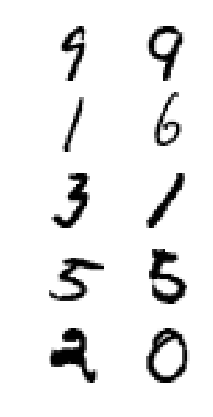

In [65]:
plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

레이블을 확인해 보겠습니다(0은 "다른 것", 1은 "같은 것"을 의미합니다):

In [66]:
y_batch

array([[1],
       [0],
       [0],
       [1],
       [0]])

완벽하네요!

### 10.3.
_문제: 이 훈련 세트로 DNN을 훈련시키세요. 각각의 이미지 쌍에서 첫 번째 이미지는 DNN A에, 두 번째 이미지는 DNN B에 동시에 주입합니다. 전체 네트워크는 두 이미지가 같은 클래스인지 아닌지 구분하도록 점차 학습될 것입니다._

MNIST 테스트 세트에서 추출한 이미지 쌍으로 테스트 세트를 만듭니다:

In [67]:
X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))

이제 모델을 훈련시킵니다. `batch_size`가 크다는 것외에는 이 단계에 특별한 것은 없습니다. 배치 사이즈가 크지 않으면 모델이 학습을 실패하고 50% 정확도밖에 도달하지 못할 것입니다:

In [68]:
n_epochs = 100
batch_size = 500

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(X_train1) // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y: y_batch})
        print(epoch, "훈련 손실:", loss_val)
        if epoch % 5 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
            print(epoch, "테스트 정확도:", acc_test)

    save_path = saver.save(sess, "./my_digit_comparison_model.ckpt")

0 훈련 손실: 0.6910327
0 테스트 정확도: 0.542
1 훈련 손실: 0.60353535
2 훈련 손실: 0.54946035
3 훈련 손실: 0.47047248
4 훈련 손실: 0.40607572
5 훈련 손실: 0.38308156
5 테스트 정확도: 0.824
6 훈련 손실: 0.39047274
7 훈련 손실: 0.3390794
8 훈련 손실: 0.32106707
9 훈련 손실: 0.31792685
10 훈련 손실: 0.2449429
10 테스트 정확도: 0.8881
11 훈련 손실: 0.29292363
12 훈련 손실: 0.23225443
13 훈련 손실: 0.23180935
14 훈련 손실: 0.19877934
15 훈련 손실: 0.20065455
15 테스트 정확도: 0.9203
16 훈련 손실: 0.19700493
17 훈련 손실: 0.18893152
18 훈련 손실: 0.19965449
19 훈련 손실: 0.24071635
20 훈련 손실: 0.18882033
20 테스트 정확도: 0.9367
21 훈련 손실: 0.12419204
22 훈련 손실: 0.14013425
23 훈련 손실: 0.12078951
24 훈련 손실: 0.15721157
25 훈련 손실: 0.1150786
25 테스트 정확도: 0.948
26 훈련 손실: 0.13891114
27 훈련 손실: 0.15260834
28 훈련 손실: 0.12343672
29 훈련 손실: 0.11543137
30 훈련 손실: 0.114028156
30 테스트 정확도: 0.9507
31 훈련 손실: 0.11897129
32 훈련 손실: 0.09546706
33 훈련 손실: 0.08299535
34 훈련 손실: 0.13659254
35 훈련 손실: 0.06801726
35 테스트 정확도: 0.9592
36 훈련 손실: 0.110167935
37 훈련 손실: 0.049500983
38 훈련 손실: 0.08134085
39 훈련 손실: 0.09441987
40 훈련 손실: 0.0873715
40 테

좋습니다. 숫자 비교 작업에서 97.6% 정확도를 달성했습니다. 아주 나쁘지 않네요. 이 모델은 손글씨 숫자를 비교하는 능력을 갖추었습니다!

이 지식을 일반 MNIST 분류 문제에 사용할 수 있는지 확인해 보겠습니다.

### 10.4.
_문제: 이제 DNN A의 은닉층을 동결해서 재사용하고 10개의 뉴런으로 된 소프트맥스 출력 층을 추가한 새로운 DNN을 만듭니다. 이 네트워크를 분할 #2에 대해 훈련시켜보고 클래스당 500개의 이미지만으로도 높은 성능을 얻을 수 있는지 확인해보세요._

모델을 만드는 것은 매우 간단합니다. 하위층을 동결하는 방법이 많이 있습니다. 이 예제에서는 `tf.stop_gradient()` 함수를 사용하겠습니다. 미리 학습된 DNN A를 복원하기 위해 `Saver` 객체가 필요하고 최종 모델을 저장하기 위해 다른 `Saver` 객체가 필요합니다:

In [69]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")
frozen_outputs = tf.stop_gradient(dnn_outputs)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

이제 훈련입니다! 모든 변수를 초기화하고(새 출력층의 변수를 포함하여), 미리 학습된 DNN A를 복원합니다. 다음에 작은 MNIST 데이터셋(5,000개 이미지)에 이 모델을 훈련시킵니다:

In [70]:
n_epochs = 100
batch_size = 50

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_digit_comparison_model.ckpt")

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "테스트 정확도:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_digit_comparison_model.ckpt
0 테스트 정확도: 0.9455
10 테스트 정확도: 0.9646
20 테스트 정확도: 0.9659
30 테스트 정확도: 0.966
40 테스트 정확도: 0.9661
50 테스트 정확도: 0.9659
60 테스트 정확도: 0.9657
70 테스트 정확도: 0.9657
80 테스트 정확도: 0.9656
90 테스트 정확도: 0.9657


오 96.7% 정확도네요. 지금까지 훈련시킨 최고의 MNIST 모델은 아니지만 아주 작은 훈련 세트(숫자당 500개 이미지)를 사용한 것을 유념하세요. 전이 학습을 사용하지 않고 그냥 처음부터 학습시킨 DNN과 결과를 비교해 보겠습니다:

In [71]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

In [72]:
n_epochs = 150
batch_size = 50

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "테스트 정확도:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

0 테스트 정확도: 0.8694
10 테스트 정확도: 0.9276
20 테스트 정확도: 0.936
30 테스트 정확도: 0.9418
40 테스트 정확도: 0.9421
50 테스트 정확도: 0.9425
60 테스트 정확도: 0.9426
70 테스트 정확도: 0.9423
80 테스트 정확도: 0.9425
90 테스트 정확도: 0.9426
100 테스트 정확도: 0.9427
110 테스트 정확도: 0.9427
120 테스트 정확도: 0.9429
130 테스트 정확도: 0.9429
140 테스트 정확도: 0.9428


94.8% 정확도 밖에 안되네요. 전이 학습이 에러율를 5.2%에서 3.3%로 낮추어 주었습니다(36% 이상 에러가 감소했습니다). 더군다나 전이 학습을 사용한 모델은 10번의 에포크만에 96%의 정확도에 도달했습니다.

최종 결과: 전이 학습이 항상 좋은 결과를 내지는 않습니다(연습문제 9에서 보았듯이). 하지만 그렇지 않을 땐 아주 큰 차이를 만들 수 있습니다. 그러므로 꼭 시도해 보세요!